<a href="https://colab.research.google.com/github/Ilvecho/Project_5/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from datetime import timedelta

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

!pip install pmdarima
import pmdarima as pm
from pmdarima import auto_arima

# Import and load data

In [2]:
files.upload()
pass

Saving 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv to 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv to 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv to 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv to 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv to 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv to 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv to 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv
Saving 2020Q1Q2Q

In [3]:
def parse_vol(raw_x):

  x = raw_x.replace('.', '')
  if x[-1] == 'K':
    x = x.replace('K', '0')
  elif x[-1] == 'M':
    x = x.replace('M', '0000')
  try:
    return float(x)
  except:
    return np.nan

In [4]:
file_list = os.listdir('/content/')
data = {}

for filename in file_list:
  if filename.startswith('2020Q1'):

    # Extract the country from the file name
    country = filename.split(' - ')[1].strip()
    tmp_data = pd.read_csv(filename)[:-1]

    # Set the Date as proper dtype, and set it as index
    tmp_data['Date'] = pd.to_datetime(tmp_data['Date'])
    tmp_data.set_index('Date', inplace=True)

    # Parse the columns
    # Price
    tmp_data['Price'] = tmp_data['Price'].apply(lambda x: x.replace(',', ''))
    tmp_data['Price'] = pd.to_numeric(tmp_data['Price'])

    # Open
    tmp_data['Open'] = tmp_data['Open'].apply(lambda x: x.replace(',', ''))
    tmp_data['Open'] = pd.to_numeric(tmp_data['Open'])

    # High
    tmp_data['High'] = tmp_data['High'].apply(lambda x: x.replace(',', ''))
    tmp_data['High'] = pd.to_numeric(tmp_data['High'])

    # Low
    tmp_data['Low'] = tmp_data['Low'].apply(lambda x: x.replace(',', ''))
    tmp_data['Low'] = pd.to_numeric(tmp_data['Low'])

    # Vol.
    tmp_data['Vol.'] = tmp_data['Vol.'].apply(parse_vol)

    # Change %
    tmp_data['Change %'] = tmp_data['Change %'].apply(lambda x: float(x.strip('%')))

    # Set the frequency of the DataFrame to b = Business days
    tmp_data = tmp_data.asfreq('b')

    # By setting the frequency we create new rows which are empty (business days in which the stock market was closed, e.g. Public Holidays)
    # We need to fill the missing values, and we opt for a forward fill, i.e. we use the value of the previous day
    tmp_data = tmp_data.fillna(method='ffill')

    # sort the index
    tmp_data = tmp_data.sort_index()

    # Stored the processed data in the Dict
    data[country] = tmp_data

In [ ]:
for key in data.keys():
  print('\n\n###########\n')
  print(key)
  print(data[key].info())

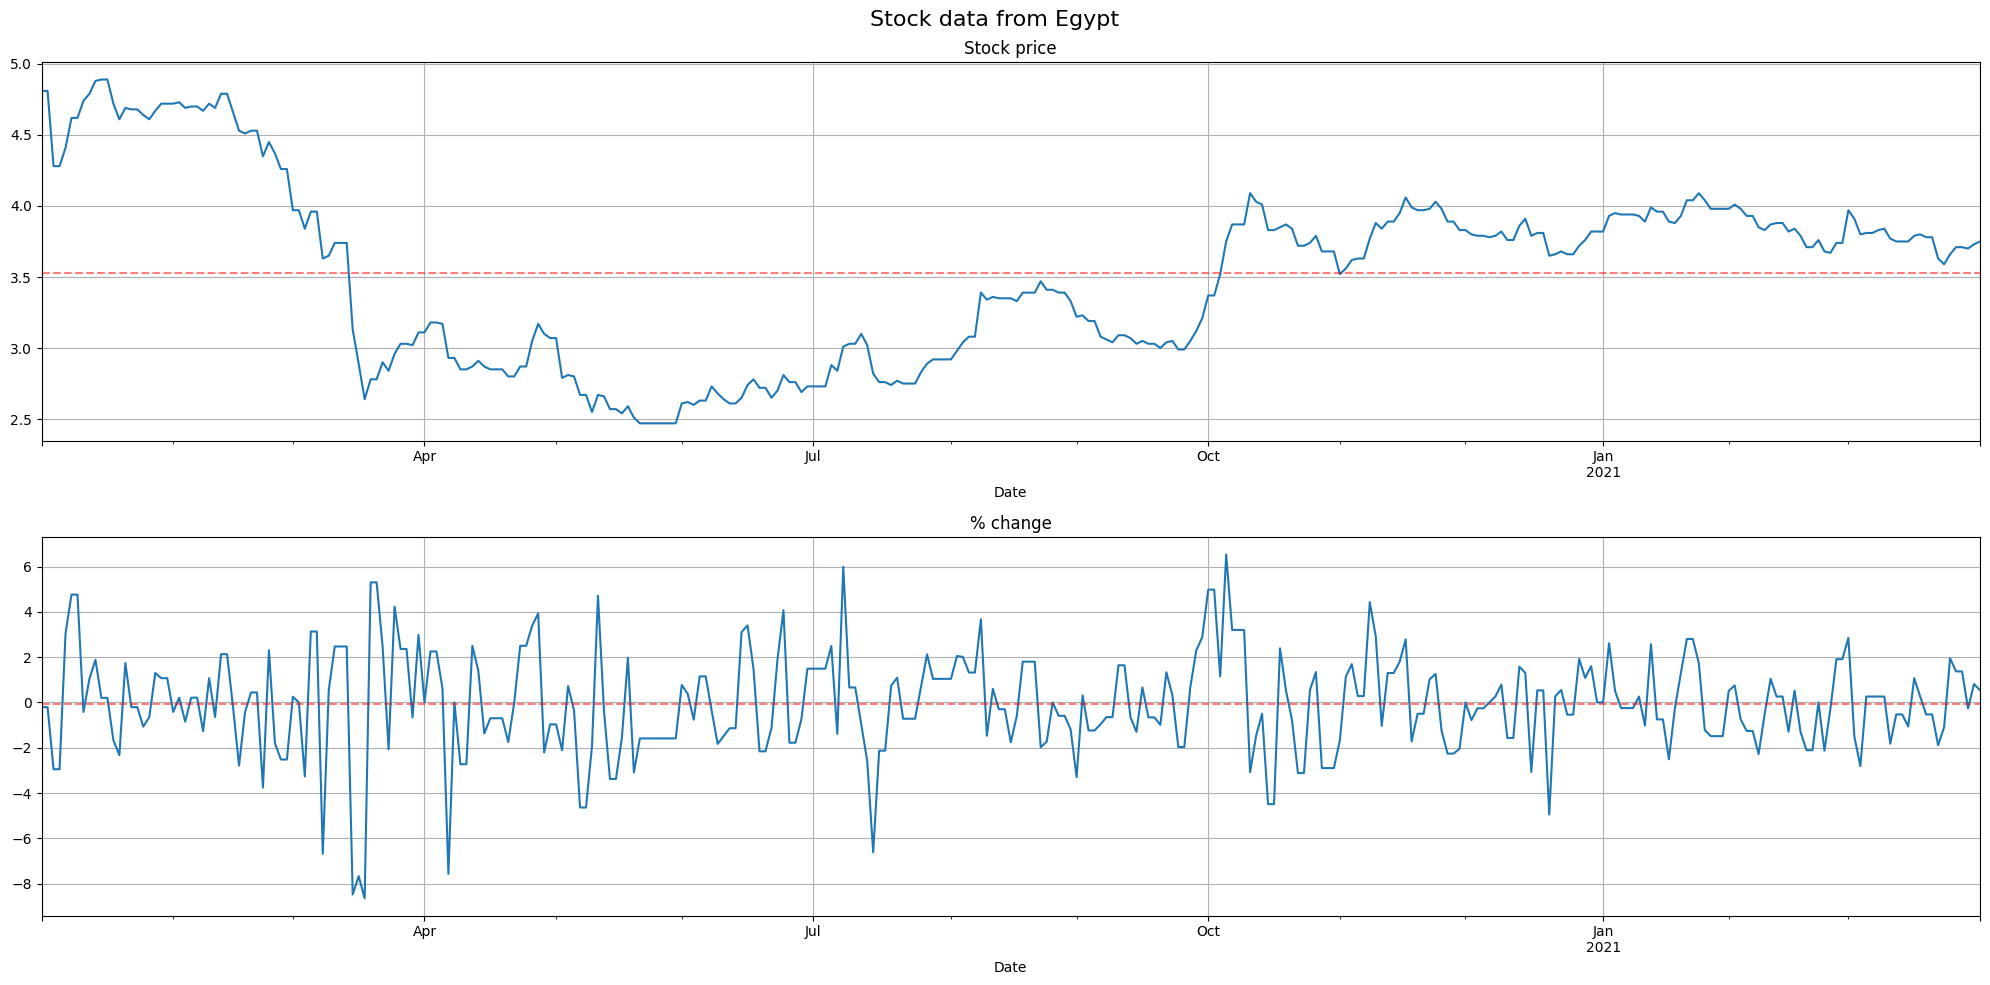

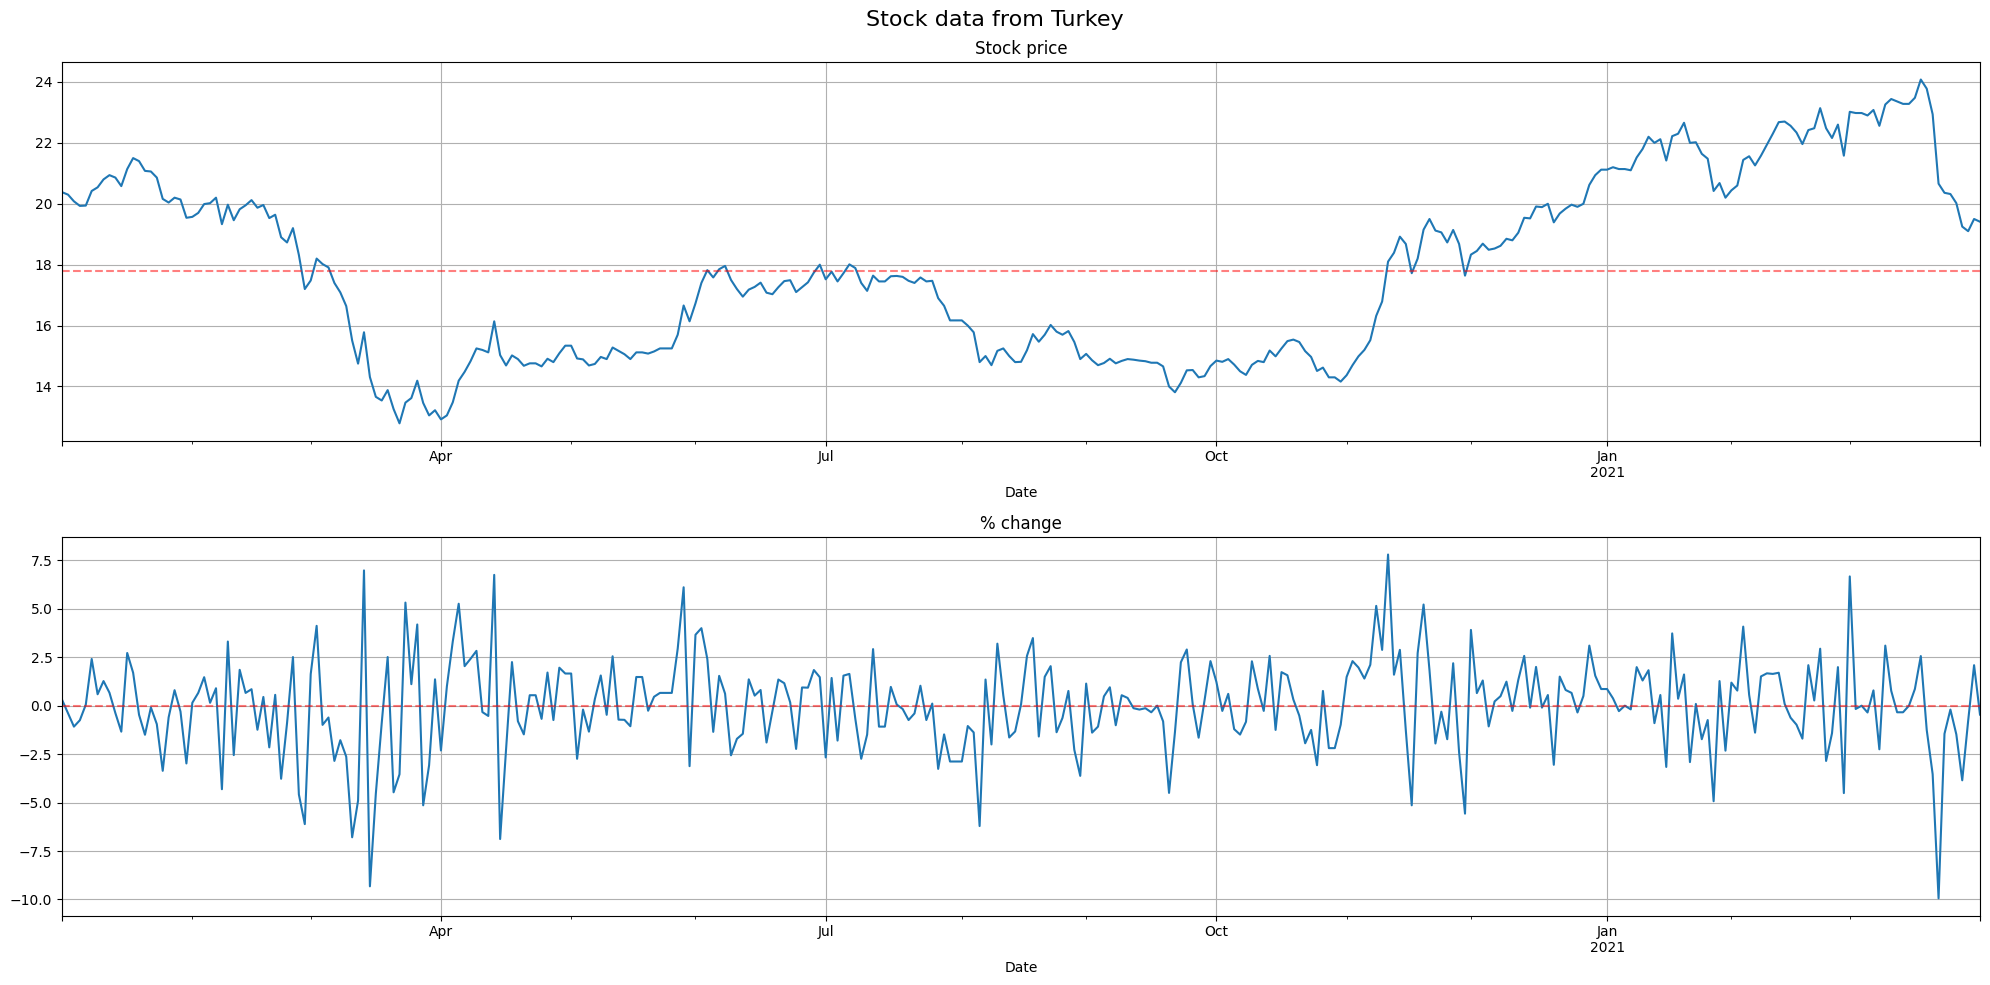

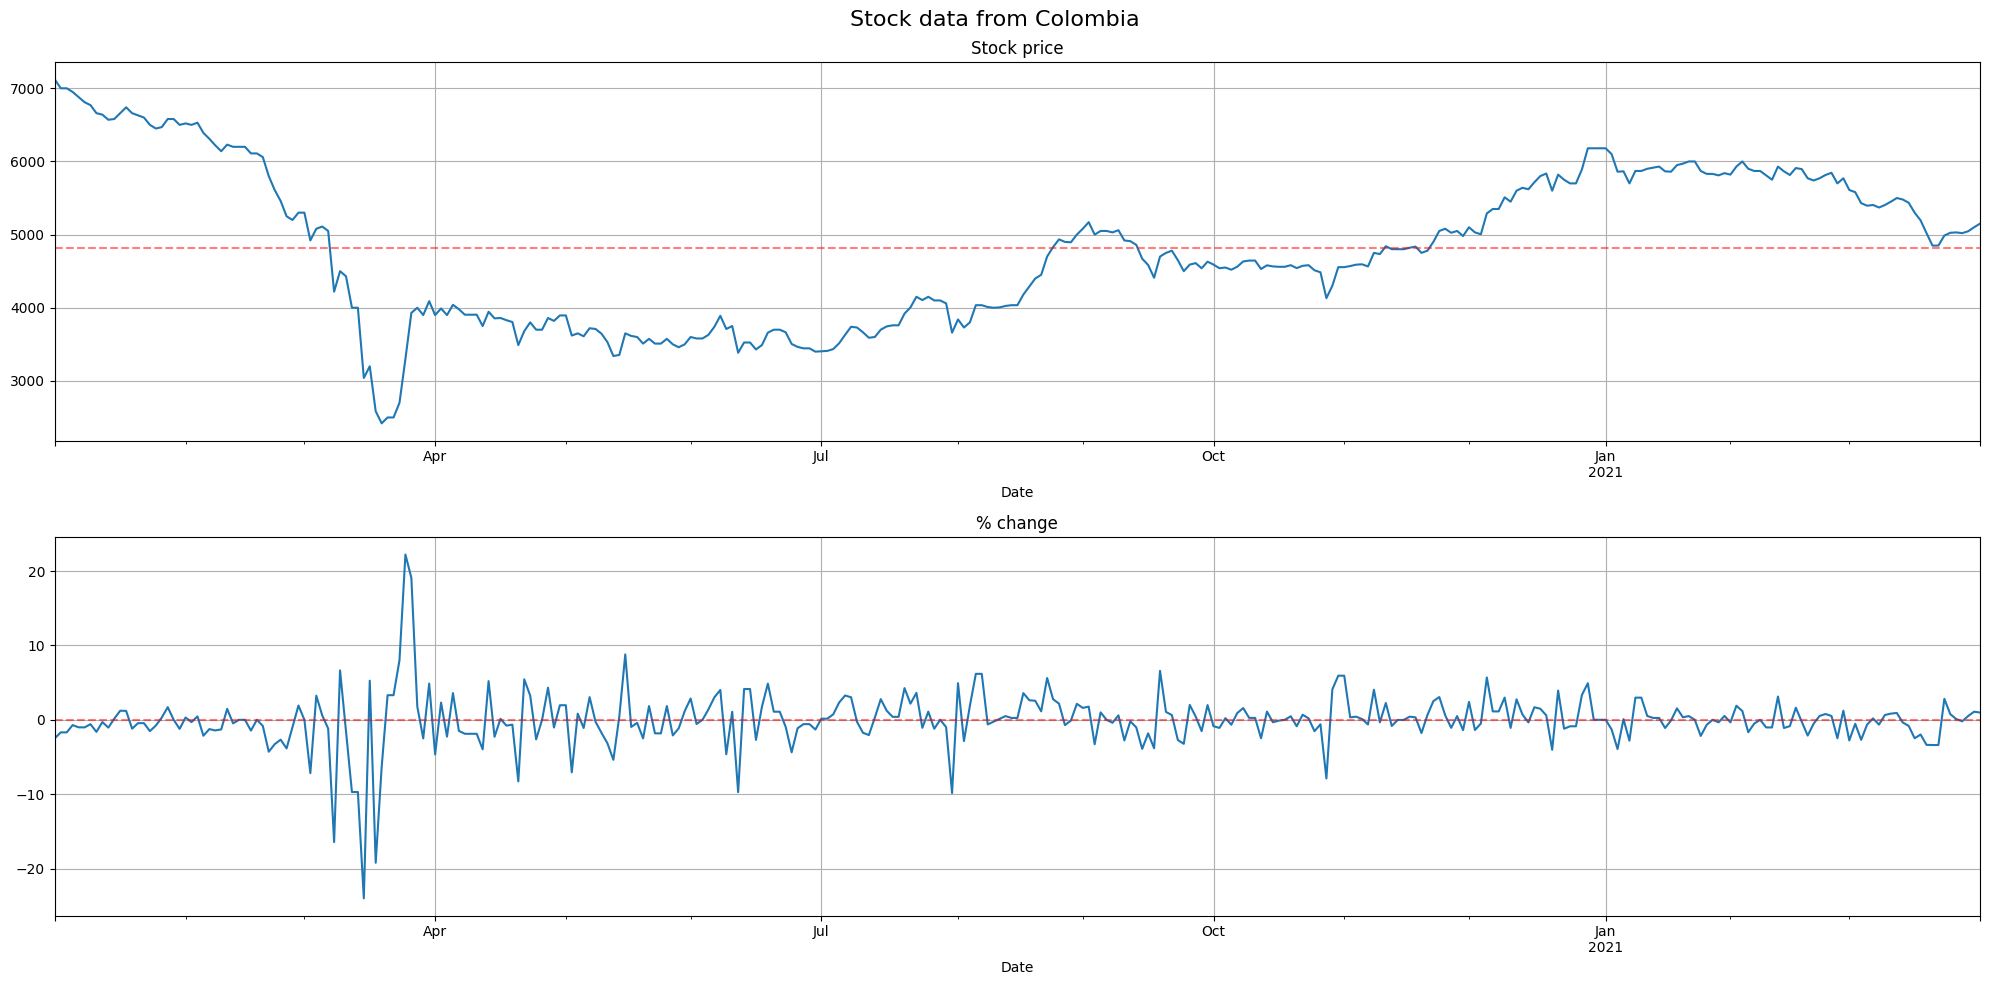

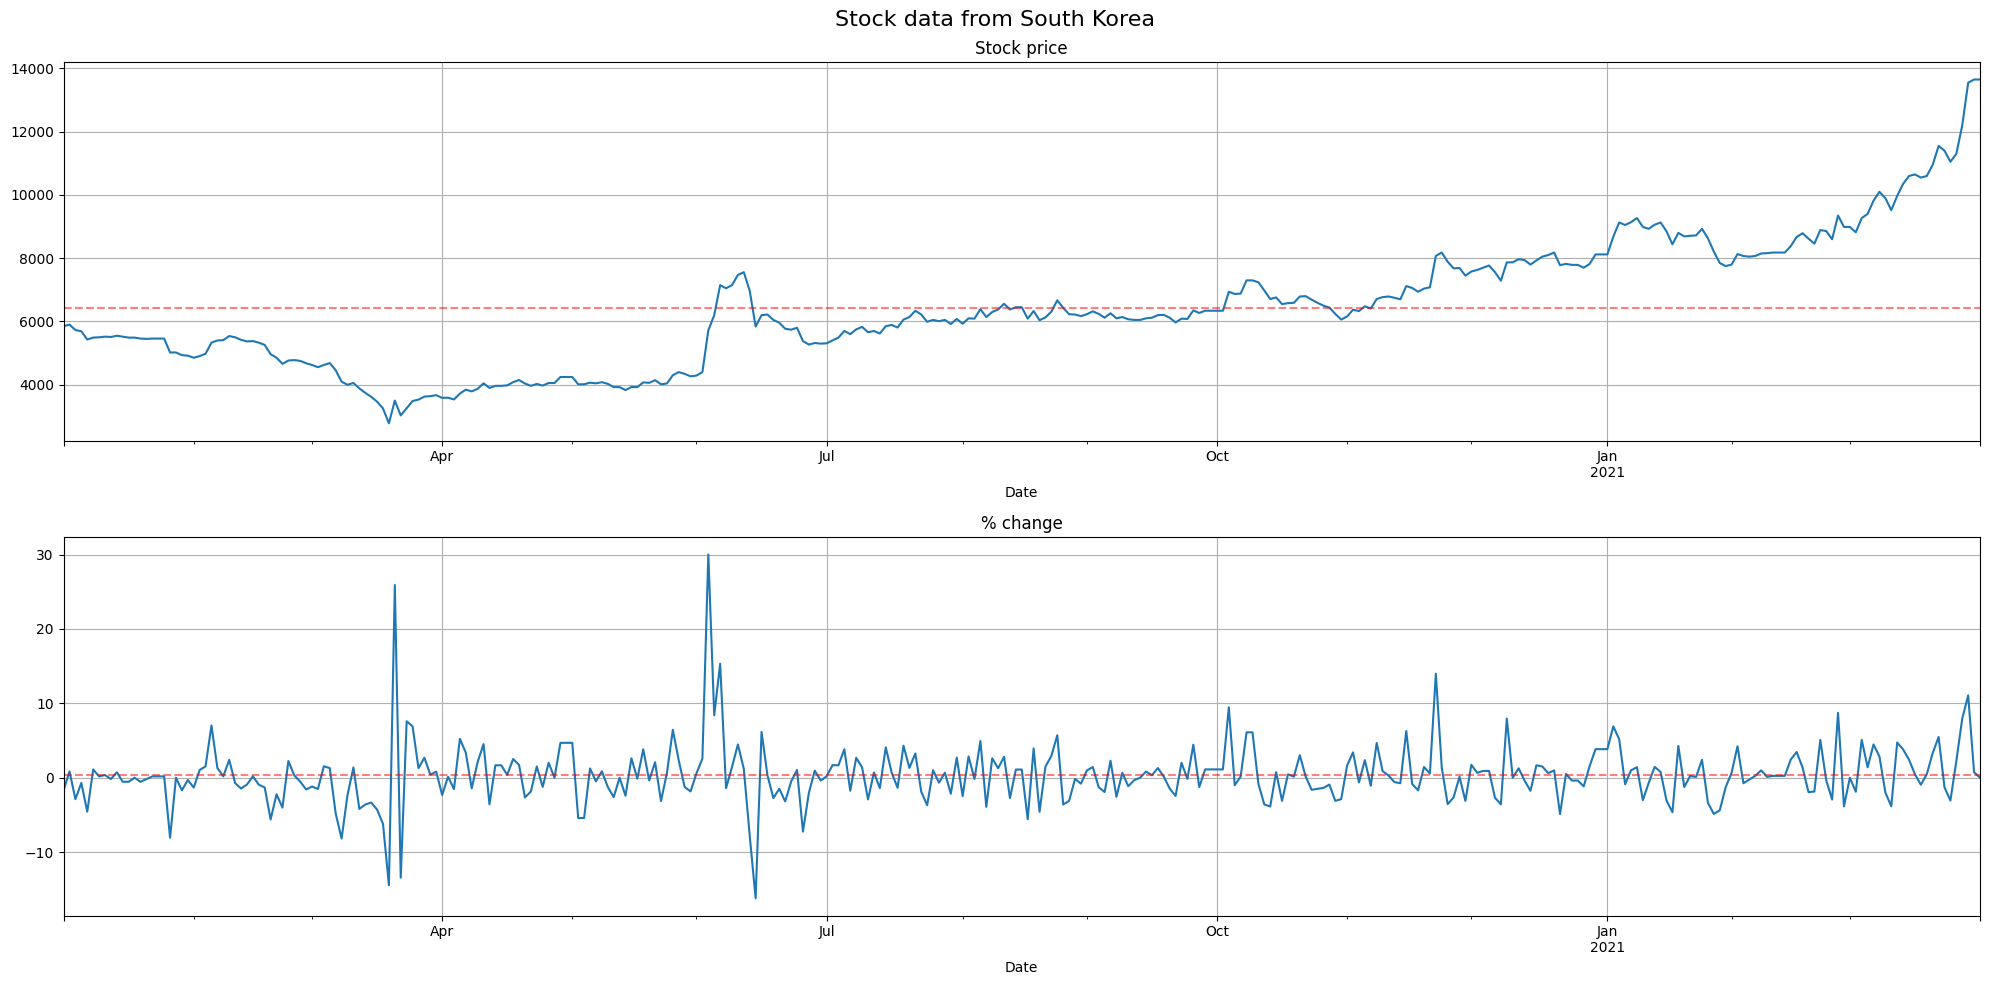

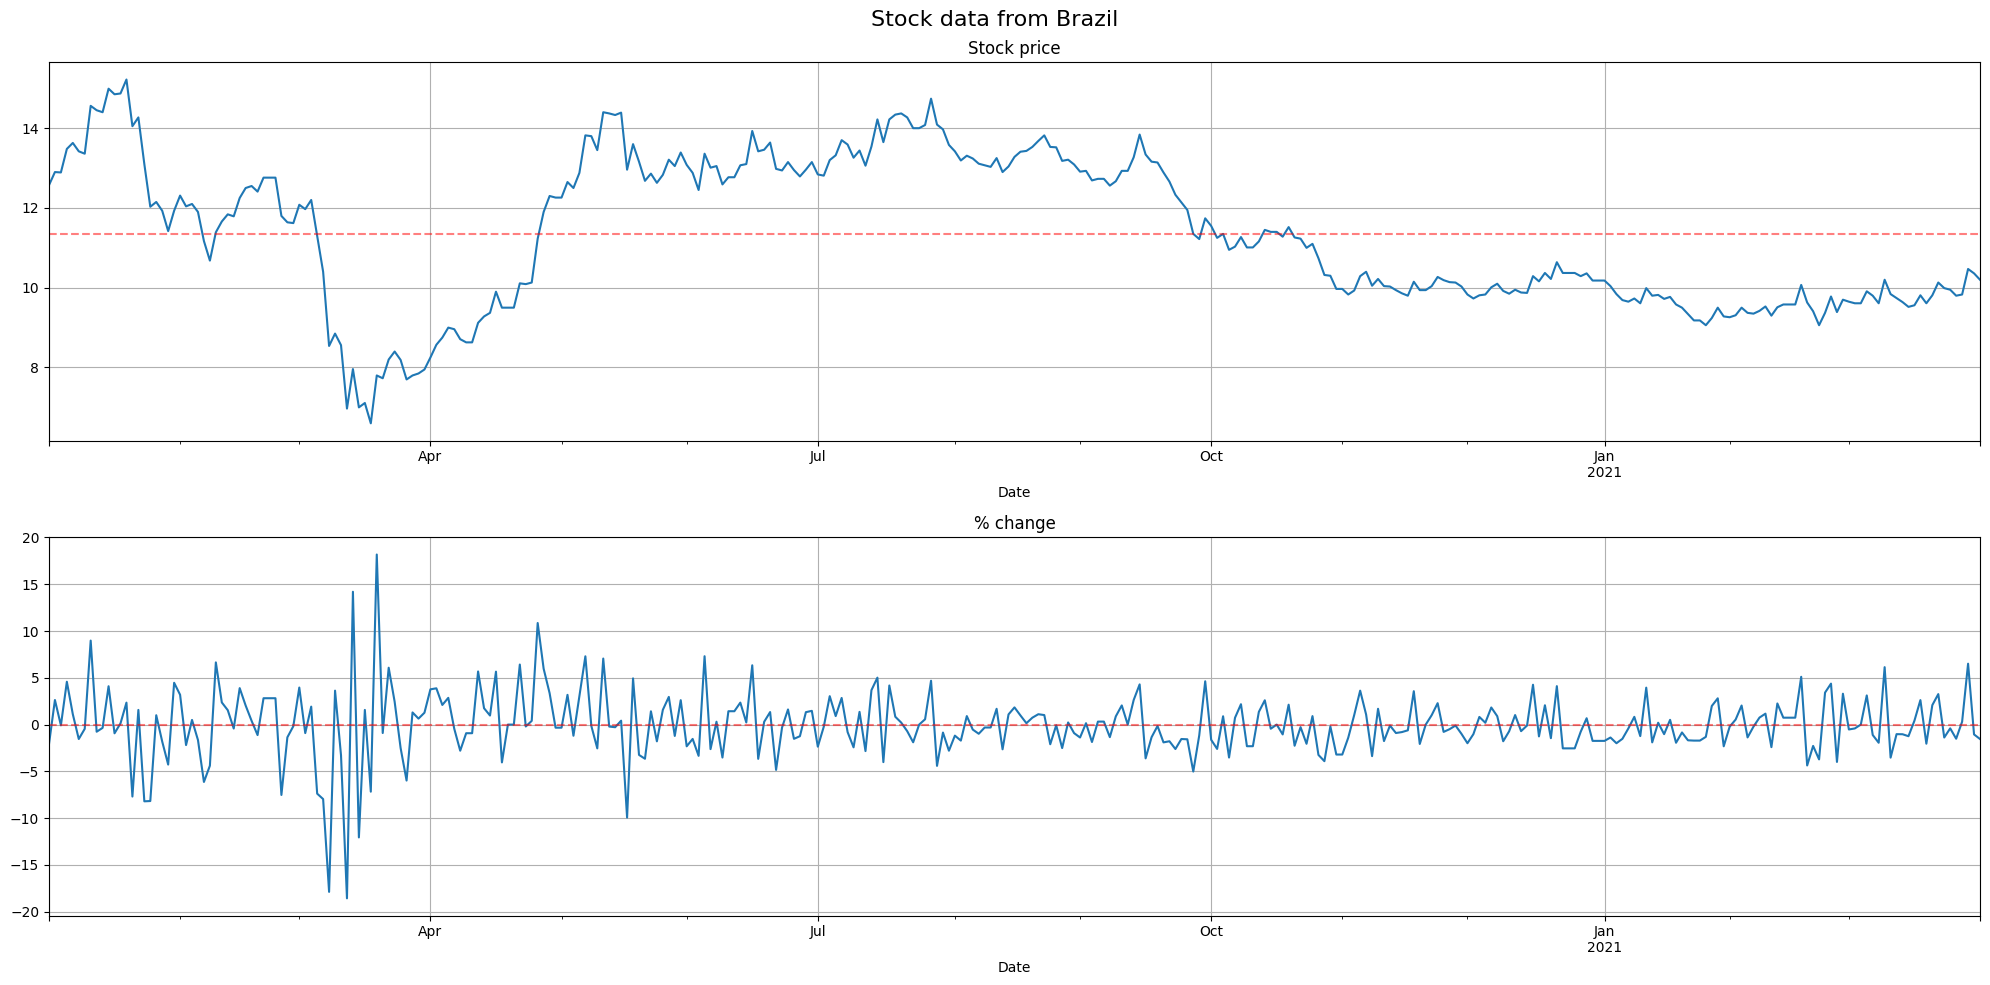

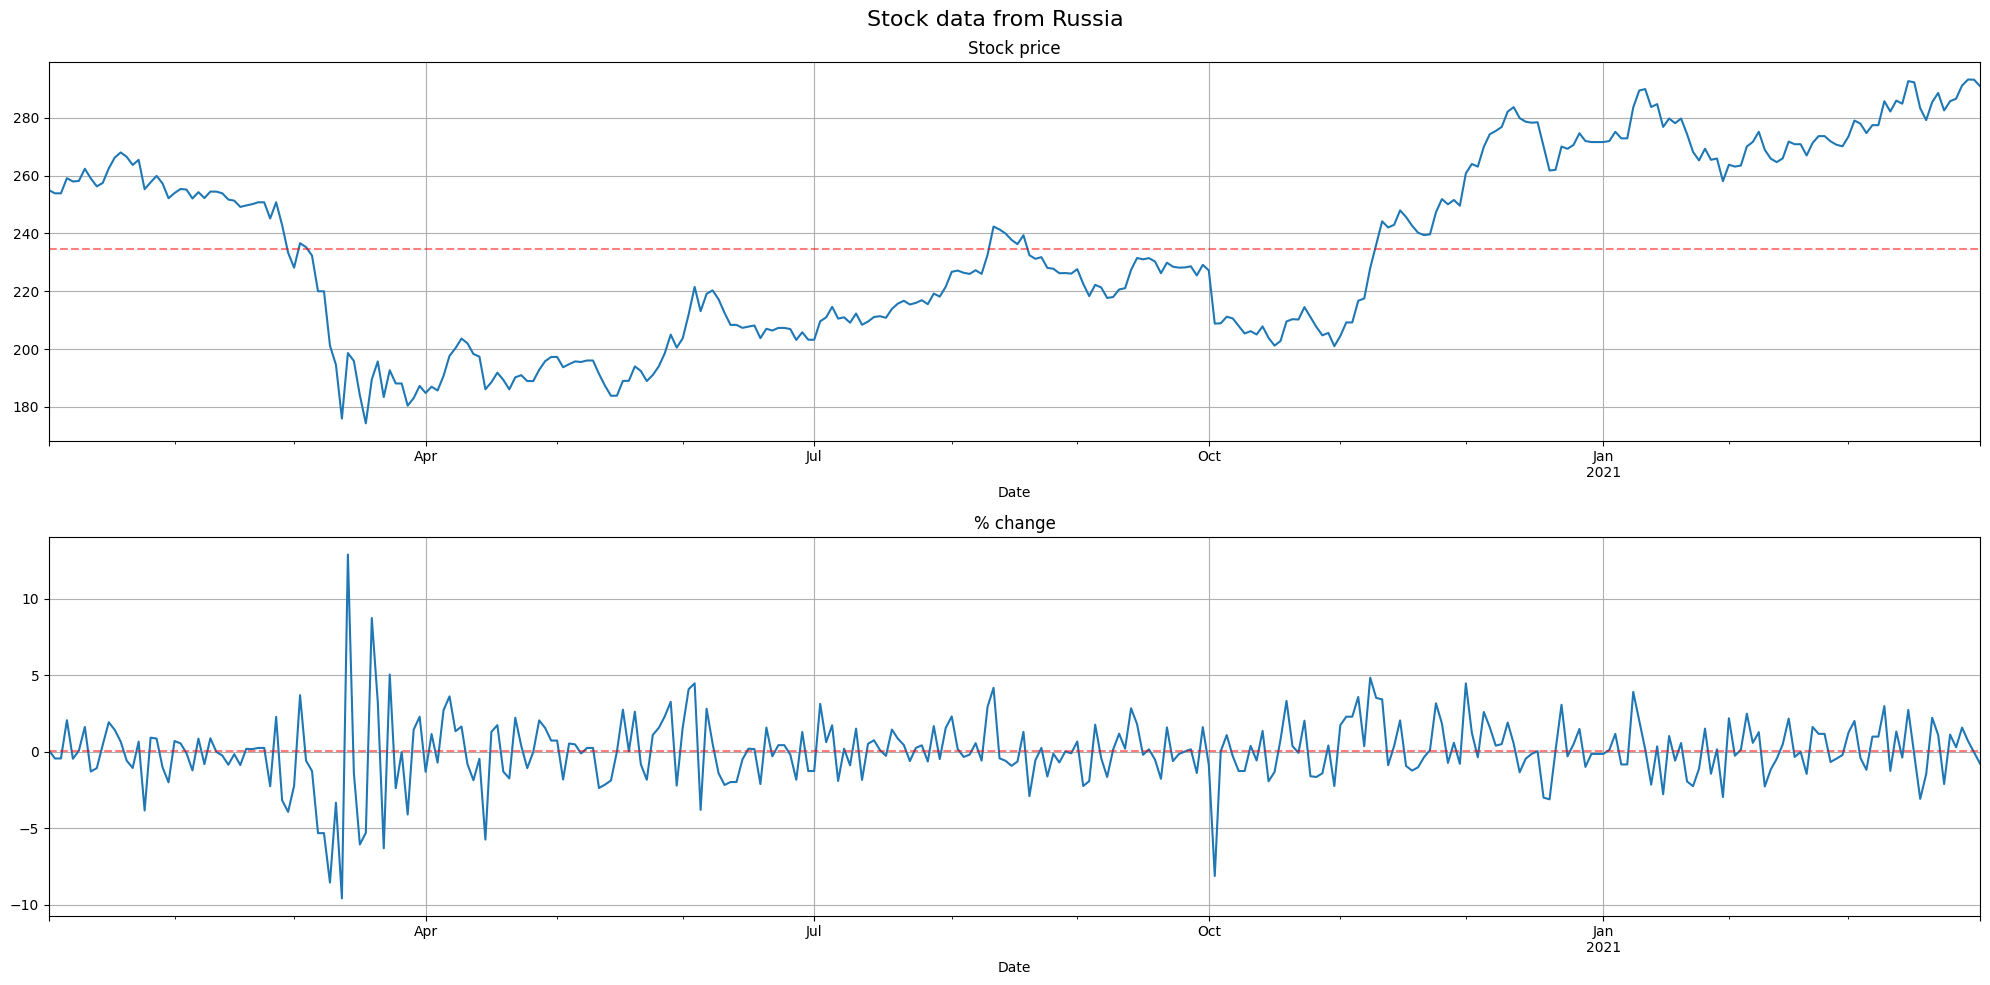

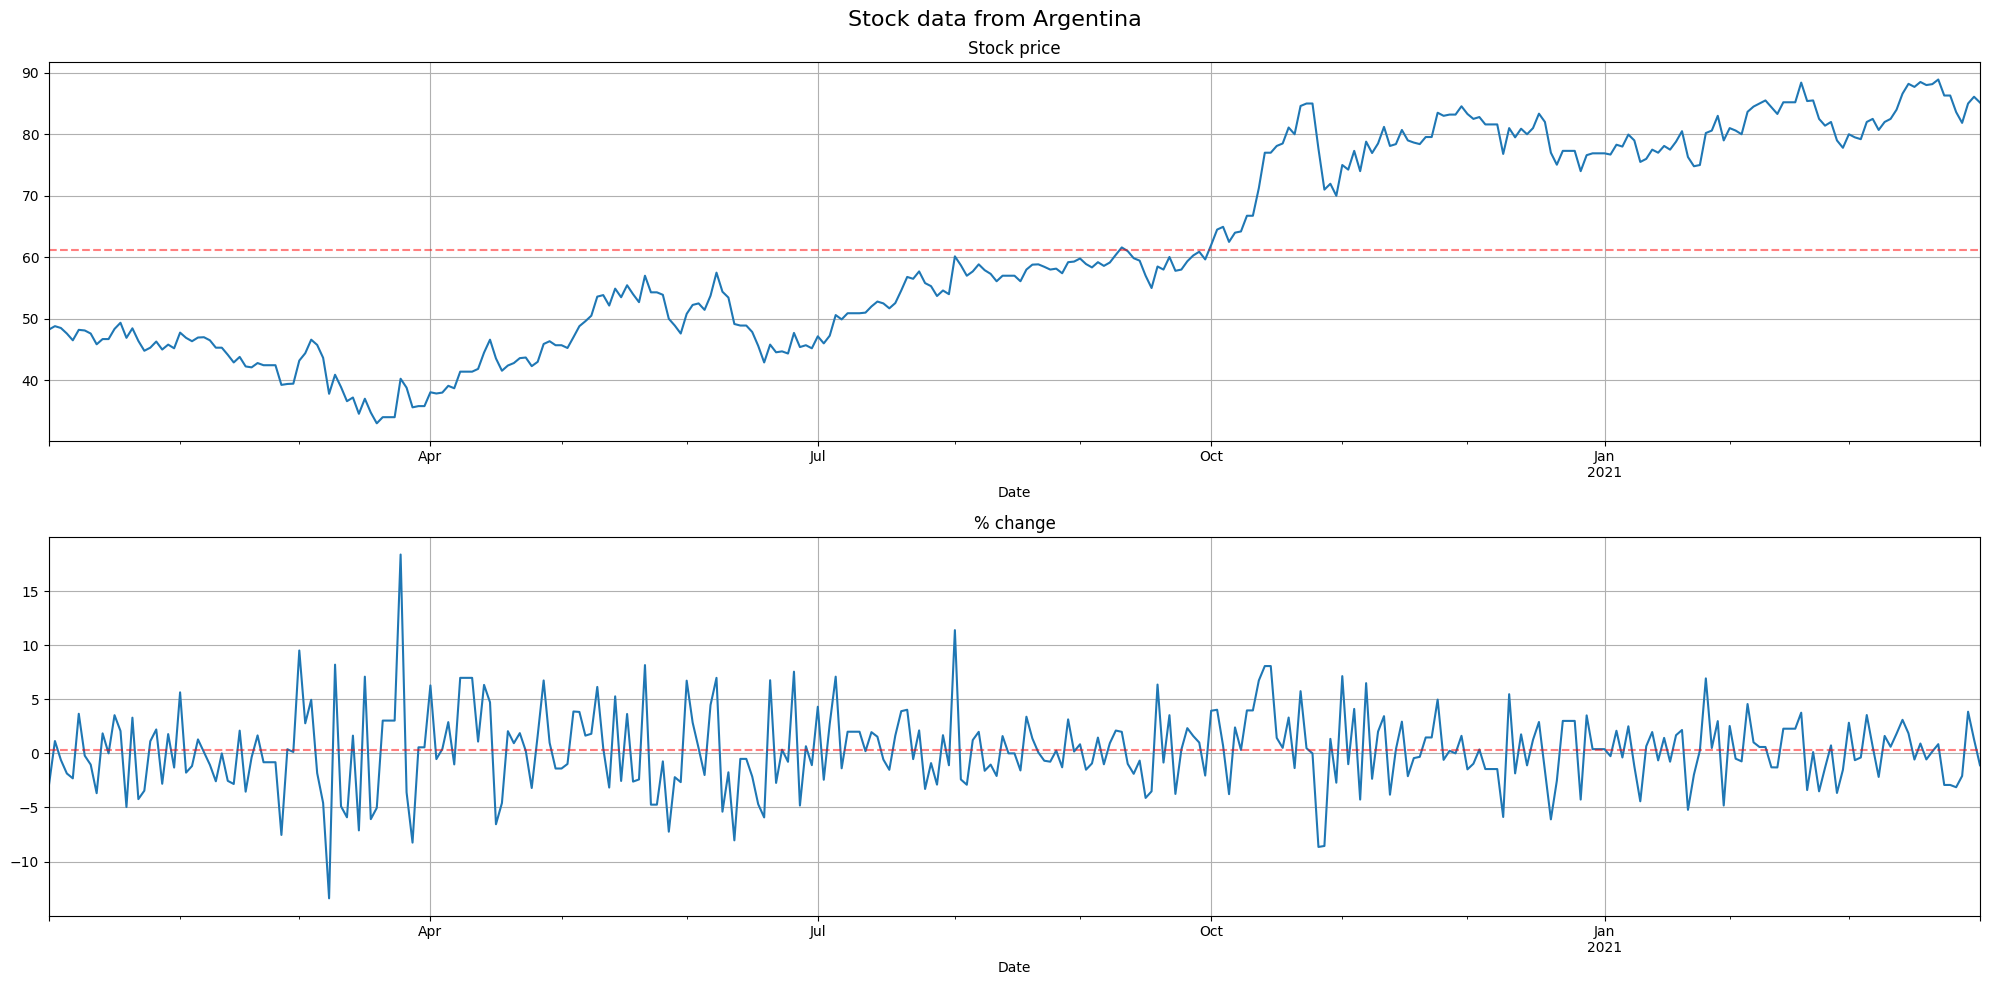

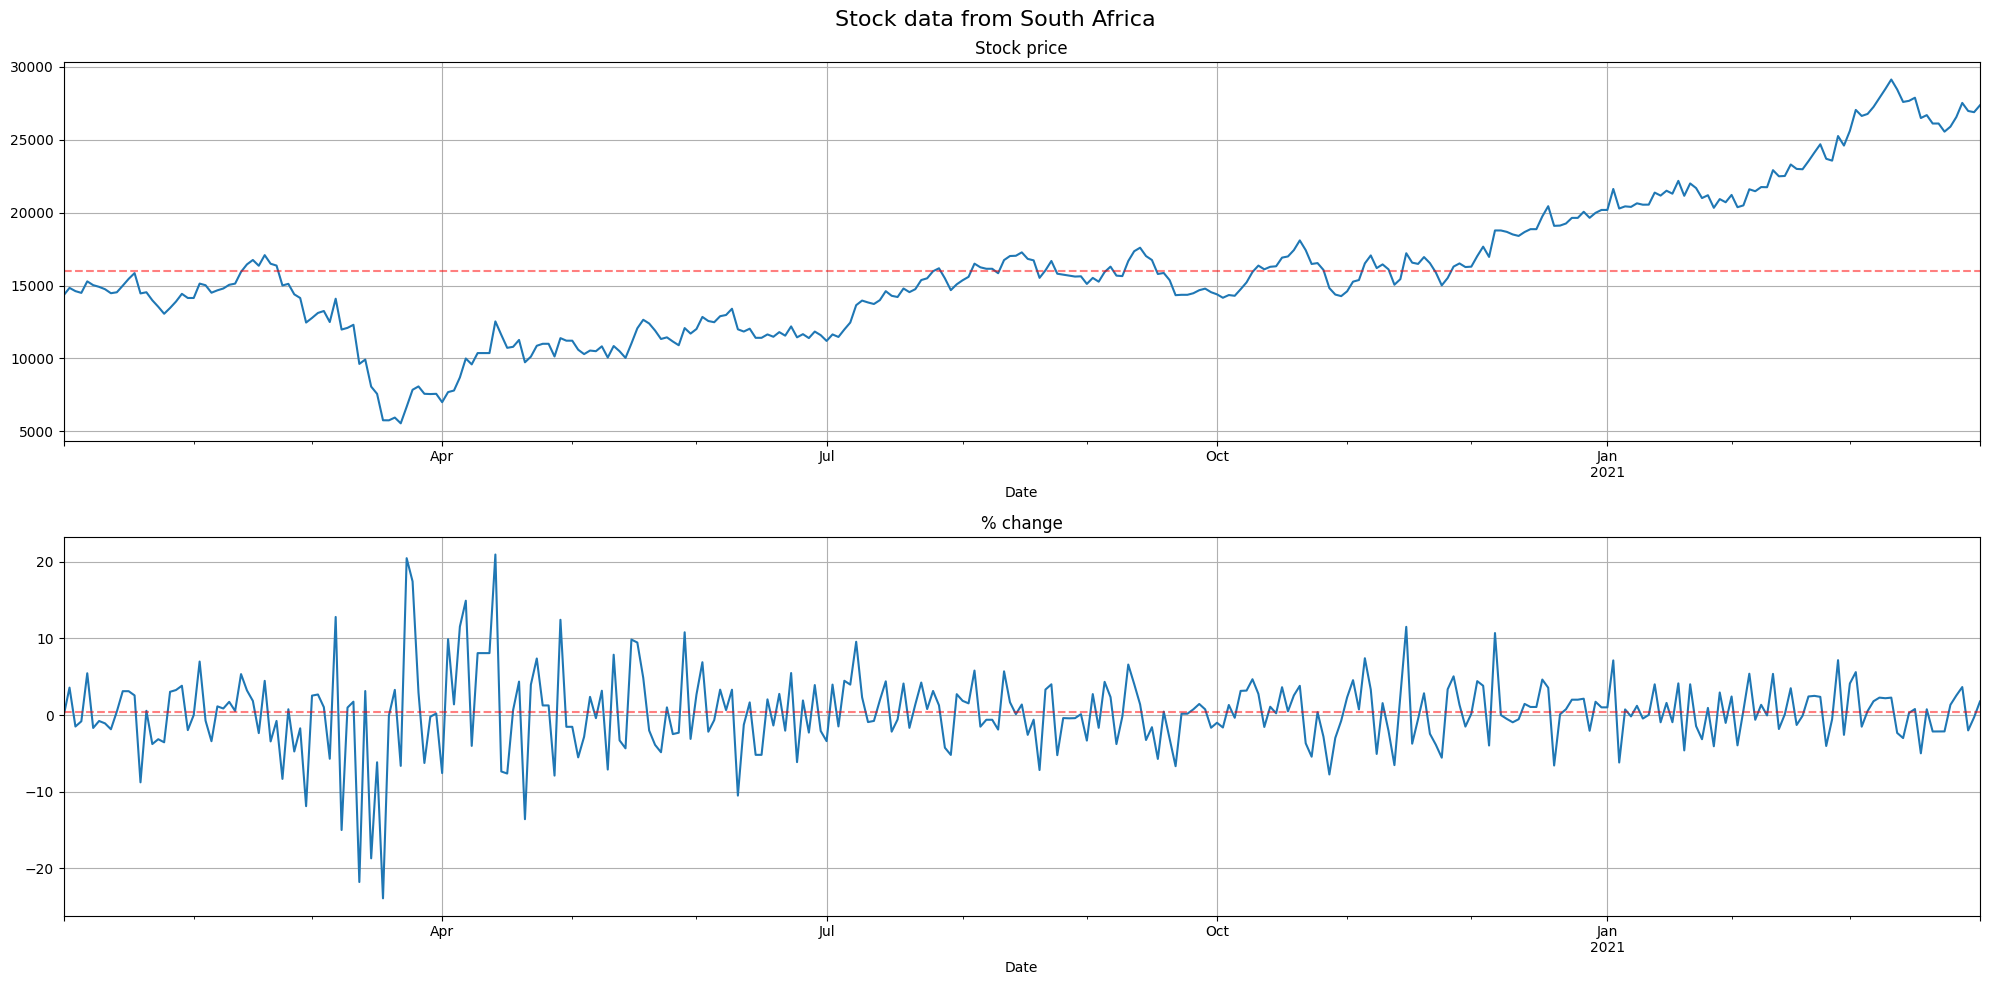

In [24]:
for key in data.keys():

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
  # Plot the price in subplot 1
  data[key]['Price'].plot(ax=axes[0], grid='on')
  axes[0].axhline(y=data[key]['Price'].mean(), color='red',  alpha=0.5, linestyle='--')
  axes[0].set_title('Stock price')

  # Plot the Change % in subplot 2
  data[key]['Change %'].plot(ax=axes[1], grid='on')
  axes[1].axhline(y=data[key]['Change %'].mean(), color='red',  alpha=0.5, linestyle='--')
  axes[1].set_title('% change')

  # set the figure title
  fig.suptitle(f'Stock data from {key}', fontsize=16)

  plt.tight_layout()
  plt.show()

We can clearly see that the Price time series are **not stationary** (we will robustly test this statement, but also the visual inspection is enough).

On the other hand, the **change %** looks stationary

# EDA - stationarity

We verify the stationarity of the time series using the **Augmented Dickey-Fuller** test

In [26]:
for key in data.keys():
  p_price = adfuller(data[key]['Price'])
  p_change = adfuller(data[key]['Change %'])

  print(f'##########\n{key.upper()}\n')
  print('The p-value of the price is: ', p_price[1])
  print('The p-value of the change is: ', p_change[1])
  print('\n')

##########
EGYPT

The p-value of the price is:  0.24529851951451465
The p-value of the change is:  2.2460564051821874e-08


##########
TURKEY

The p-value of the price is:  0.5749764210297075
The p-value of the change is:  3.965023755190487e-10


##########
COLOMBIA

The p-value of the price is:  0.1879471059211641
The p-value of the change is:  1.2525817038593144e-12


##########
SOUTH KOREA

The p-value of the price is:  0.9973977003970093
The p-value of the change is:  1.778736997751879e-20


##########
BRAZIL

The p-value of the price is:  0.18411806668707226
The p-value of the change is:  1.2389232057027393e-11


##########
RUSSIA

The p-value of the price is:  0.7374602050812519
The p-value of the change is:  0.0001613258321228002


##########
ARGENTINA

The p-value of the price is:  0.8756756136964812
The p-value of the change is:  2.3476184551068446e-30


##########
SOUTH AFRICA

The p-value of the price is:  0.968855539556175
The p-value of the change is:  2.2714951607530134e-

We can see that the change % from all countries is **stationary**.

On the other hand, the Price is typically **non stationary**. The exceptions are Egypt, Colombia and Brazil, which show a stationary stock price as well

# EDA - autocorrelation

let's compute the autocorrelation of the change series

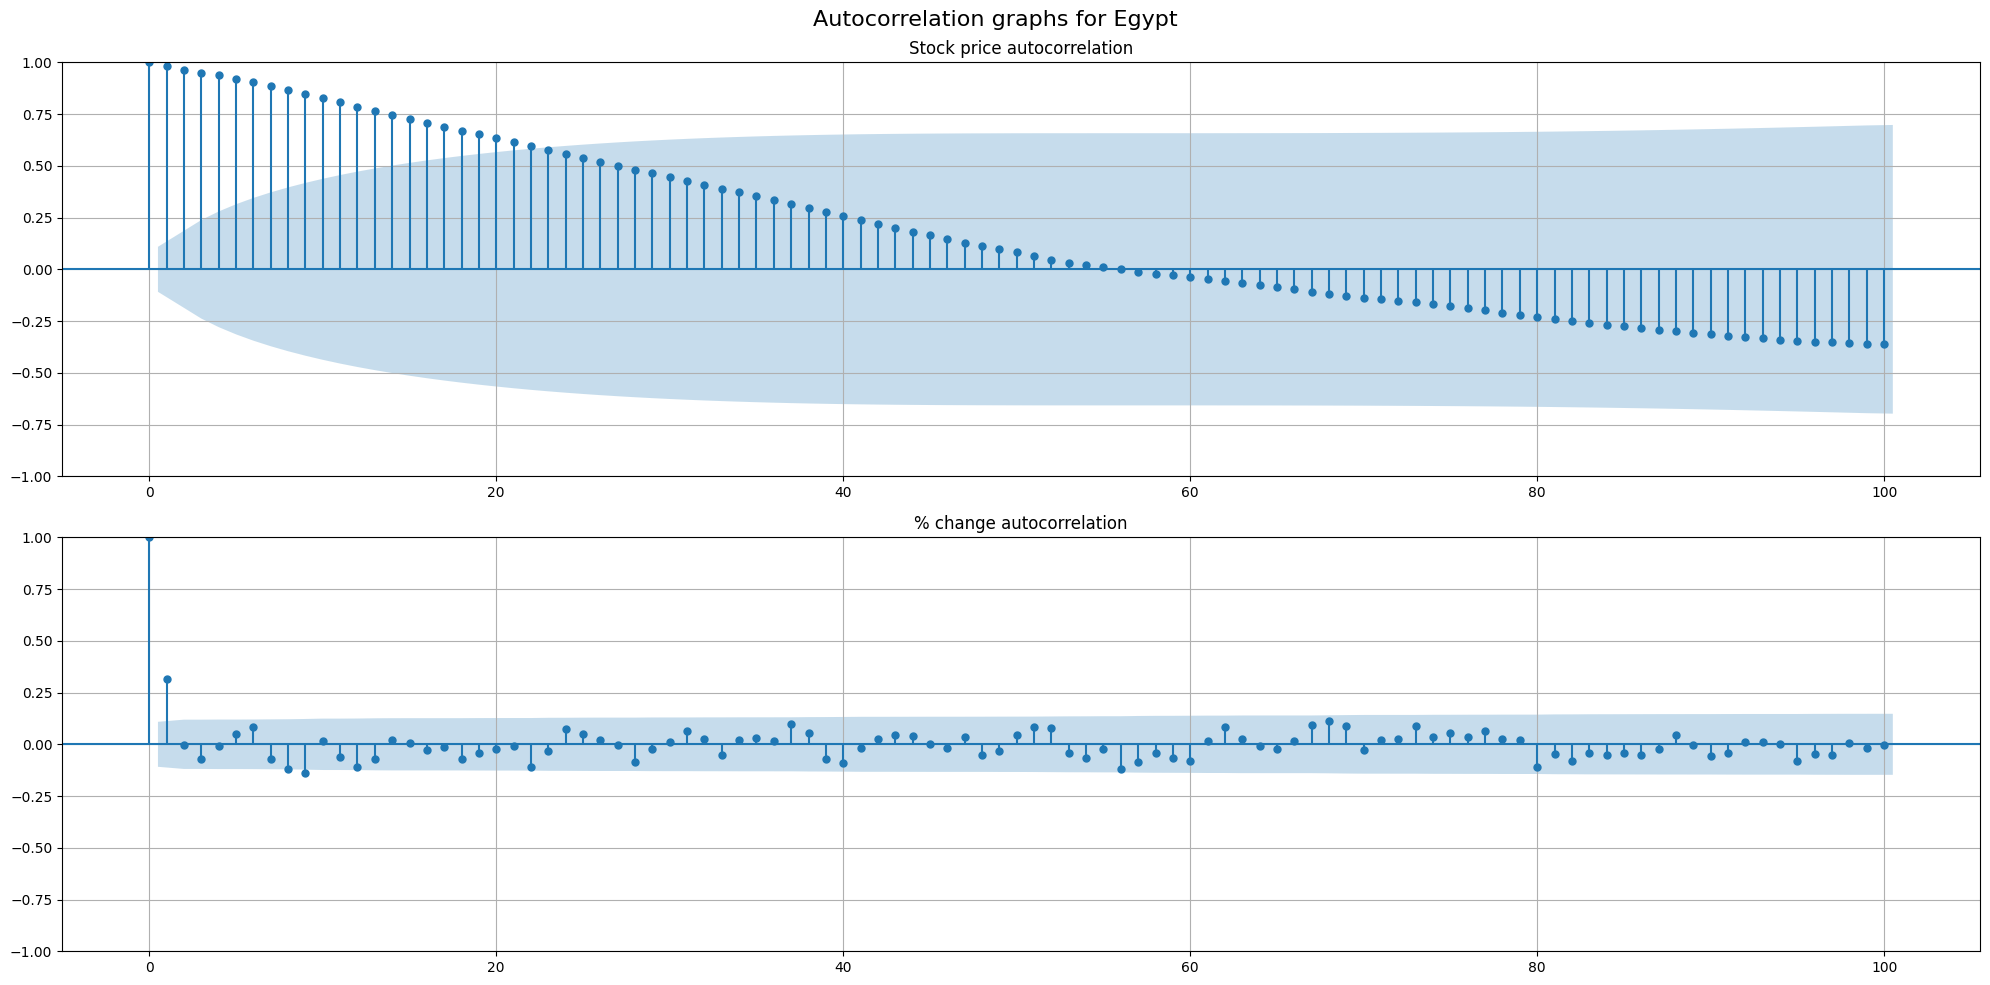

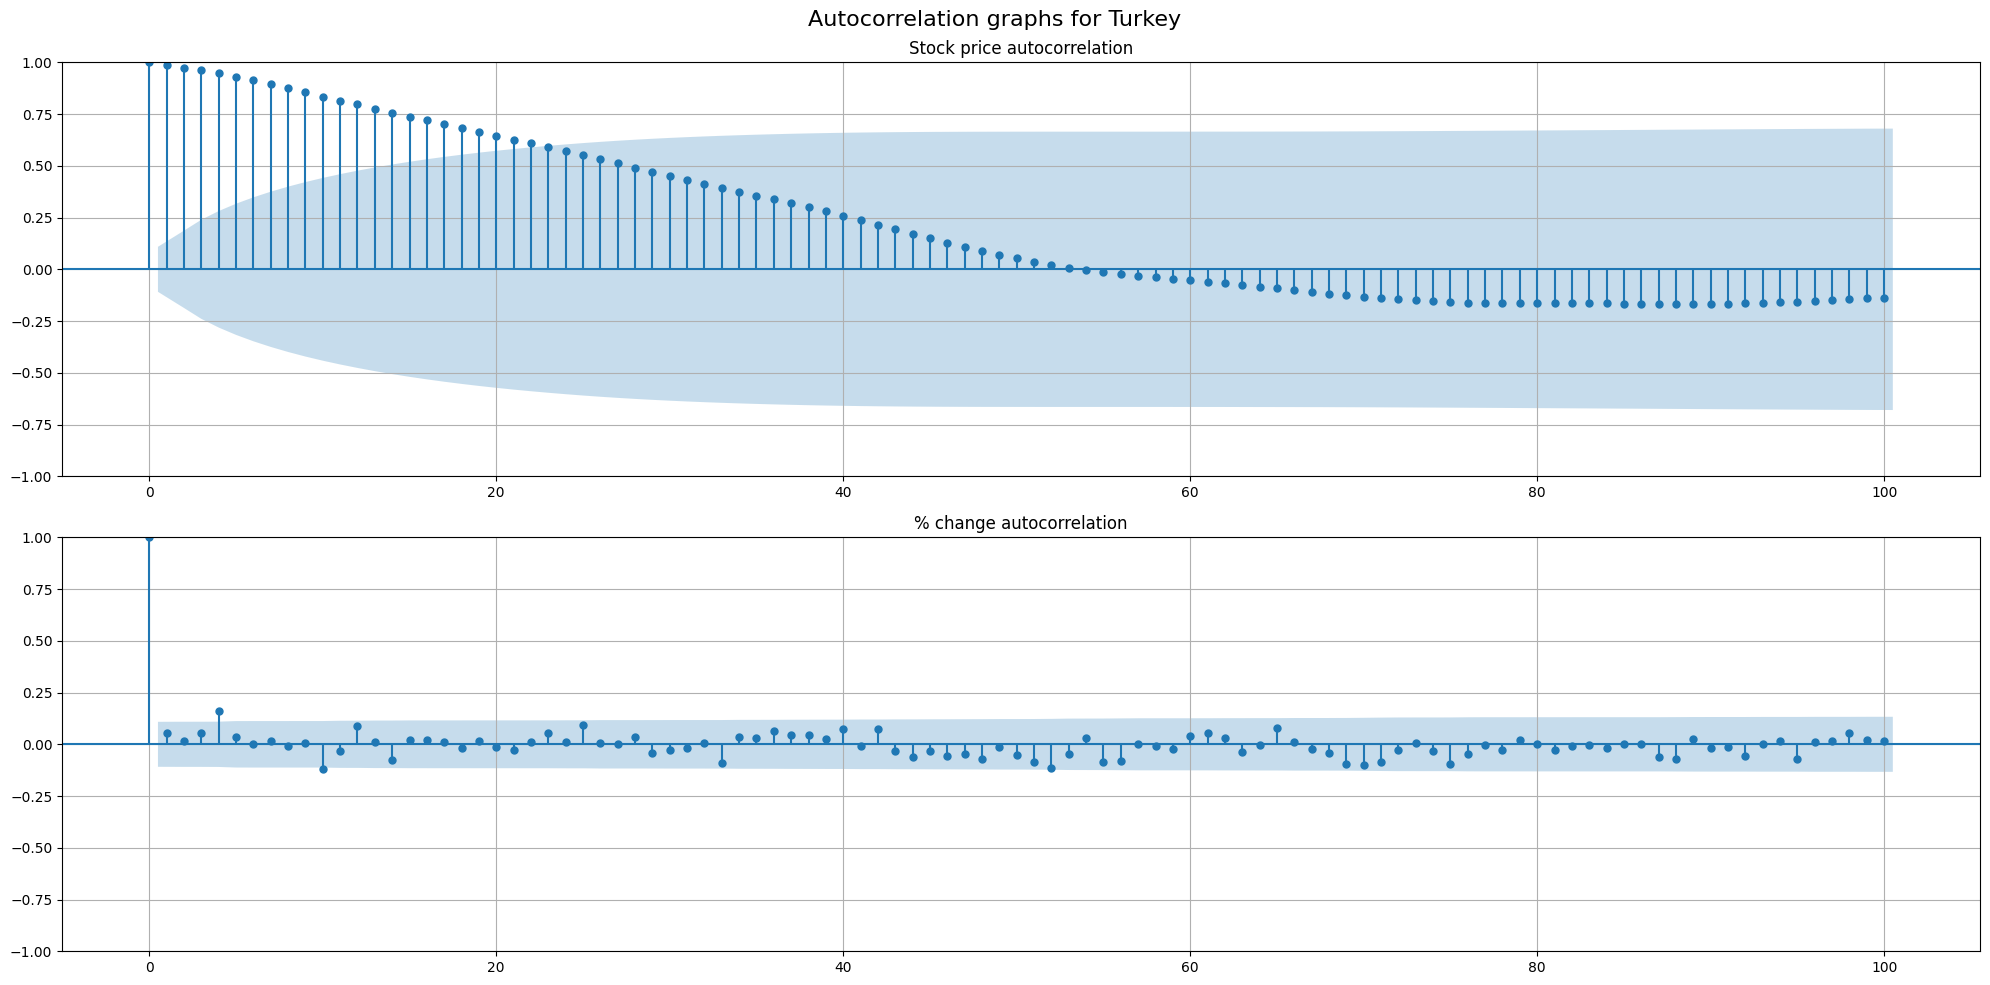

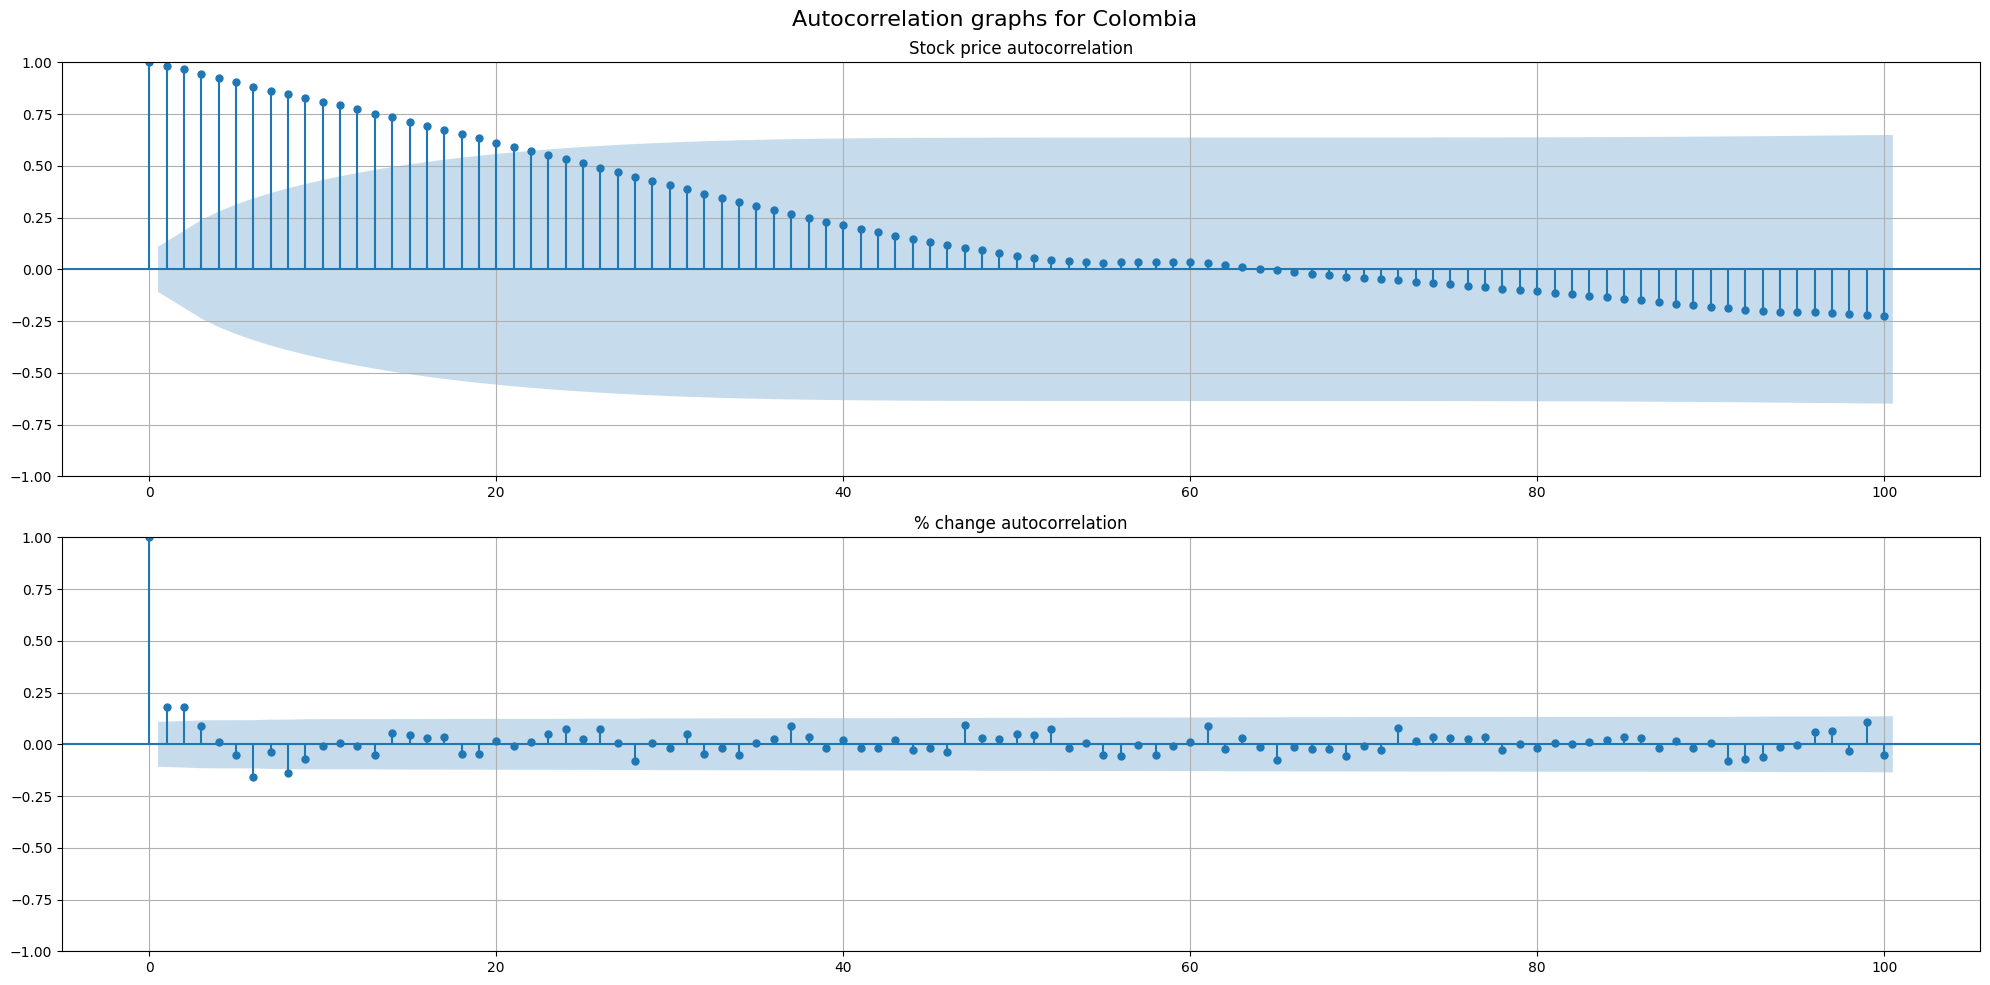

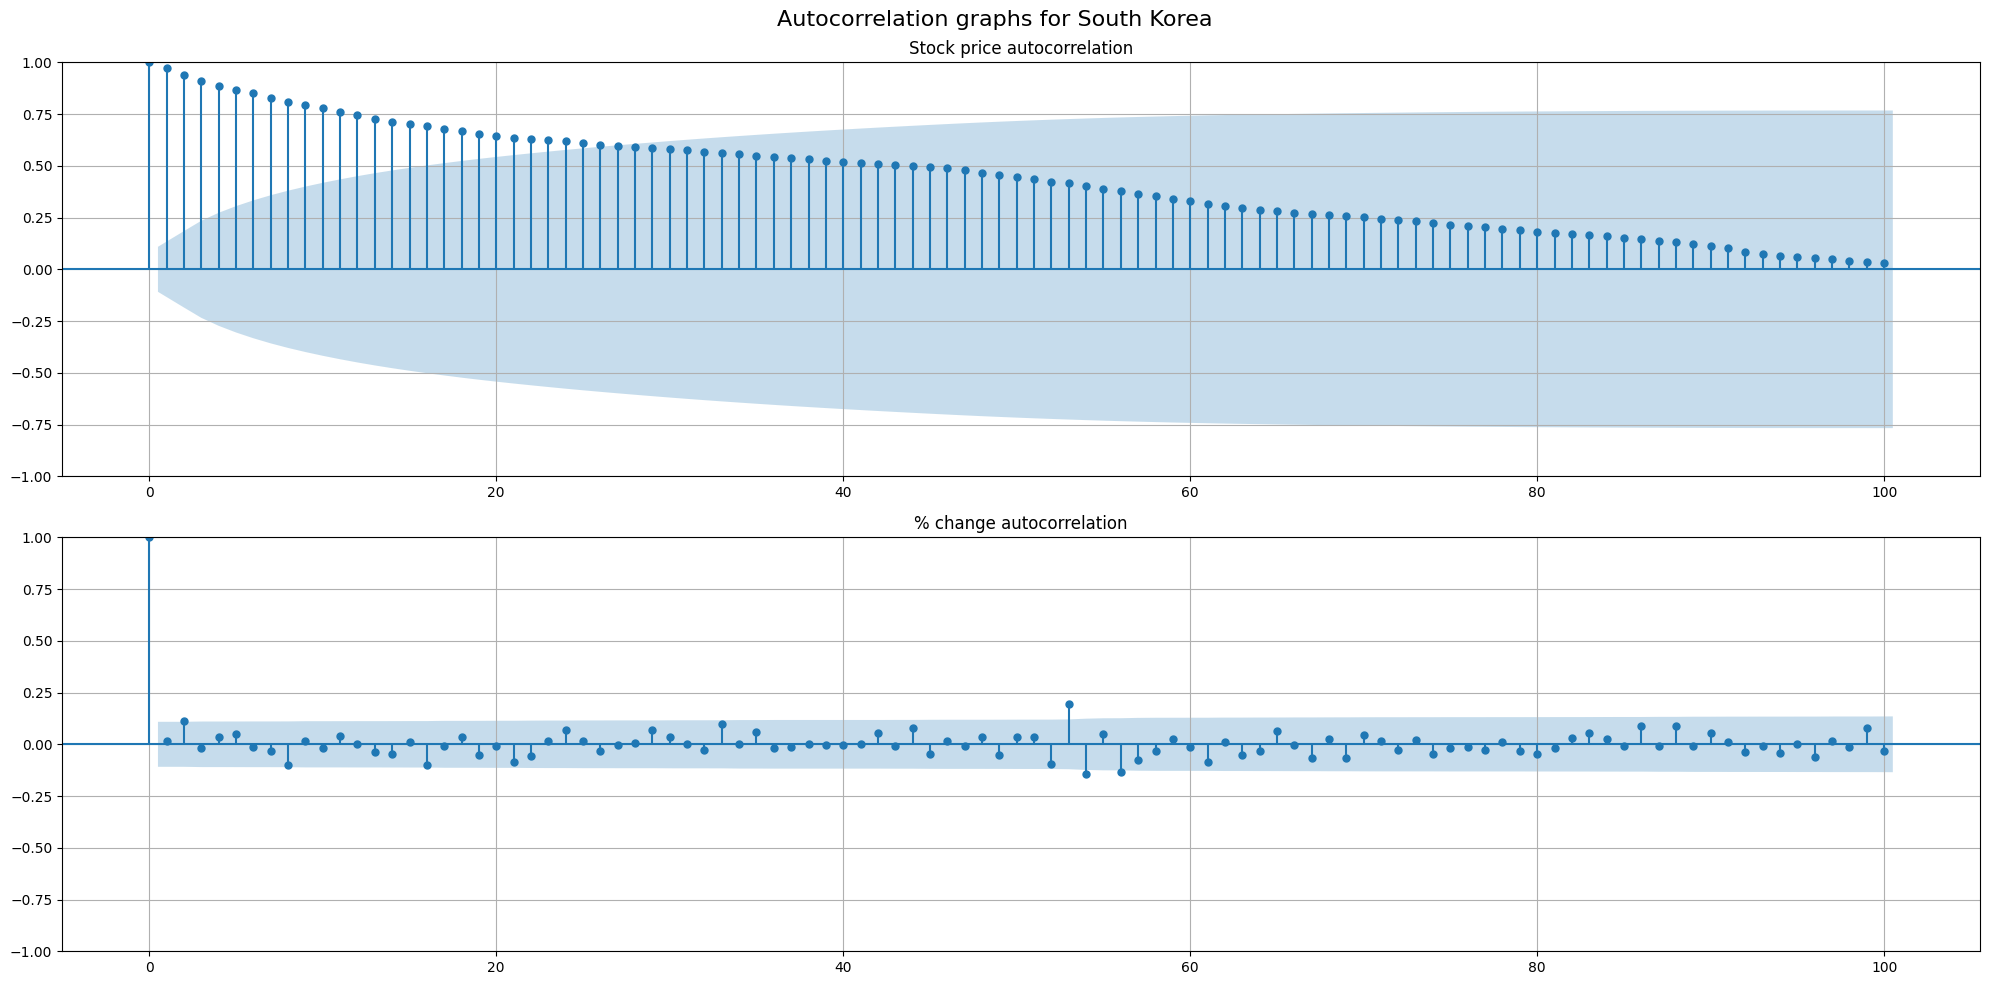

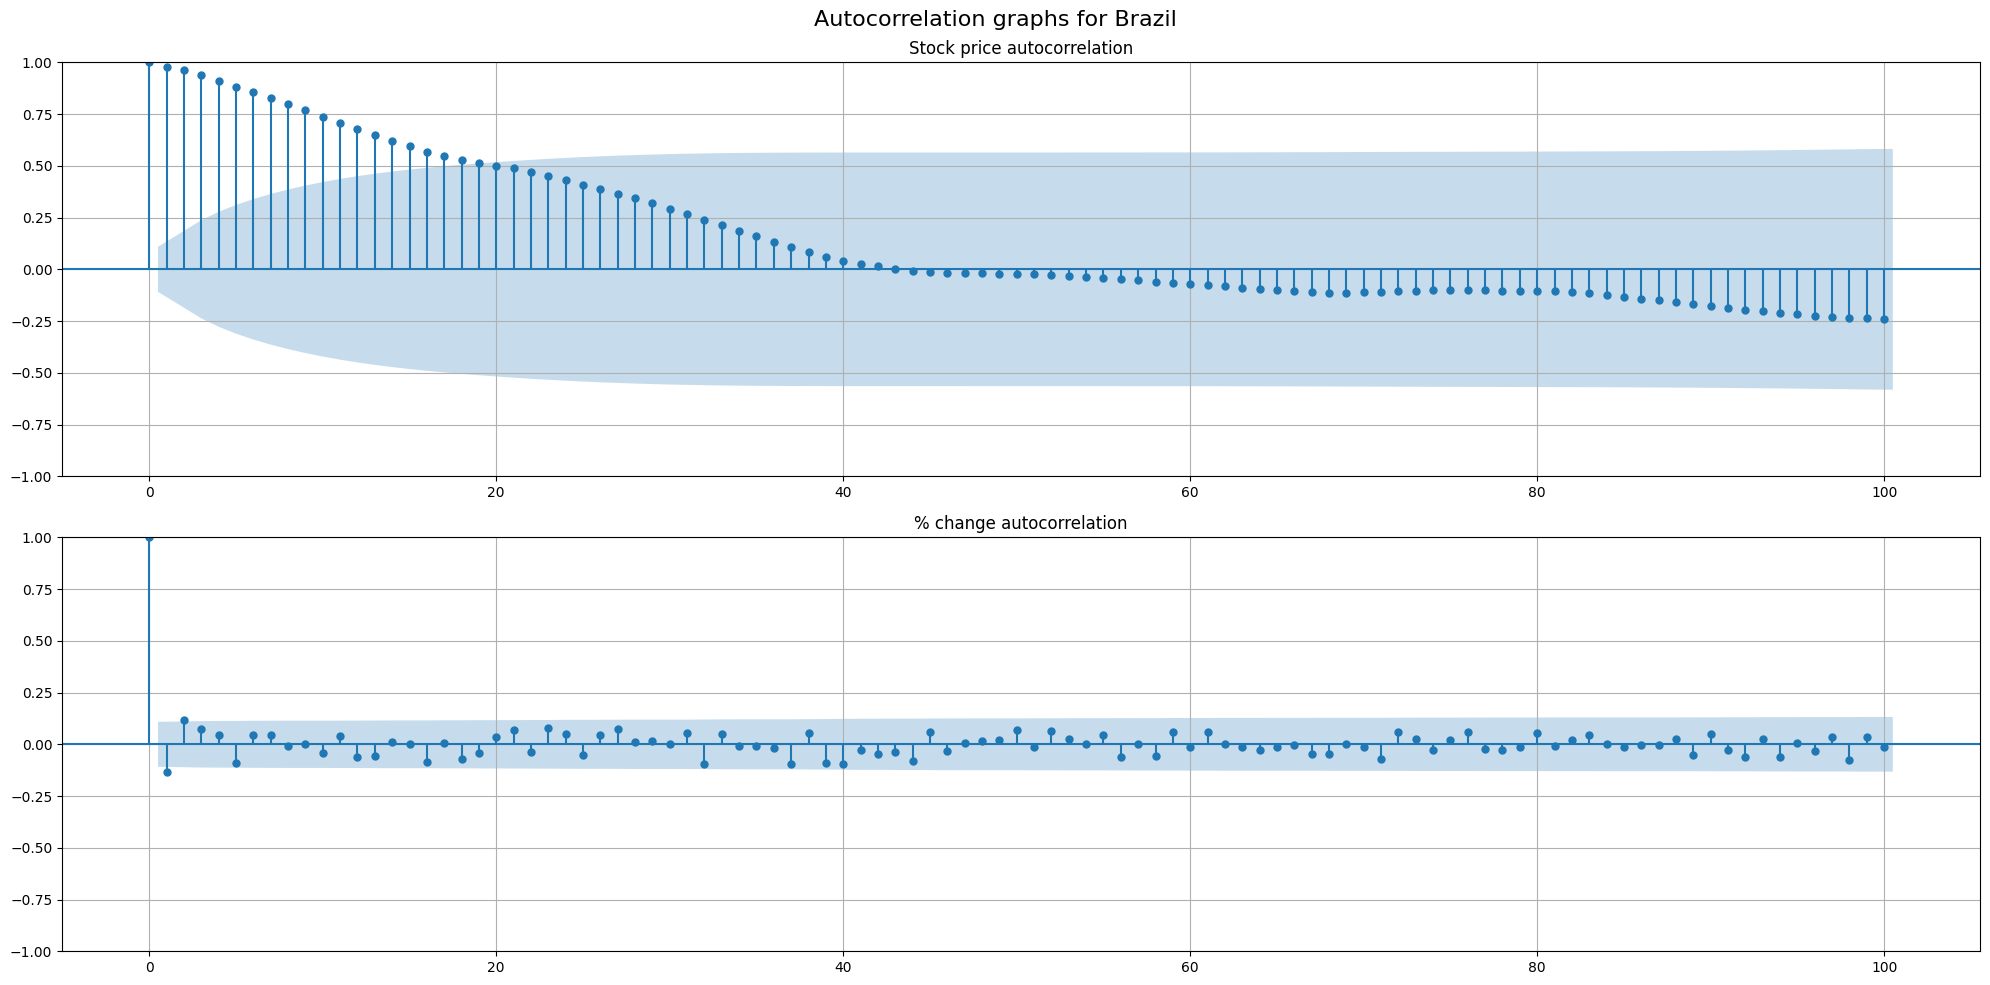

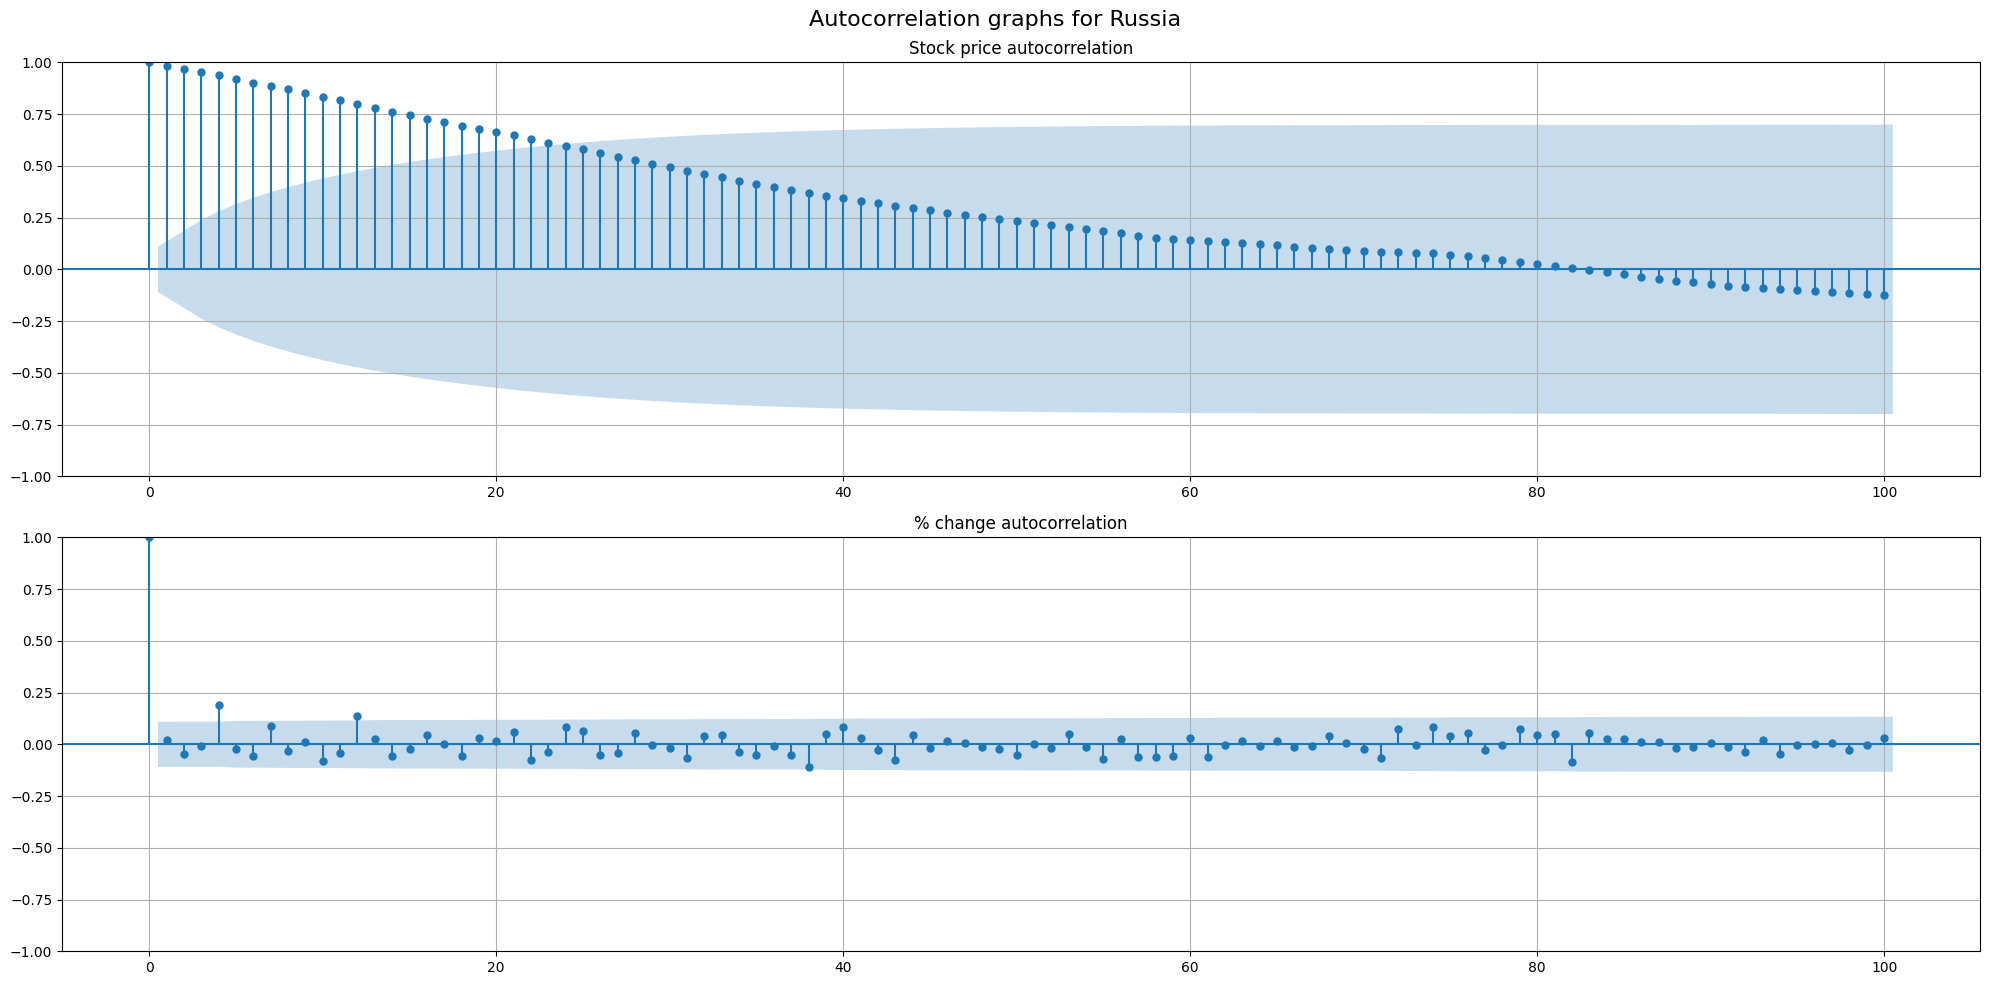

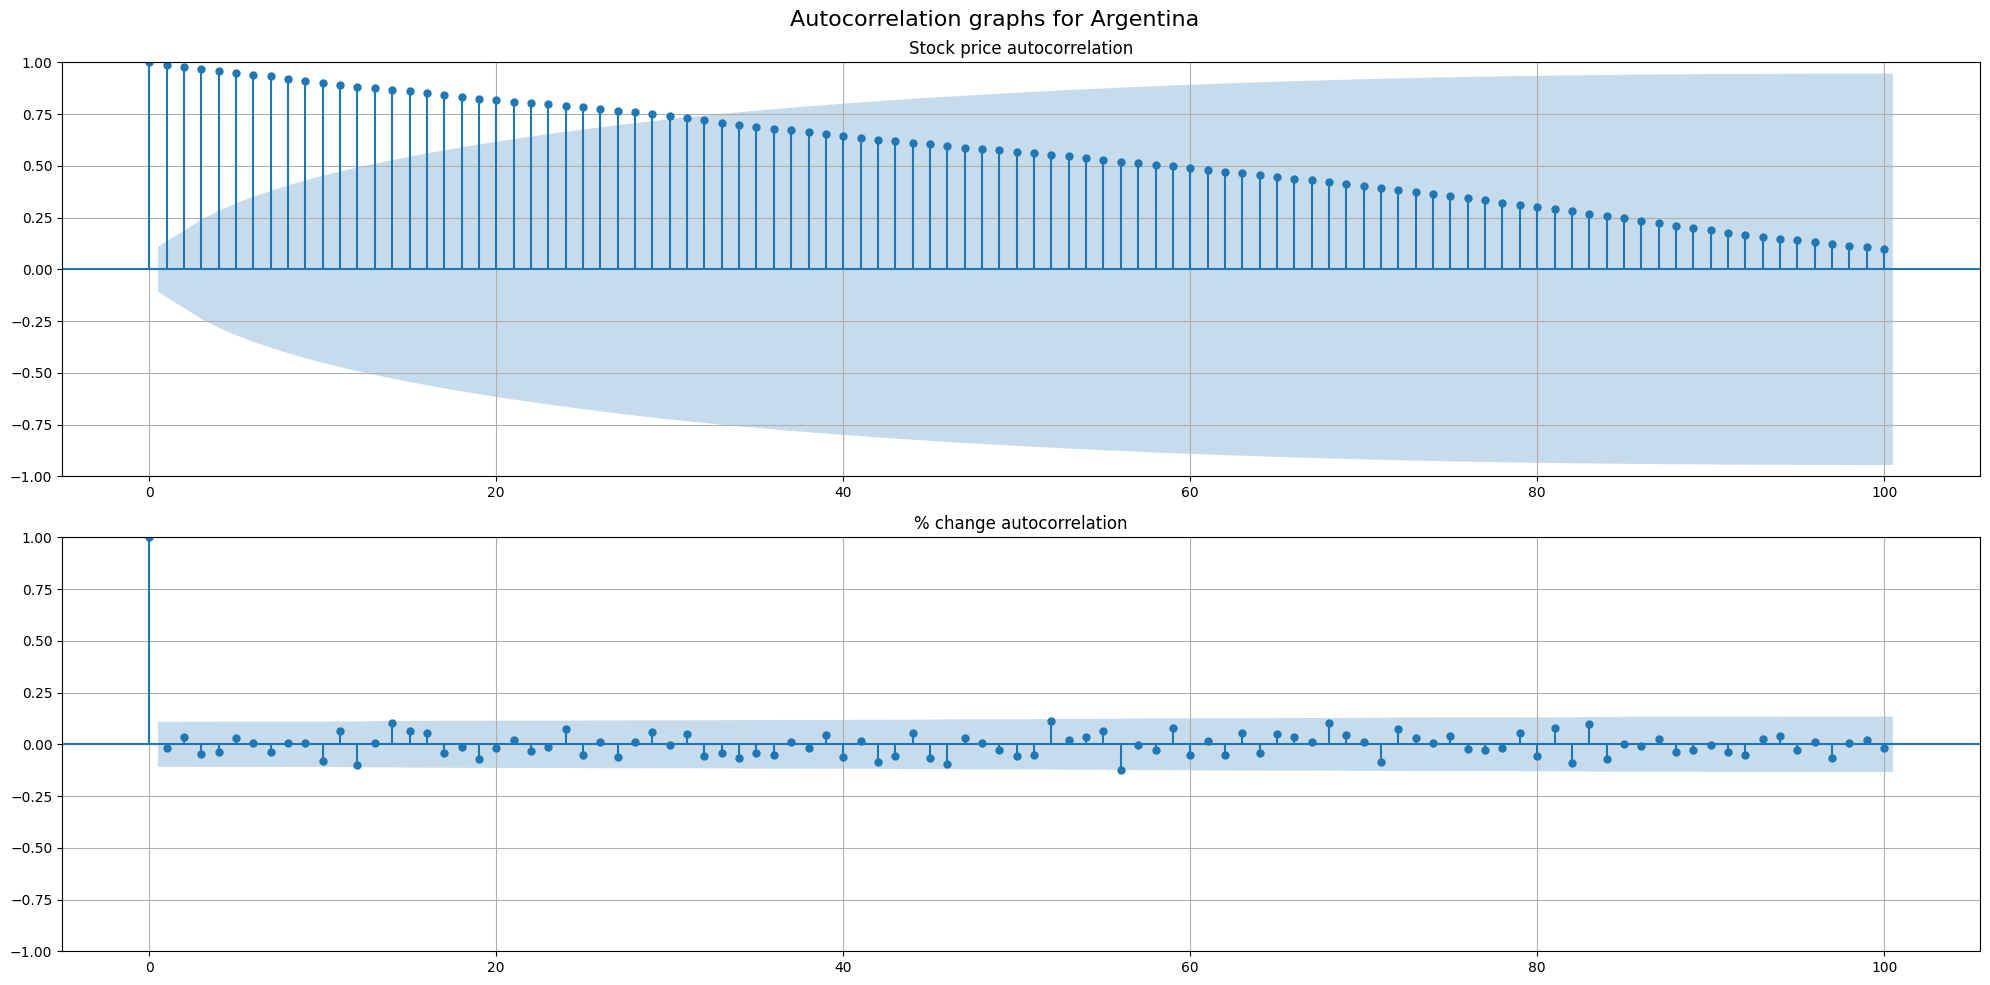

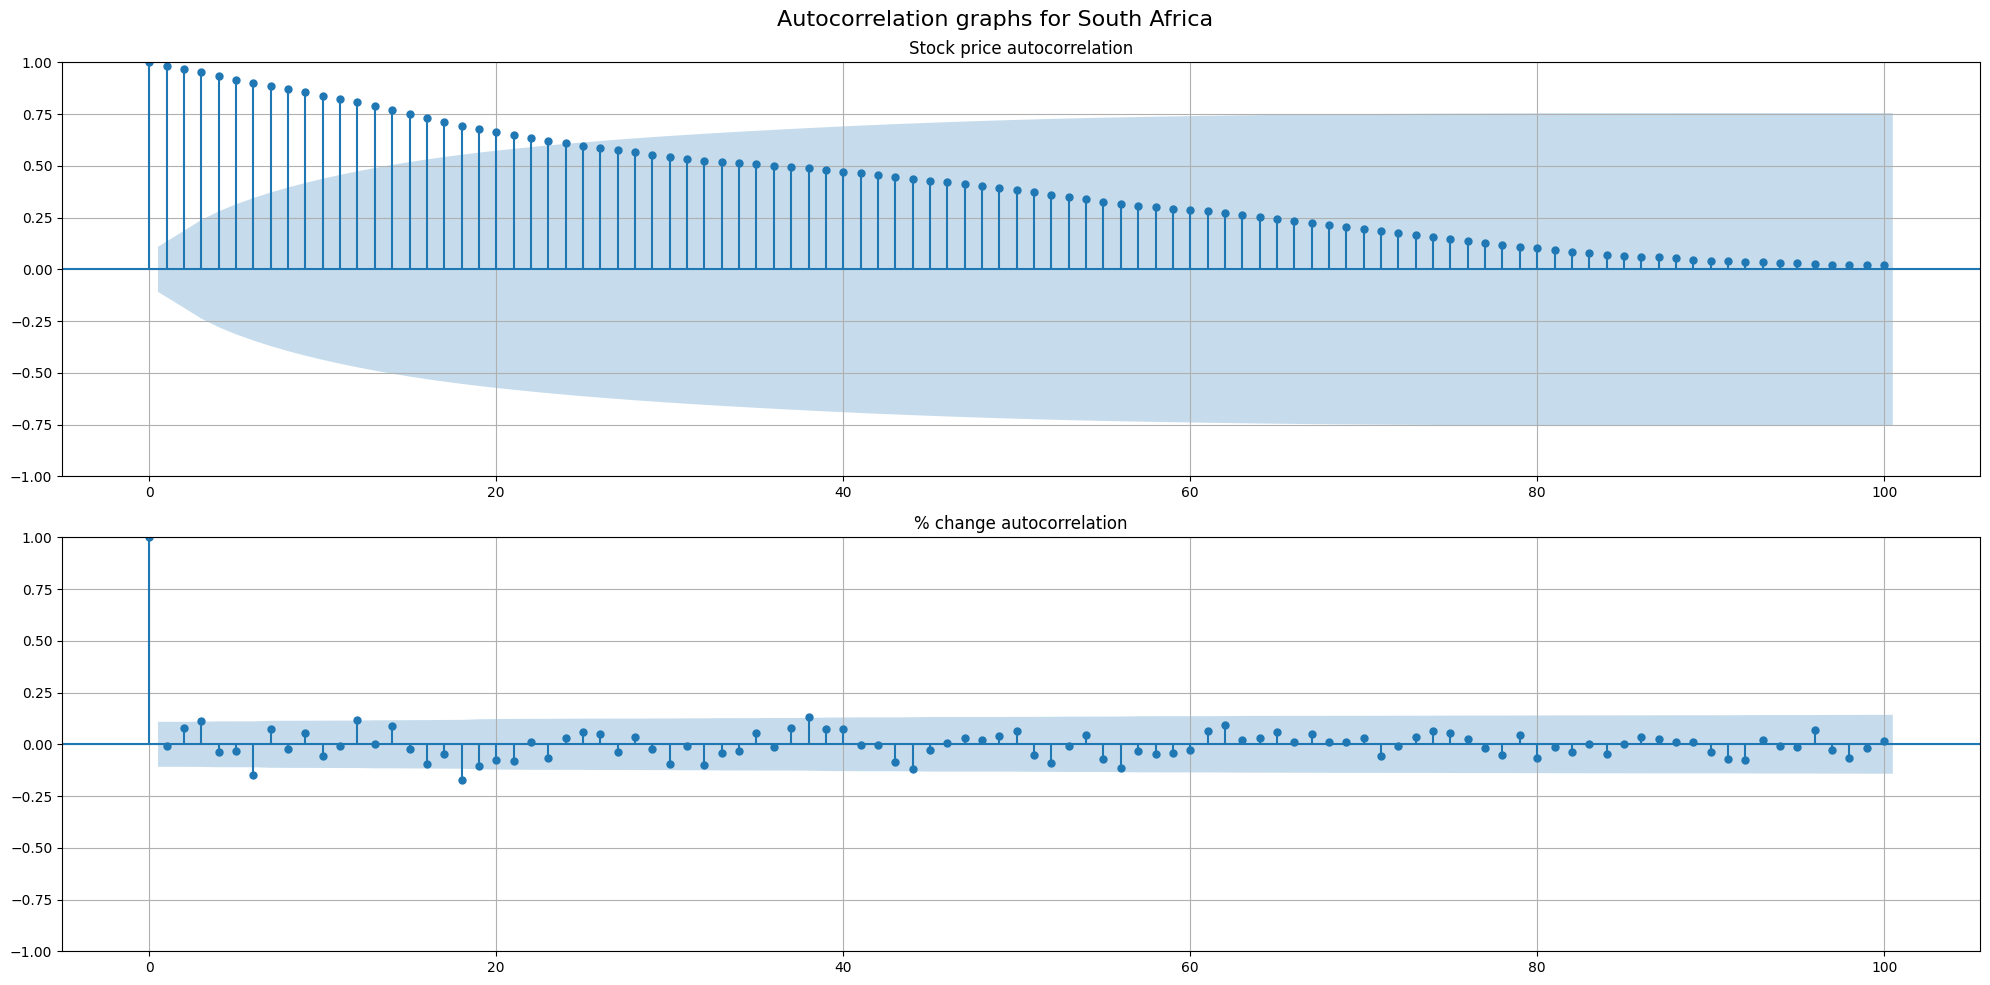

In [31]:
for key in data.keys():

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
  # Plot the price autocorrelation in subplot 1
  sm.graphics.tsa.plot_acf(data[key]['Price'], lags=100, ax=axes[0])
  axes[0].set_title('Stock price autocorrelation')
  axes[0].grid('on')

  # Plot the Change % in subplot 2
  sm.graphics.tsa.plot_acf(data[key]['Change %'], lags=100, ax=axes[1])
  axes[1].set_title('% change autocorrelation')
  axes[1].grid('on')

  # set the figure title
  fig.suptitle(f'Autocorrelation graphs for {key}', fontsize=16)

  plt.tight_layout()
  plt.show()

we observe **strong correlation** at low lags for the Price time series. This is due to the trend in the data.

On the other hand, the Change % show **low correlation** at any lags, with rare exceptions.

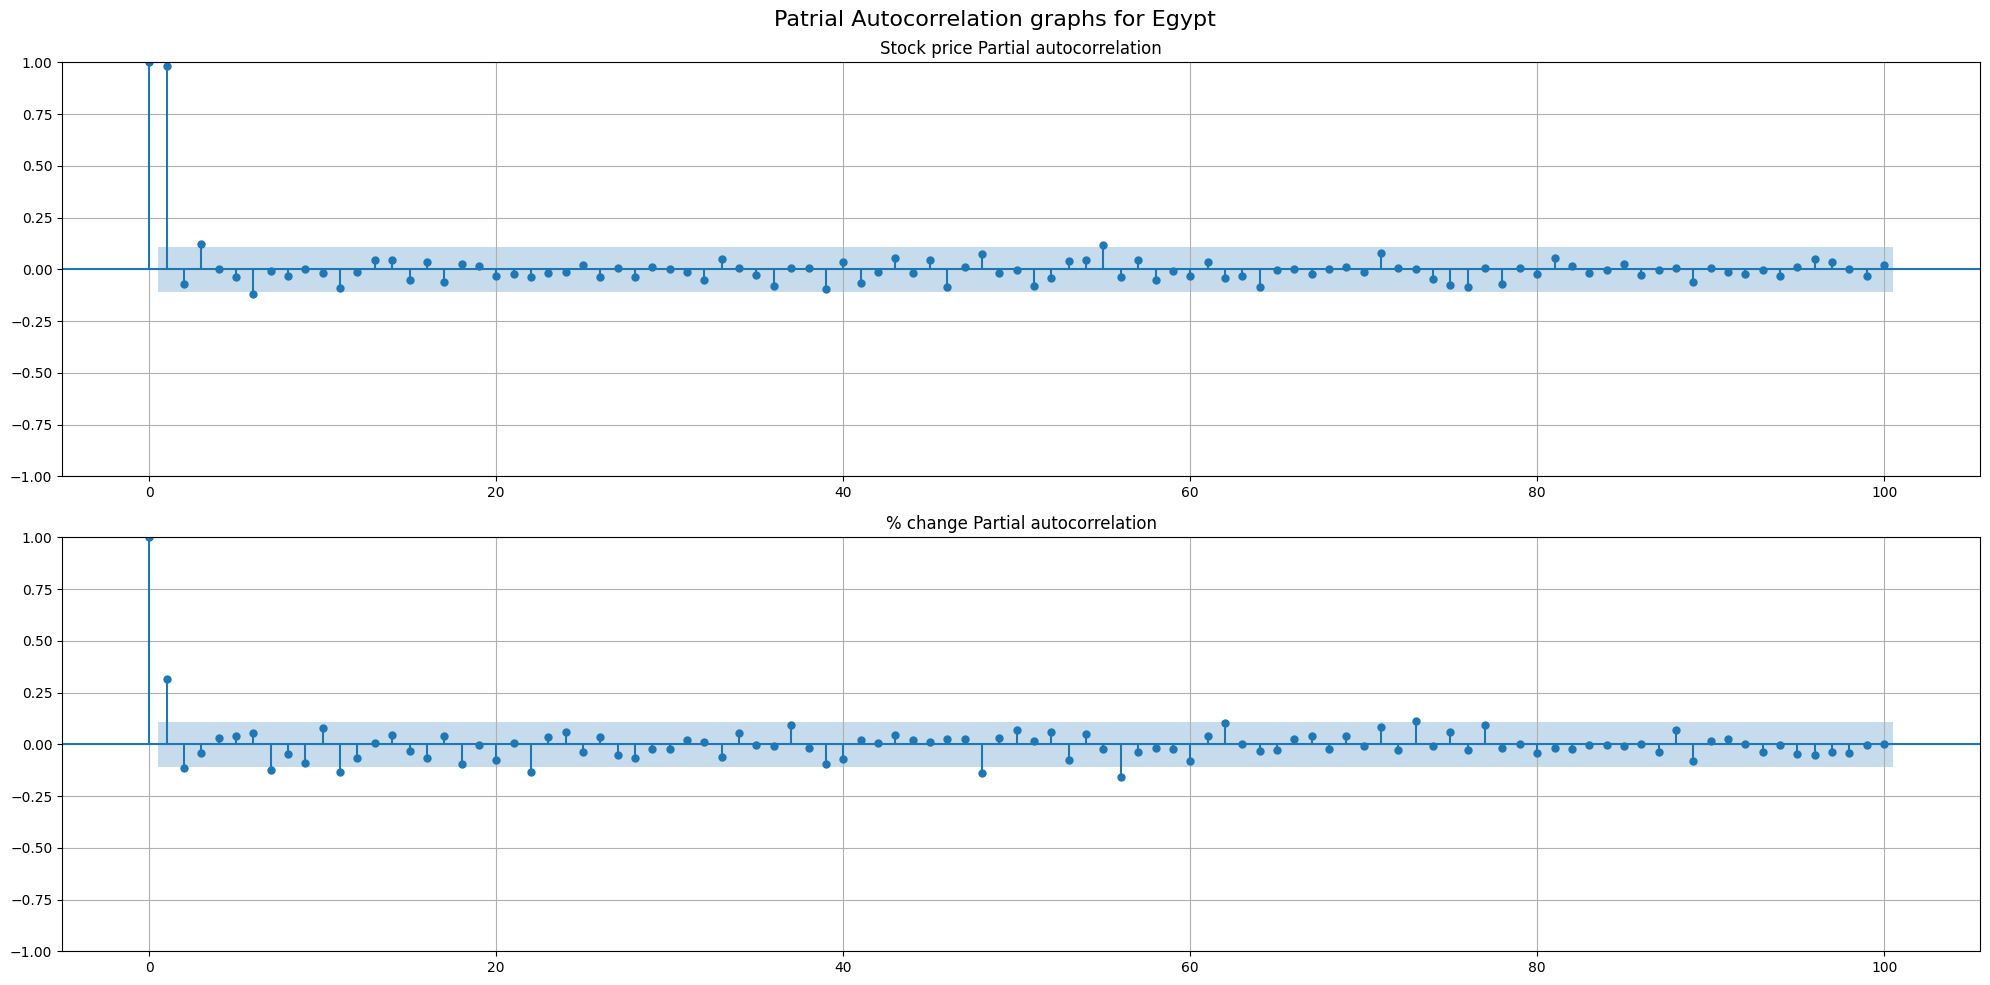

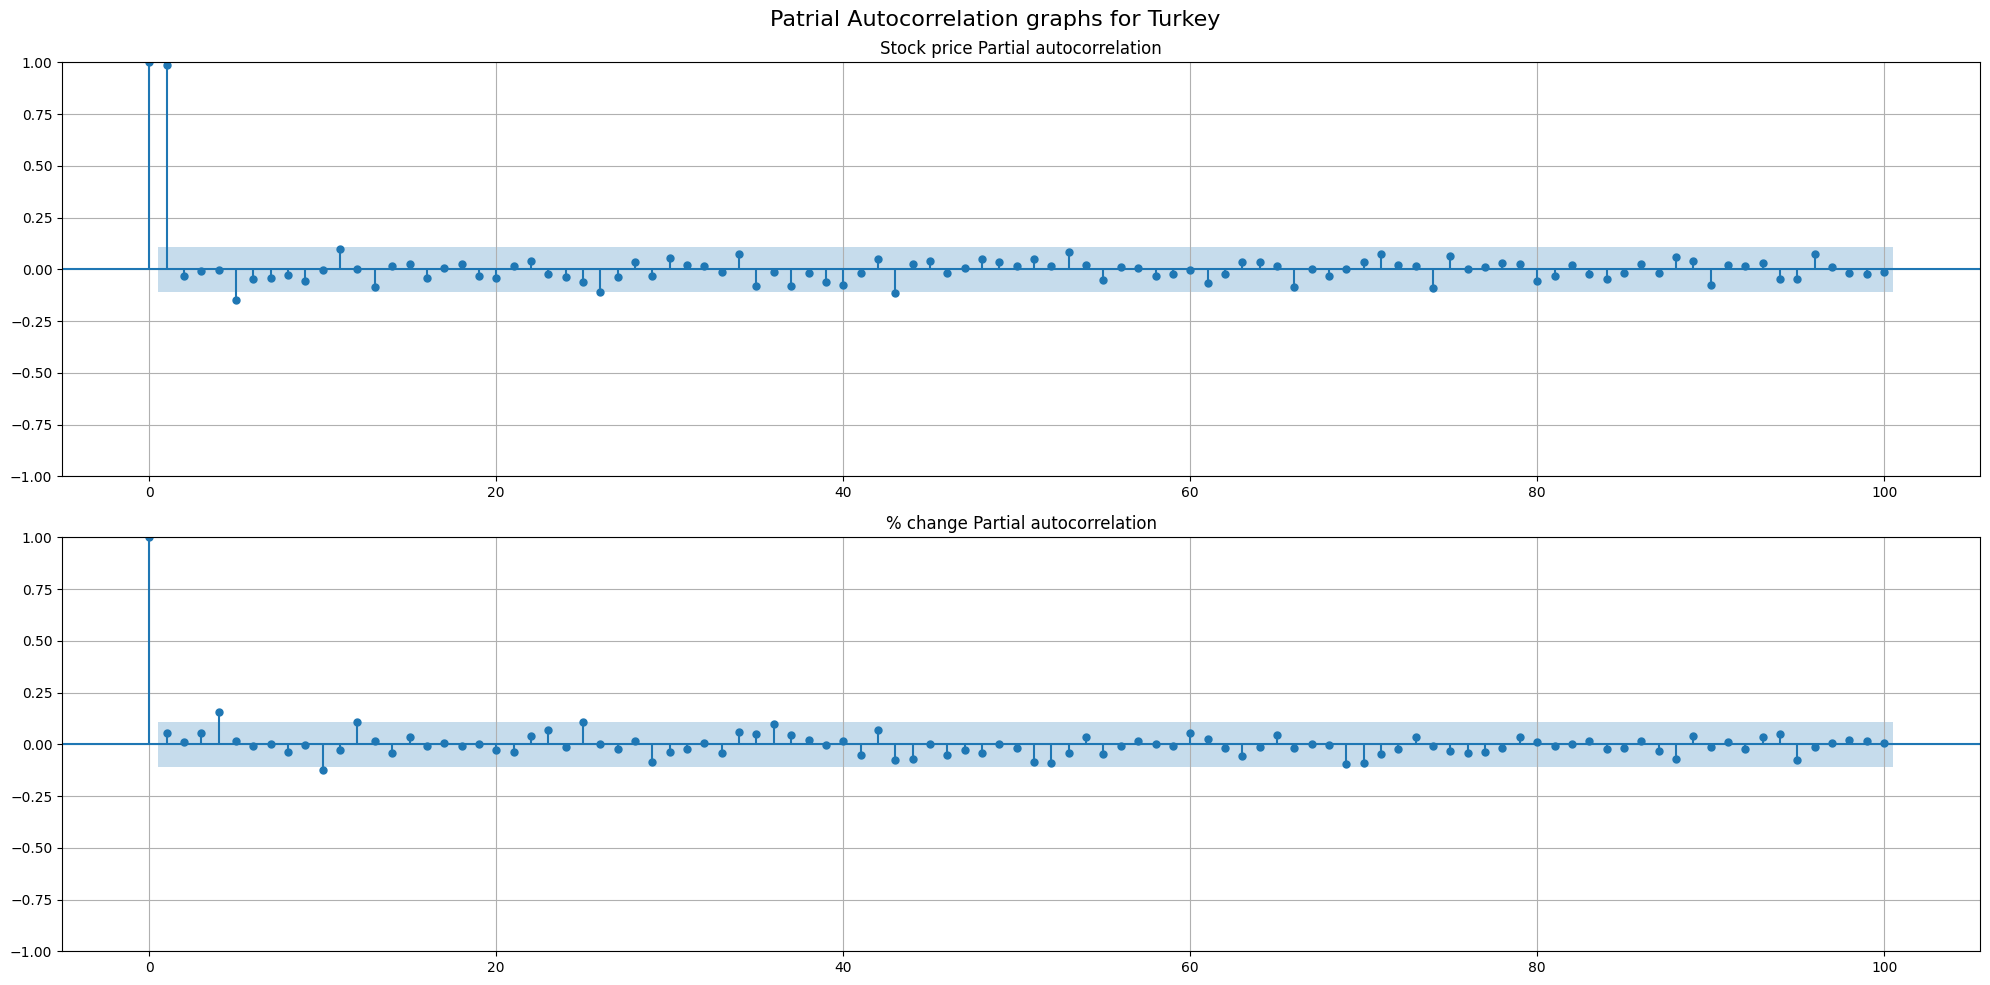

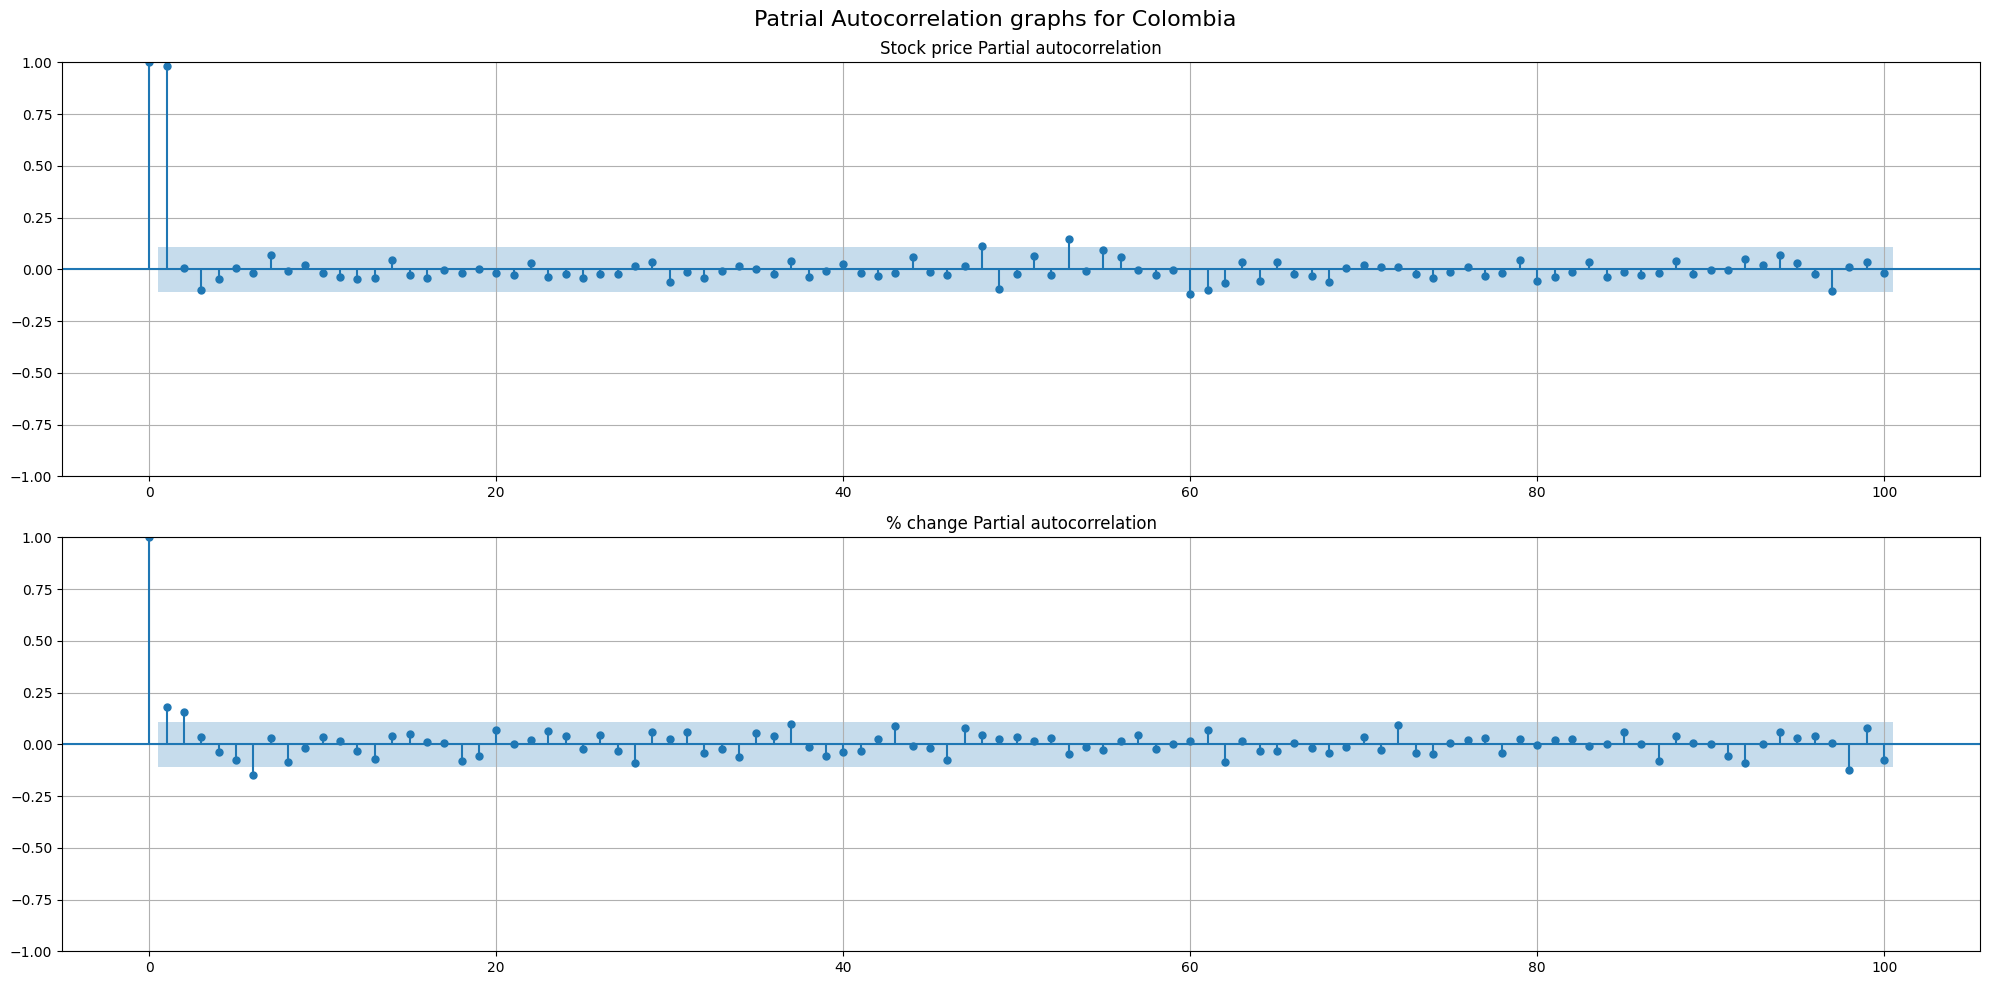

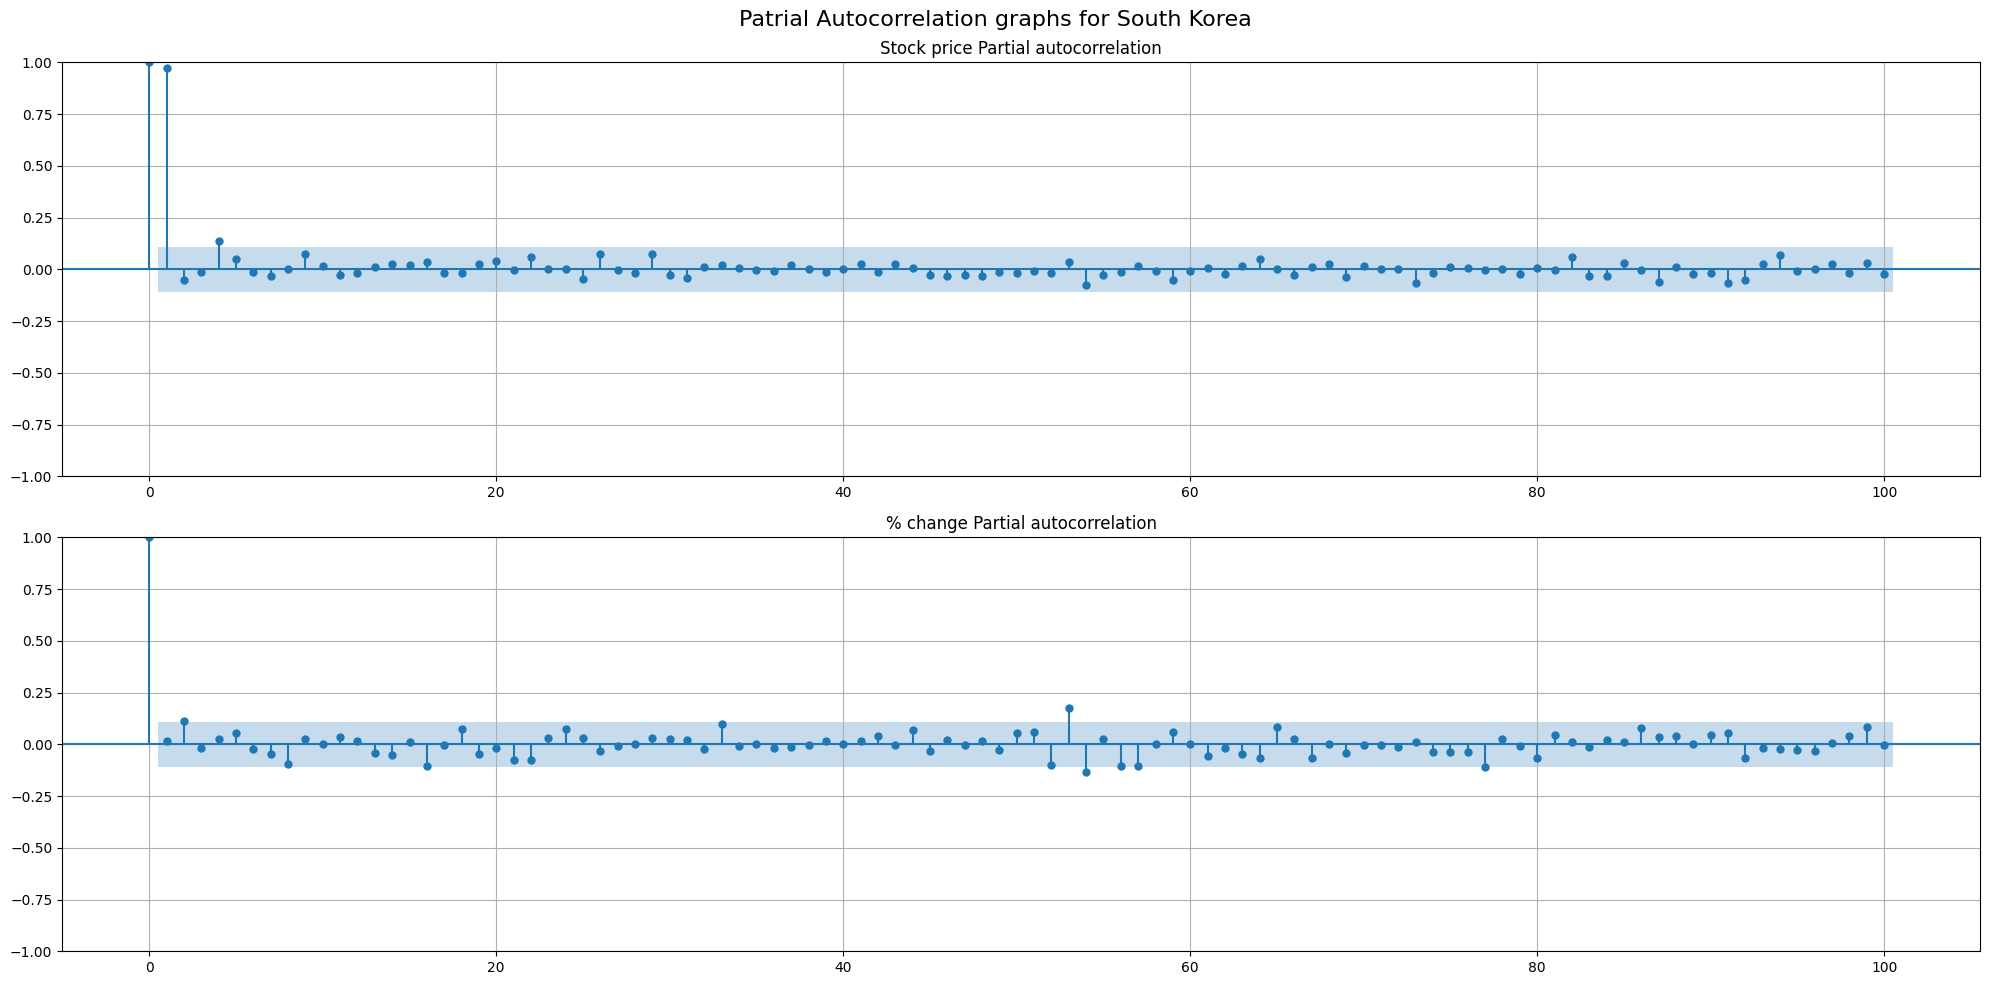

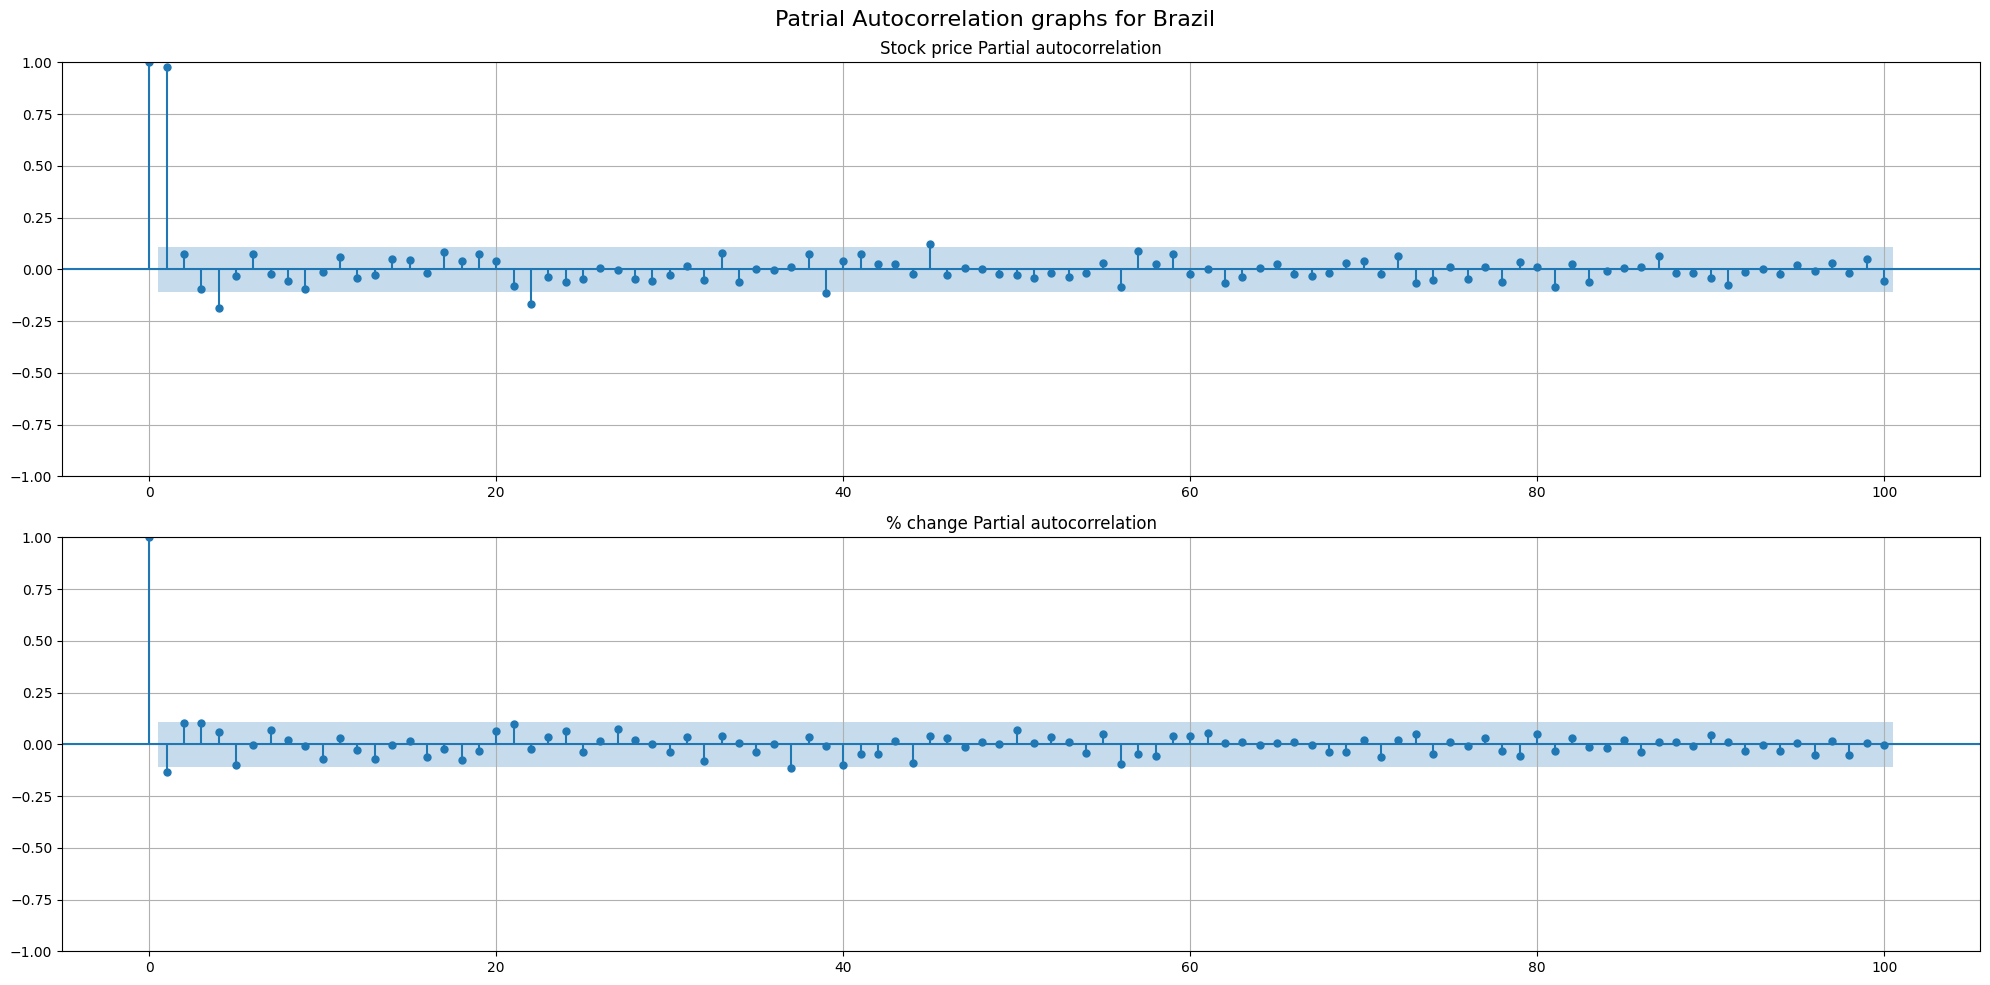

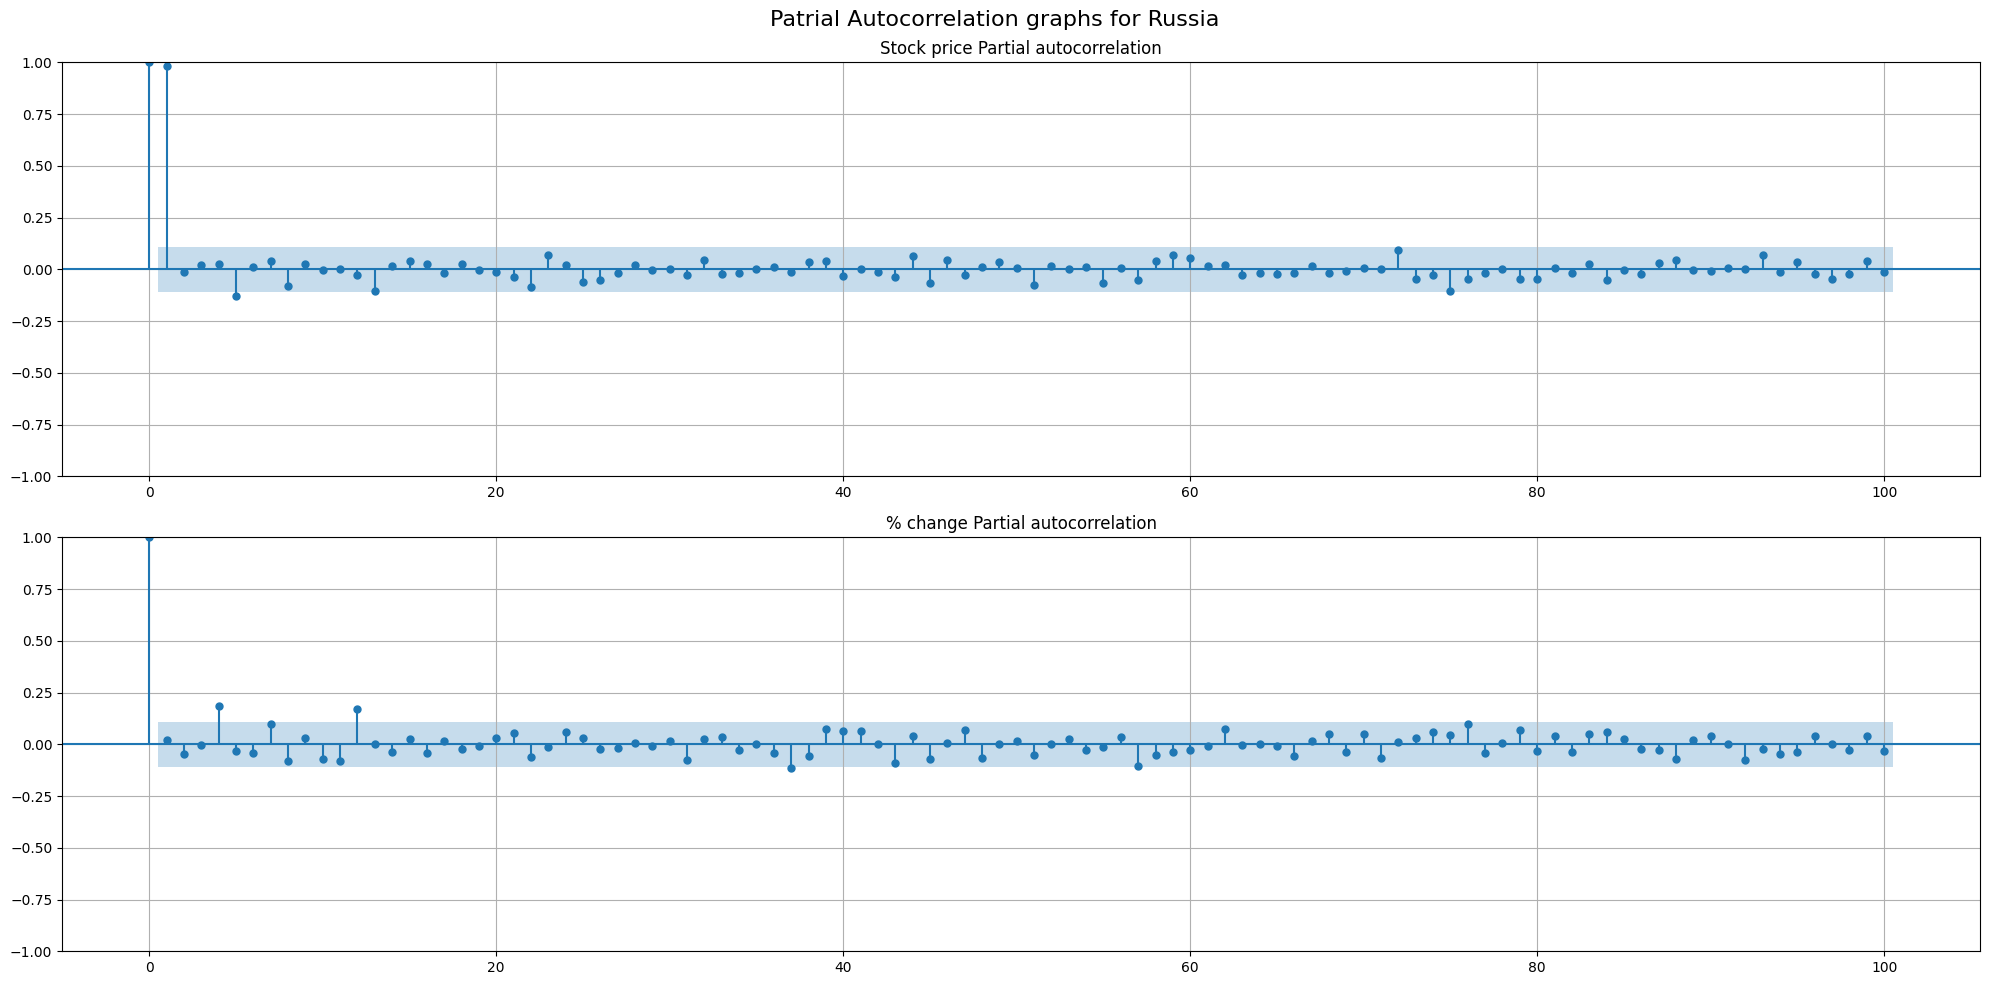

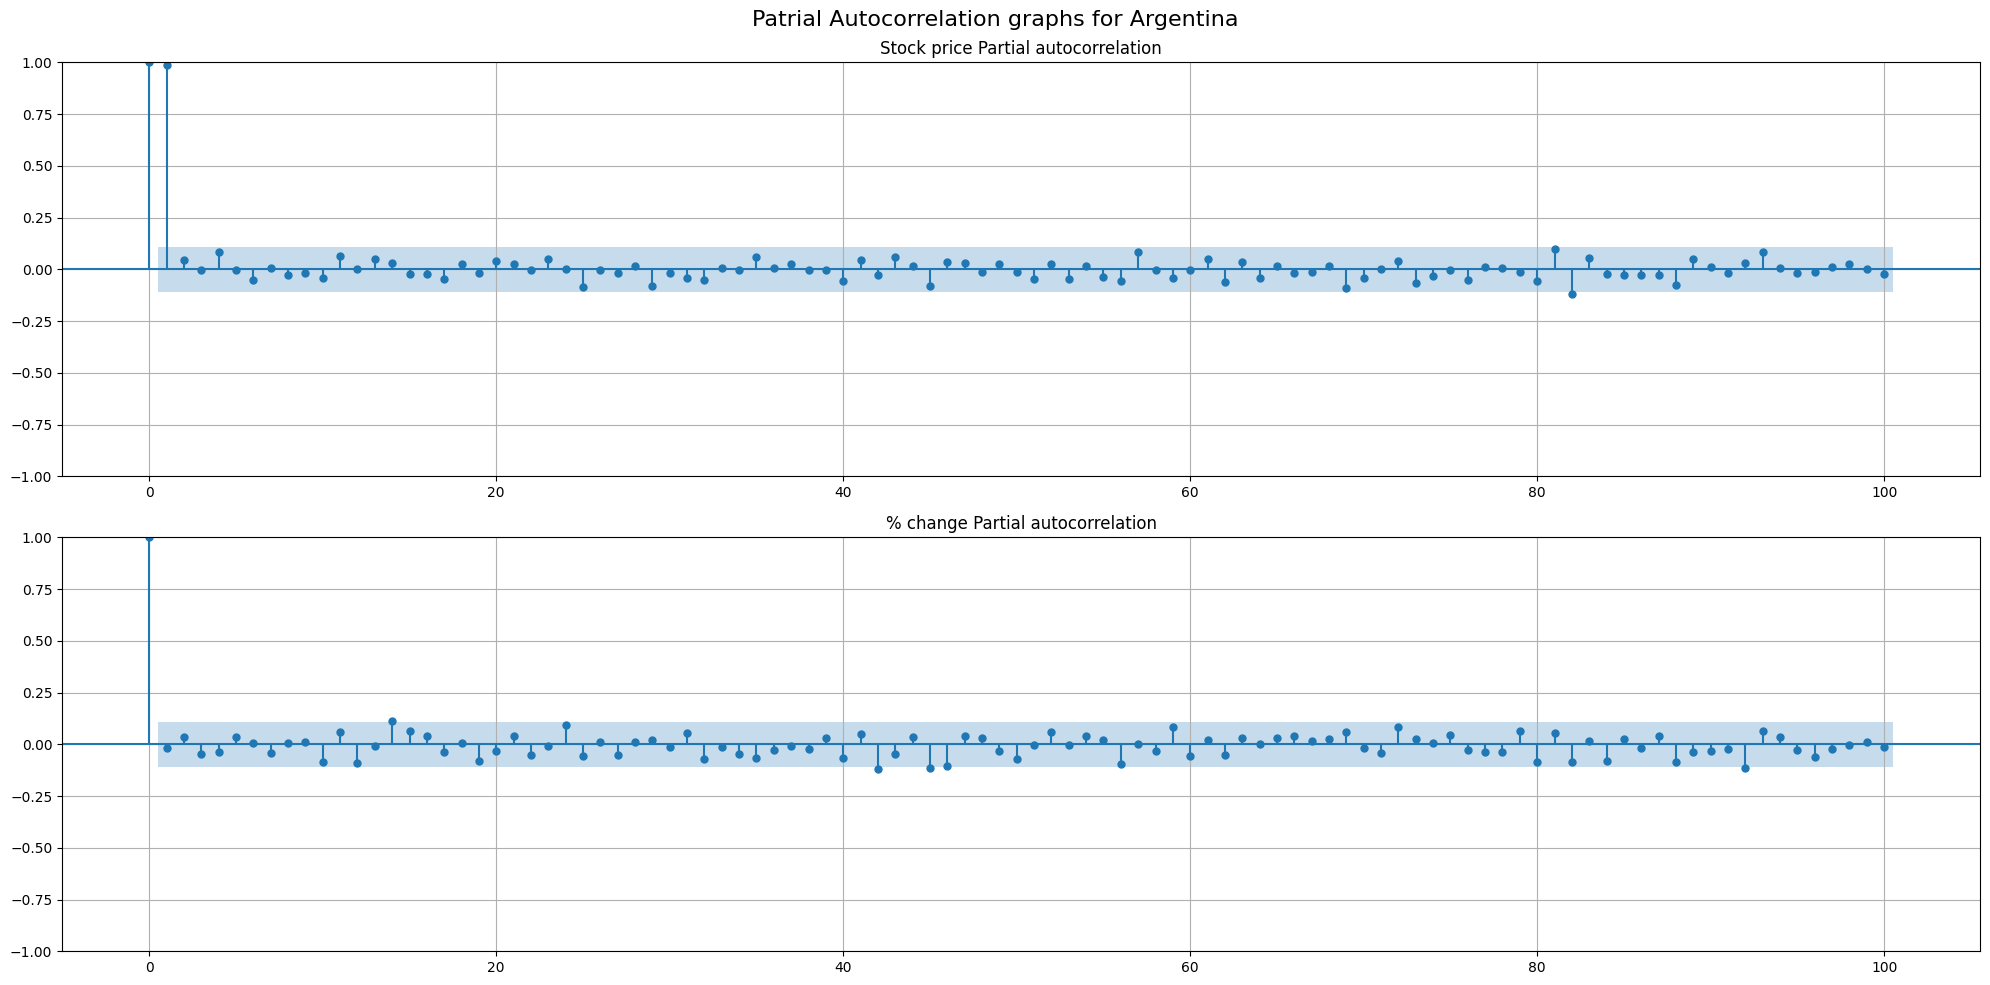

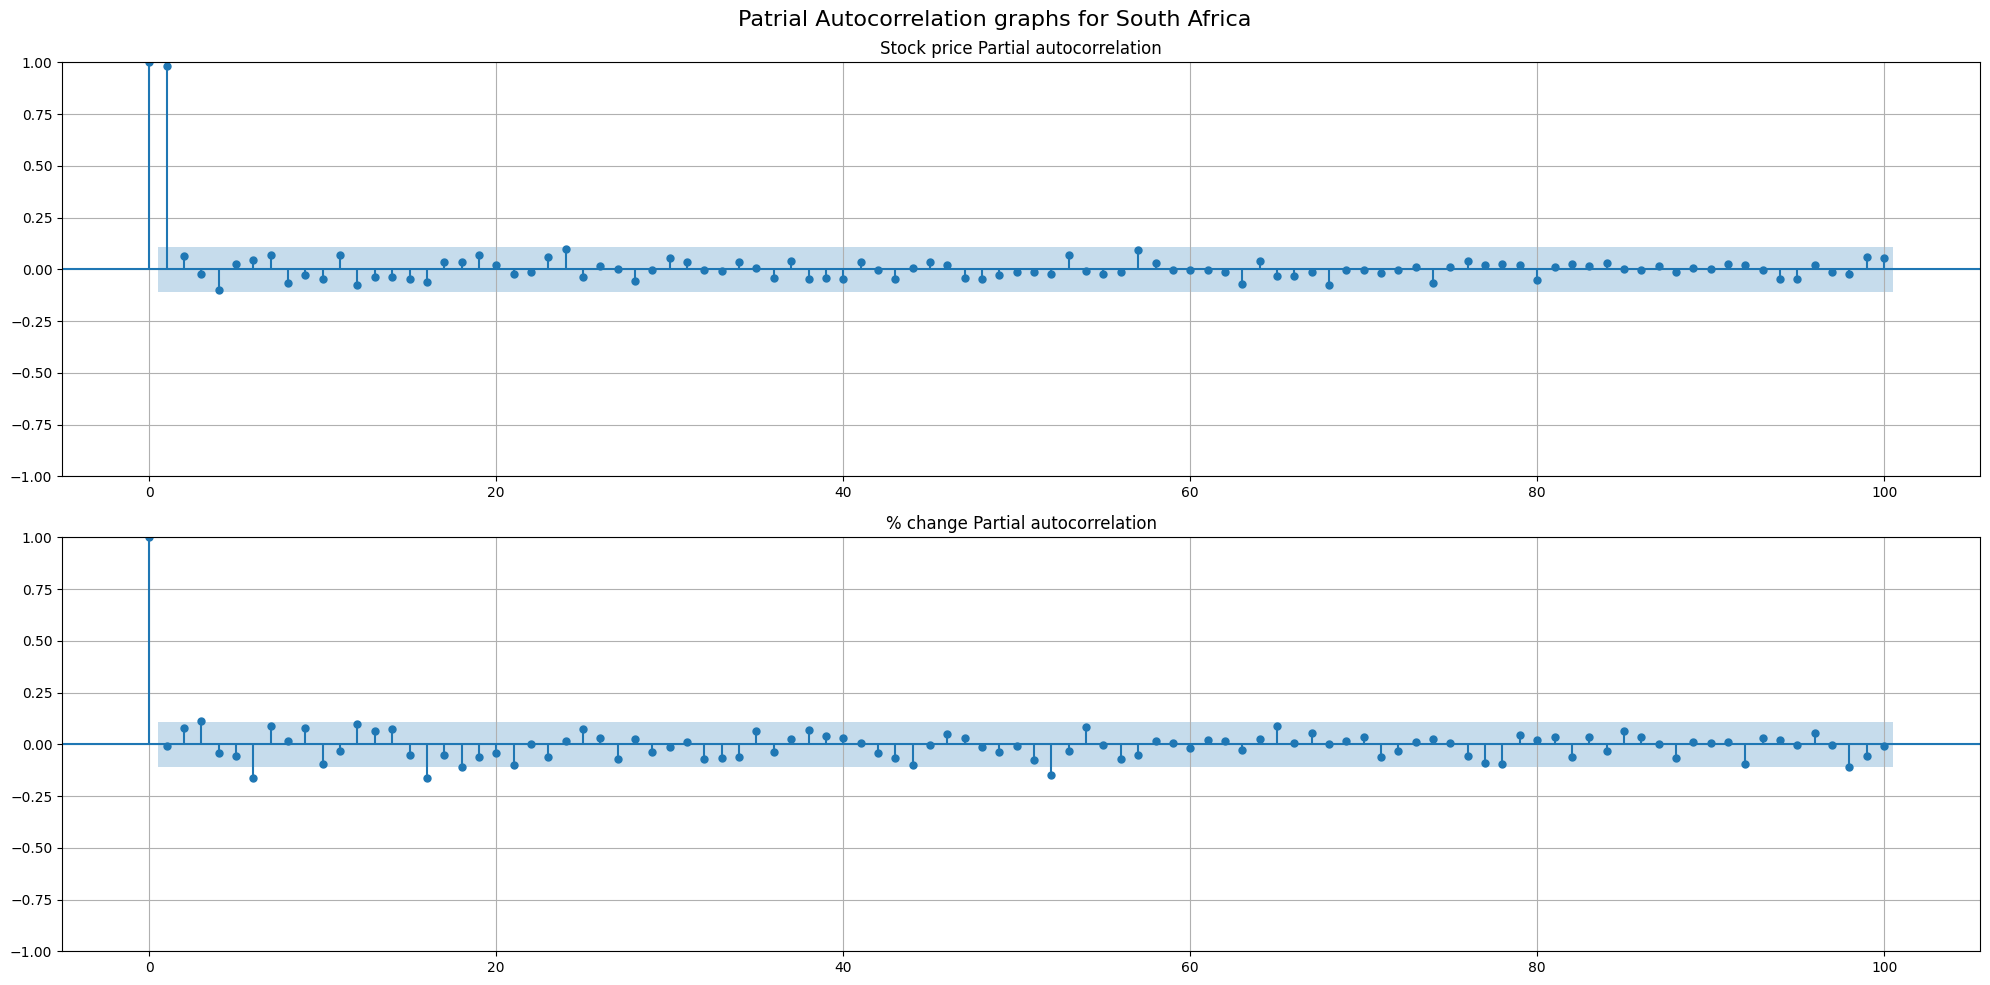

In [32]:
for key in data.keys():

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
  # Plot the price autocorrelation in subplot 1
  sm.graphics.tsa.plot_pacf(data[key]['Price'], lags=100, ax=axes[0])
  axes[0].set_title('Stock price Partial autocorrelation')
  axes[0].grid('on')

  # Plot the Change % in subplot 2
  sm.graphics.tsa.plot_pacf(data[key]['Change %'], lags=100, ax=axes[1])
  axes[1].set_title('% change Partial autocorrelation')
  axes[1].grid('on')

  # set the figure title
  fig.suptitle(f'Patrial Autocorrelation graphs for {key}', fontsize=16)

  plt.tight_layout()
  plt.show()

Every price time series show a **very strong** partial autocorrelation at lag 1, and immediately after it drops.

This is expected, given the highly unpredictable nature of the stock market: the last day price influence the current price - but all the others have little to no influence

On the other hand, the Change % time series show some relevant partial autocorrelation values at higher lags.



# EDA - Exogenous variables correlation

Note that at any point, we know the current value of the Price and the exogenous variables, and we want to use them to predict the nexet price value.

Hence, we need to **shift** in time the exogenous variables:
in this way we correctly model the fact that we use today's values to predict tomorrow's price.

In [15]:
for key in data.keys():
  print(f'Correlation between the {key} stock Price and the other variables:')
  for col in data[key].columns.values[1:]:
    corr = data[key]['Price'].corr(data[key][col].shift(1))
    print(f'{col}: {corr}')
  print('\n######################\n')

Correlation between the Russia stock Price and the other variables:
Open: 0.9809088576545428
High: 0.9852199121795492
Low: 0.9851143089110174
Vol.: -0.2358531529111713
Change %: 0.09596871379850075

######################

Correlation between the Argentina stock Price and the other variables:
Open: 0.9863660101139097
High: 0.9908227623538967
Low: 0.9903509494261258
Vol.: -0.34575962349162515
Change %: 0.048059519203862706

######################

Correlation between the Turkey stock Price and the other variables:
Open: 0.9790574497724749
High: 0.9838533800087476
Low: 0.9858845344692216
Vol.: -0.01687524913206735
Change %: 0.07471443461323936

######################

Correlation between the South Africa stock Price and the other variables:
Open: 0.984024382219968
High: 0.9875232365117926
Low: 0.9889949522763058
Vol.: -0.4066784696789787
Change %: 0.0578352013221661

######################

Correlation between the Colombia stock Price and the other variables:
Open: 0.9798419379011856
Hig

We notice that there is **very high correlation** between today's price and yesterday Open, High and Low (as expected).

On the other hand, the Volume and the Change % have very little correlation with the Price.

# AutoARIMA - Price

In [46]:
price_trained_models = {}
train_end = datetime(2020,12,31)

for key in data.keys():

  train_data = data[key]['Price'][:train_end]
  model = auto_arima(train_data)

  print(f'############################################################################\n\n{key.upper()}\n')
  print(model.summary())
  print('\n\n')
  price_trained_models[key] = model

############################################################################

EGYPT

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 247.043
Date:                Fri, 15 Sep 2023   AIC                           -484.086
Time:                        16:10:48   BIC                           -466.283
Sample:                    01-02-2020   HQIC                          -476.929
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2748      0.108      2.540      0.011       0.063       0.487
ar.L2         -0.8075      0.093     -8.643   

We notice that all of the models computed by the autoARIMA are fairly simple:
the maximum lag considered is 3.

This was expected from the EDA

# AutoARIMA - Change %

In [42]:
change_trained_models = {}
train_end = datetime(2020,12,31)

for key in data.keys():

  train_data = data[key]['Change %'][:train_end]
  model = auto_arima(train_data)

  print(f'############################################################################\n\n{key.upper()}\n')
  print(model.summary())
  print('\n\n')
  change_trained_models[key] = model


############################################################################

EGYPT

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -577.776
Date:                Fri, 15 Sep 2023   AIC                           1167.551
Time:                        15:58:50   BIC                           1188.938
Sample:                    01-02-2020   HQIC                          1176.148
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4016      0.037     10.764      0.000       0.328       0.475
ar.L2         -0.9492      0.033    -28.684   

The computed models for the change % **do not have the integration** part.

This was expected, since we observed that the change % time series were stationary around 0

# AutoARIMA - price predictions

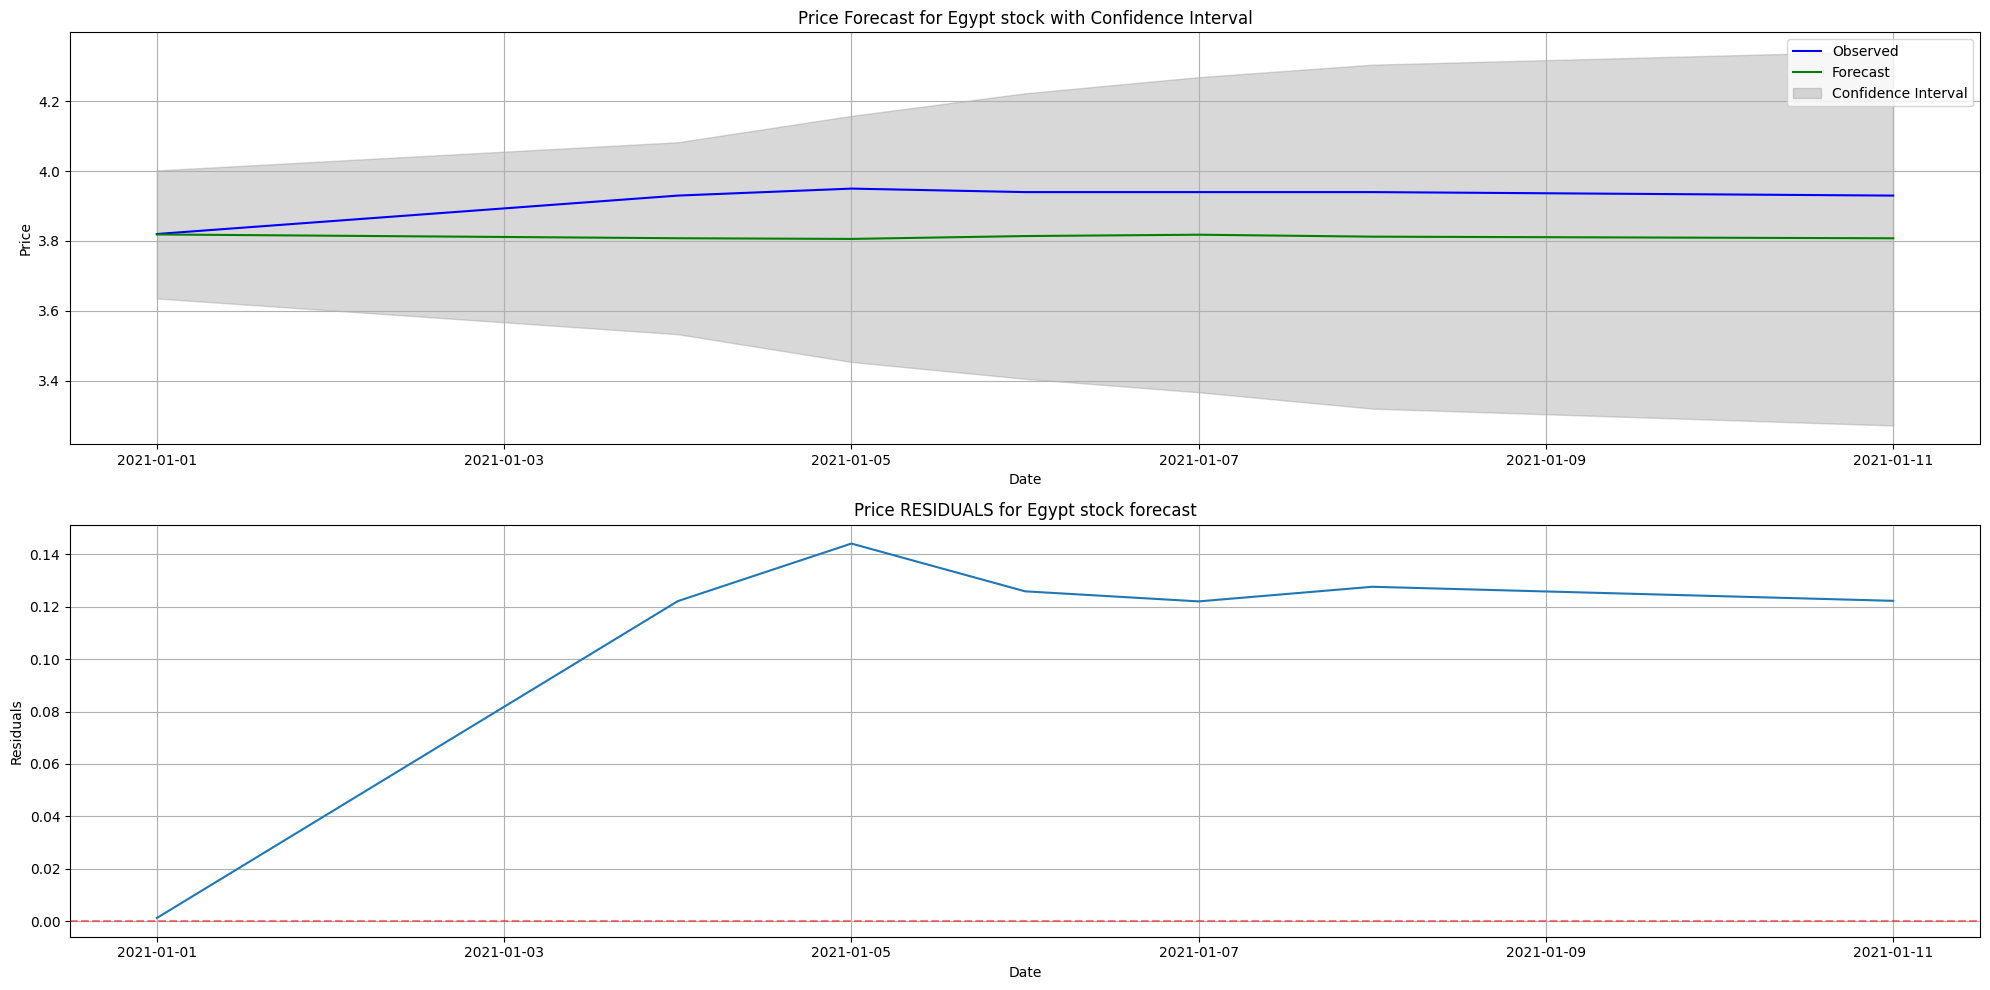

Mean Absolute Percent Error: 0.0278
Root Mean Squared Error: 0.1181


##########################################################################################




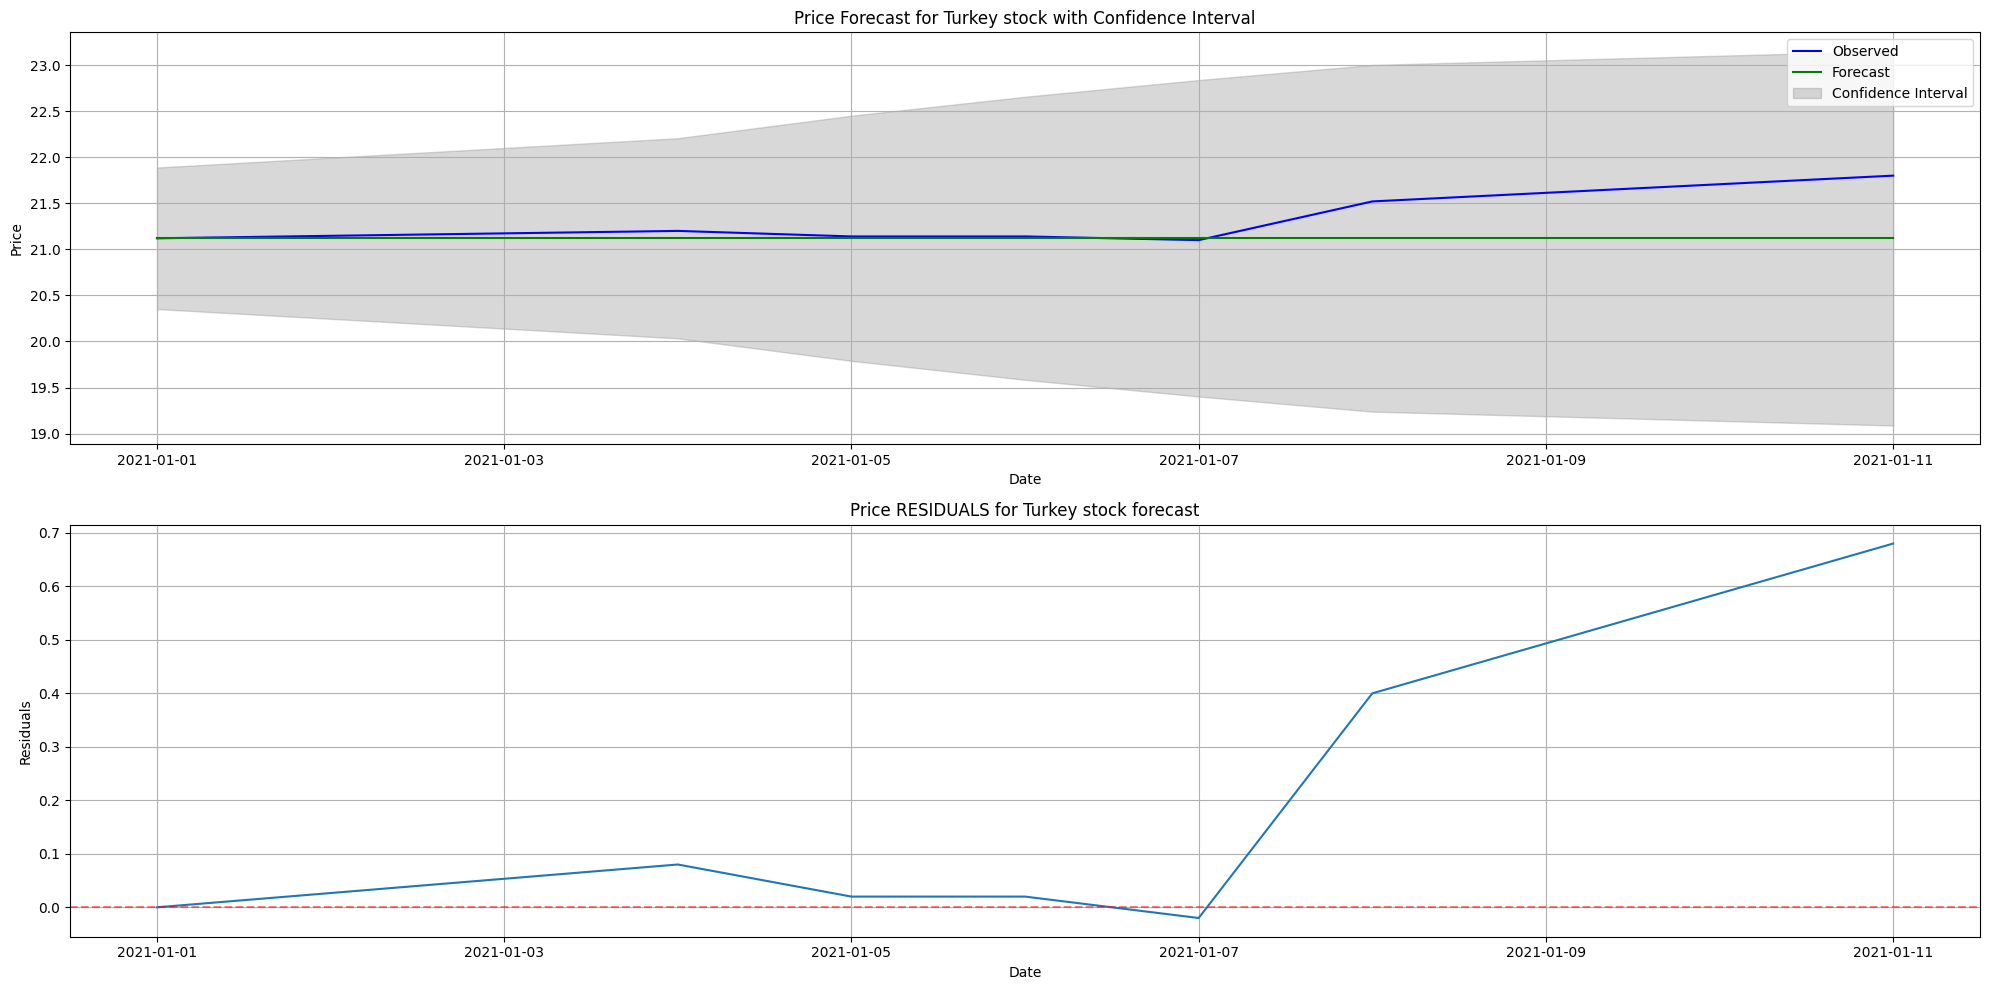

Mean Absolute Percent Error: 0.0081
Root Mean Squared Error: 0.3


##########################################################################################




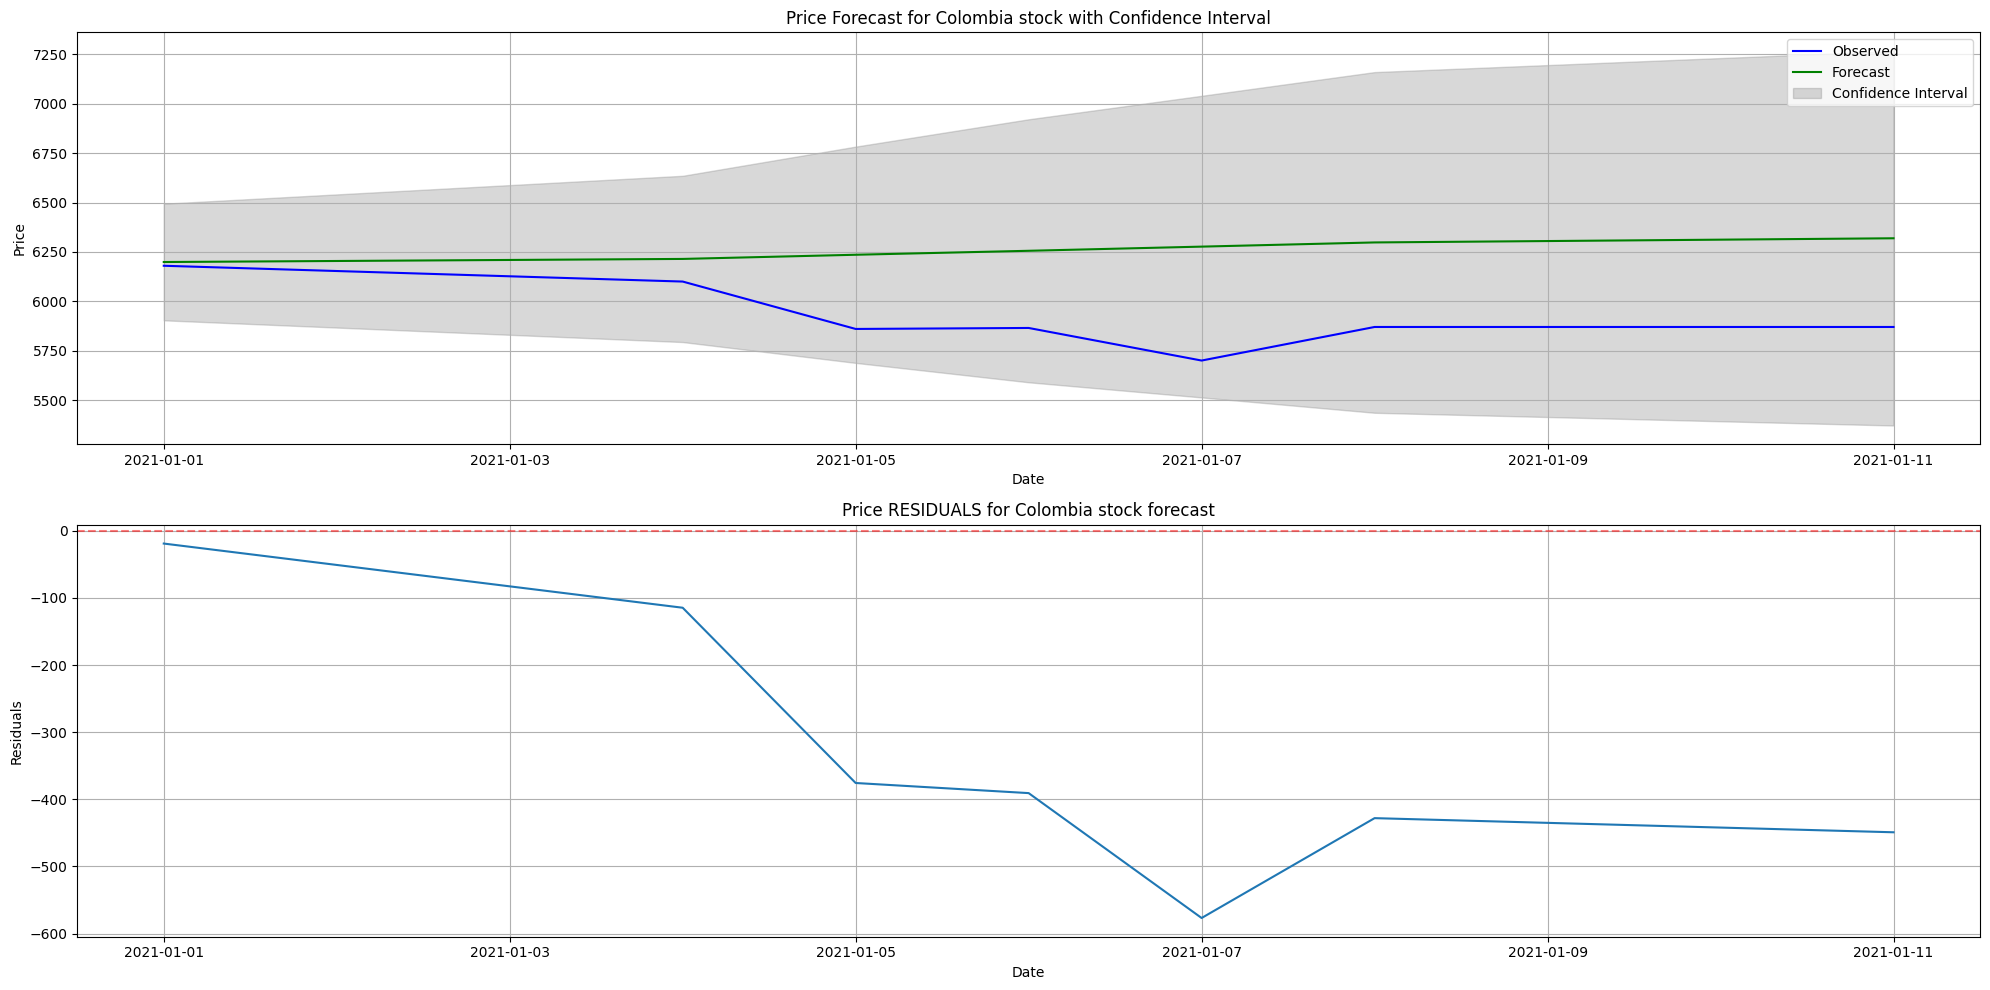

Mean Absolute Percent Error: 0.0576
Root Mean Squared Error: 382.6921


##########################################################################################




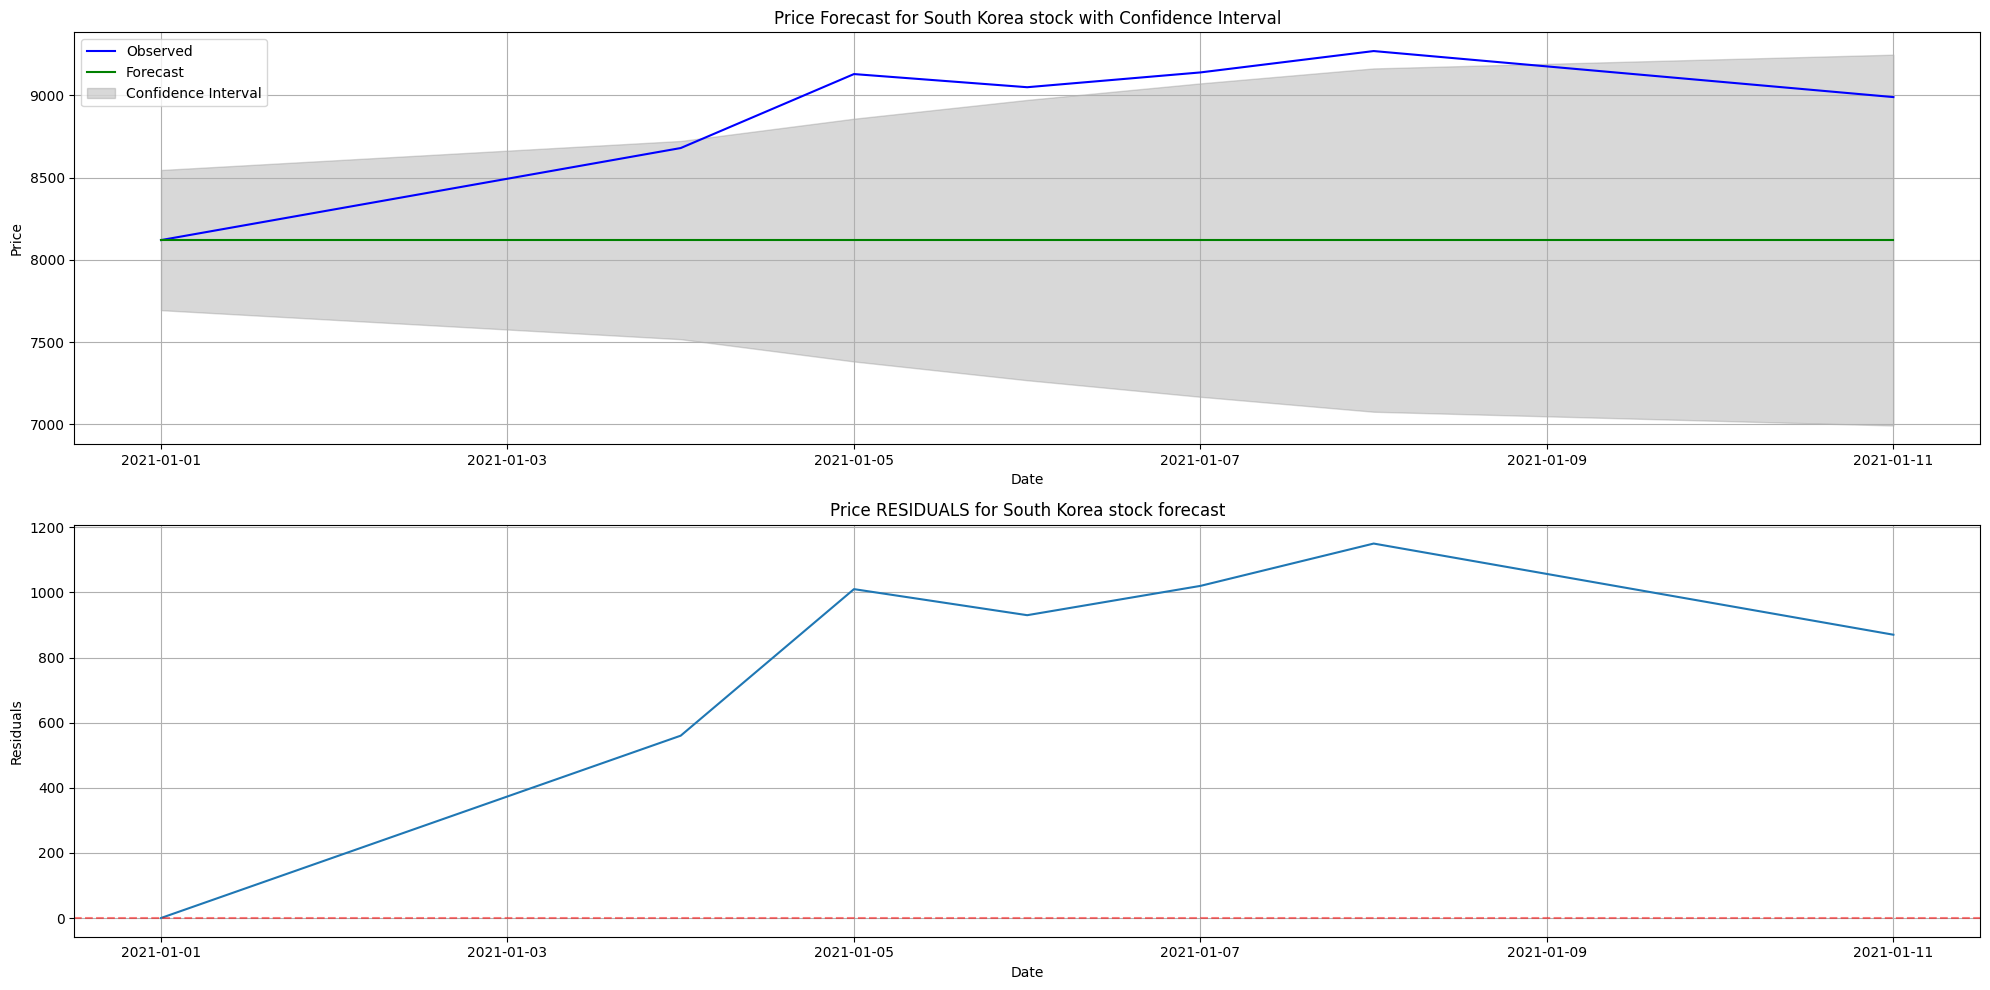

Mean Absolute Percent Error: 0.0872
Root Mean Squared Error: 871.6487


##########################################################################################




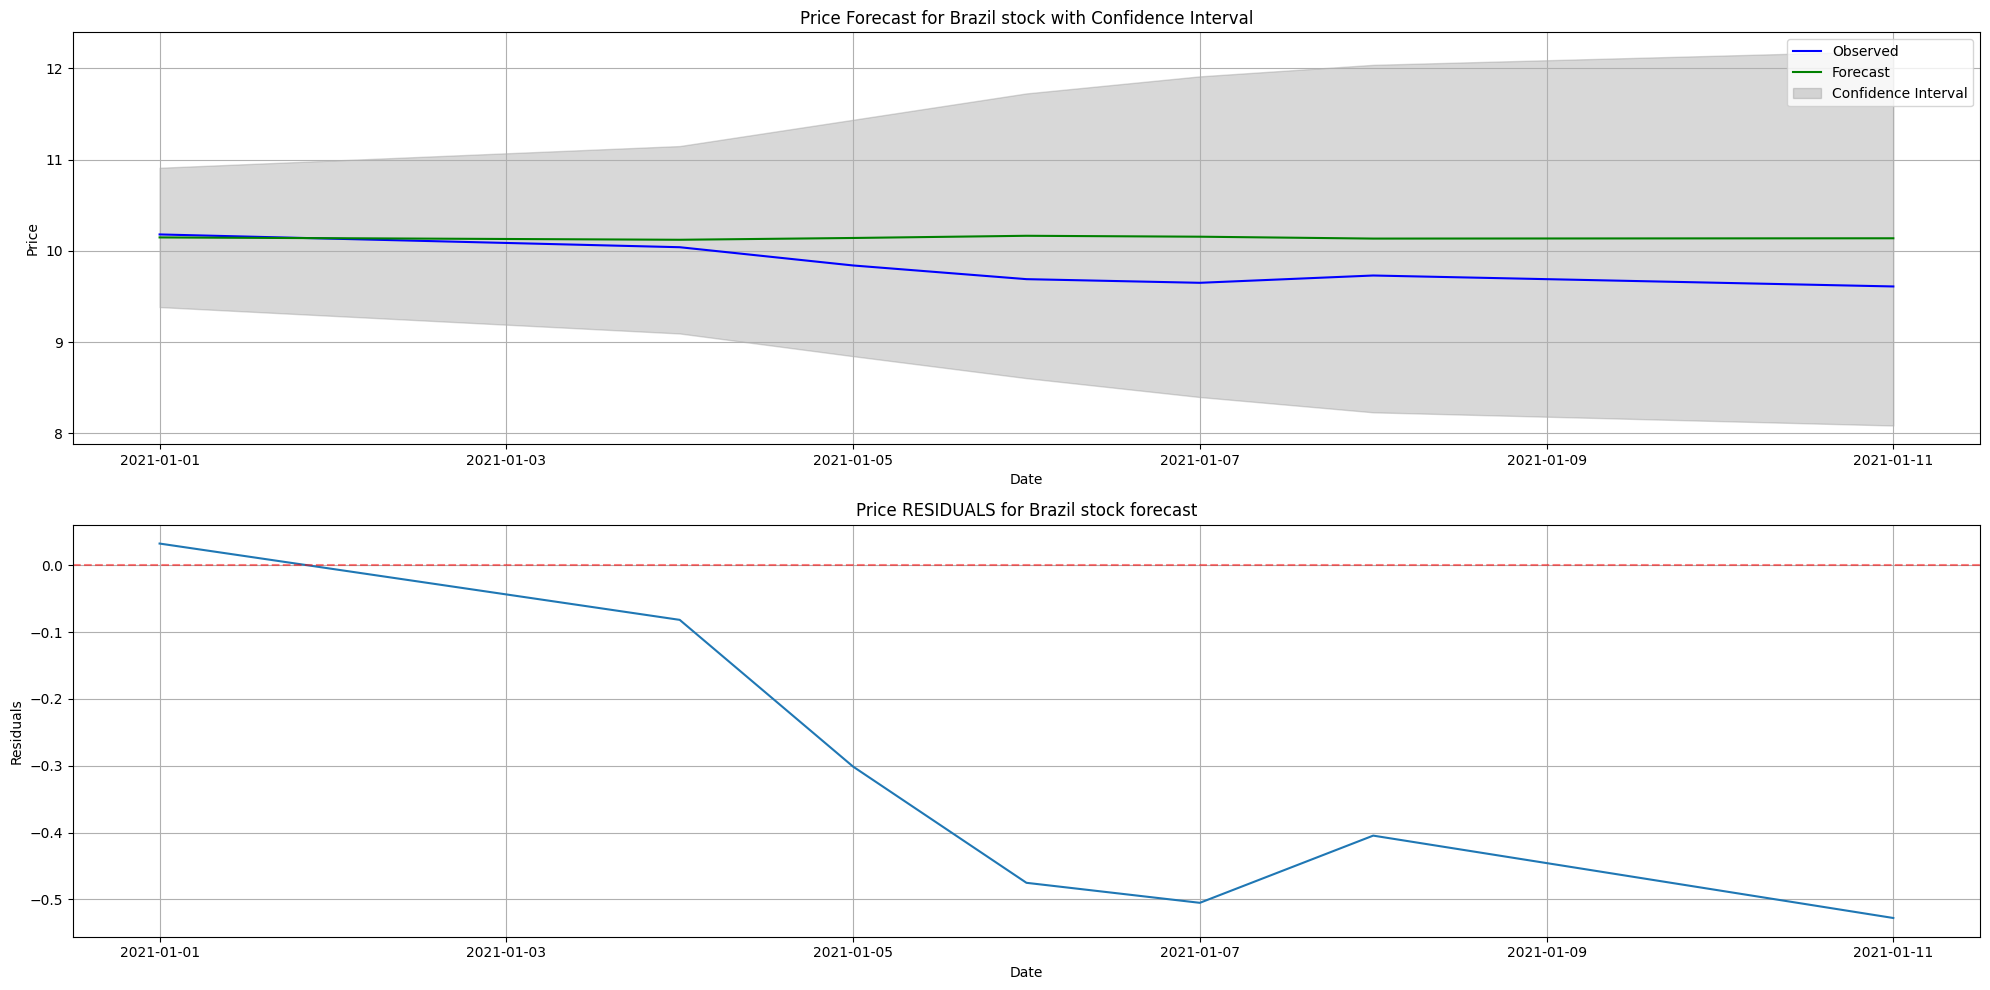

Mean Absolute Percent Error: 0.0343
Root Mean Squared Error: 0.3821


##########################################################################################




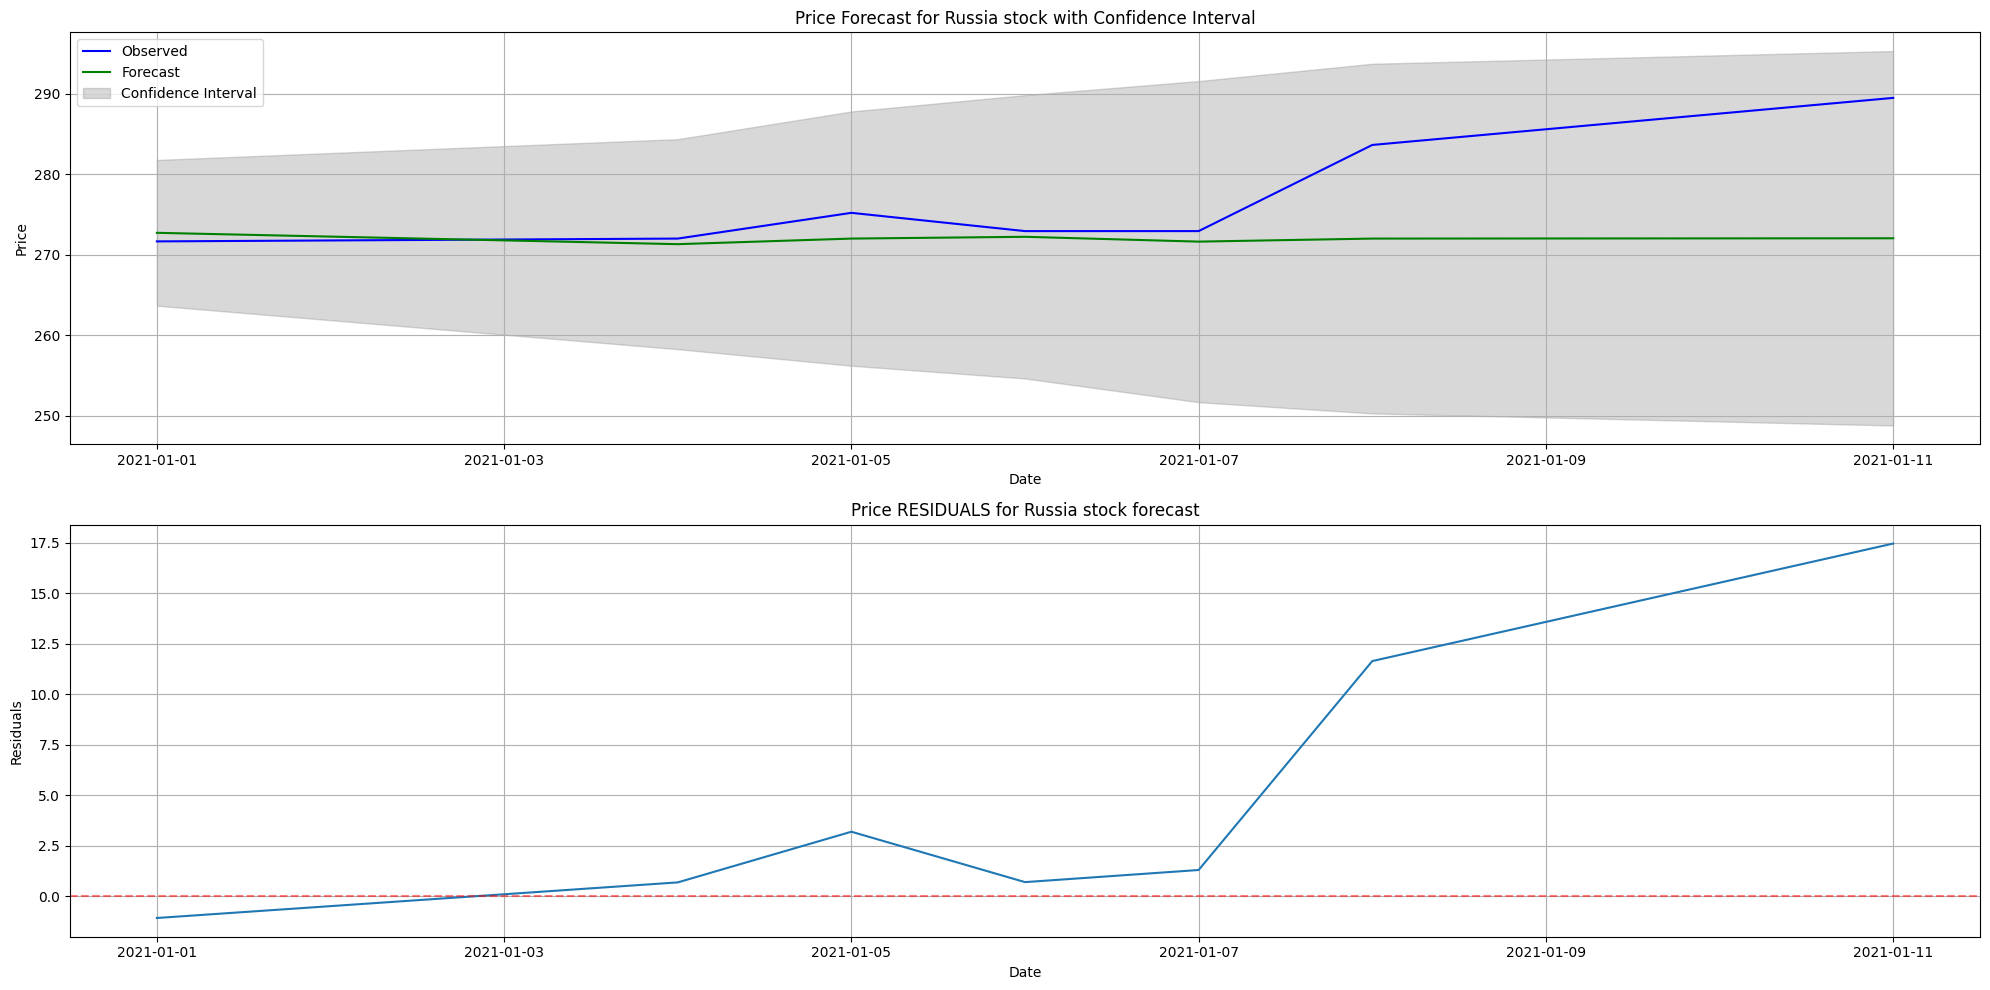

Mean Absolute Percent Error: 0.0181
Root Mean Squared Error: 8.0548


##########################################################################################




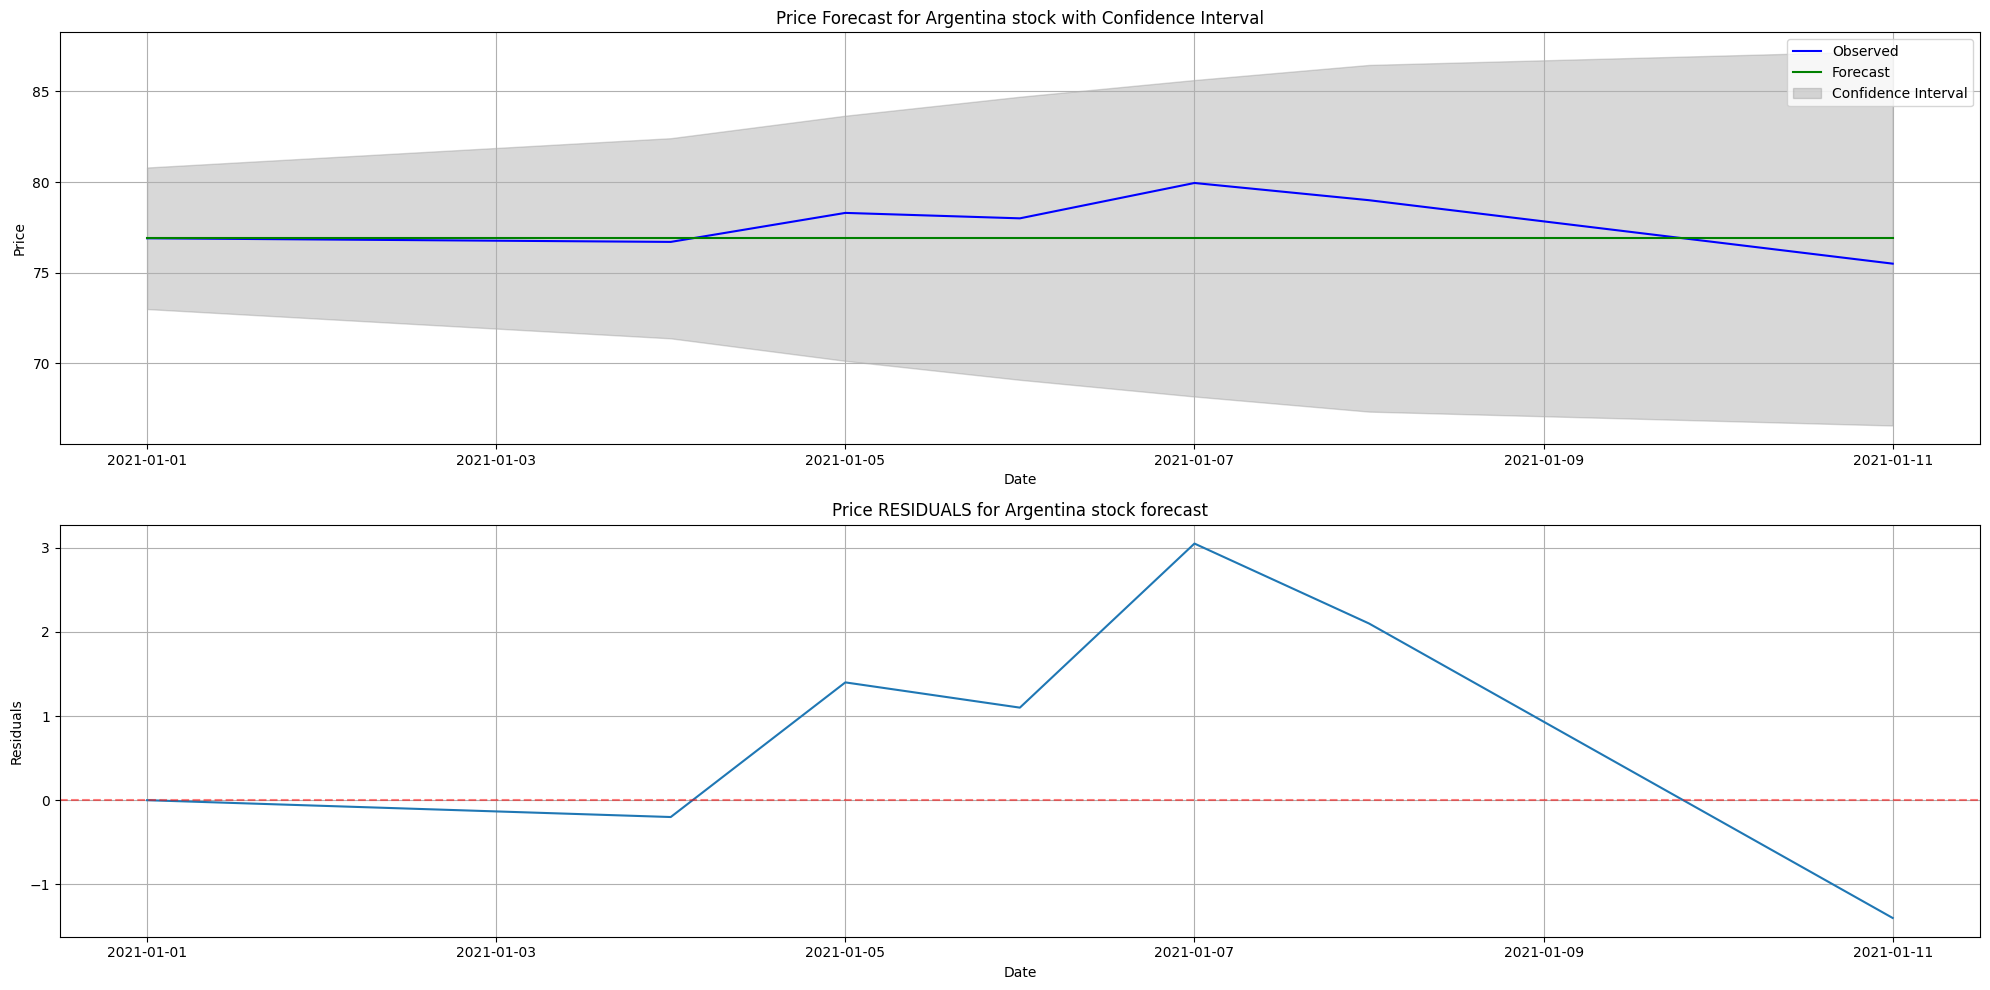

Mean Absolute Percent Error: 0.0168
Root Mean Squared Error: 1.6424


##########################################################################################




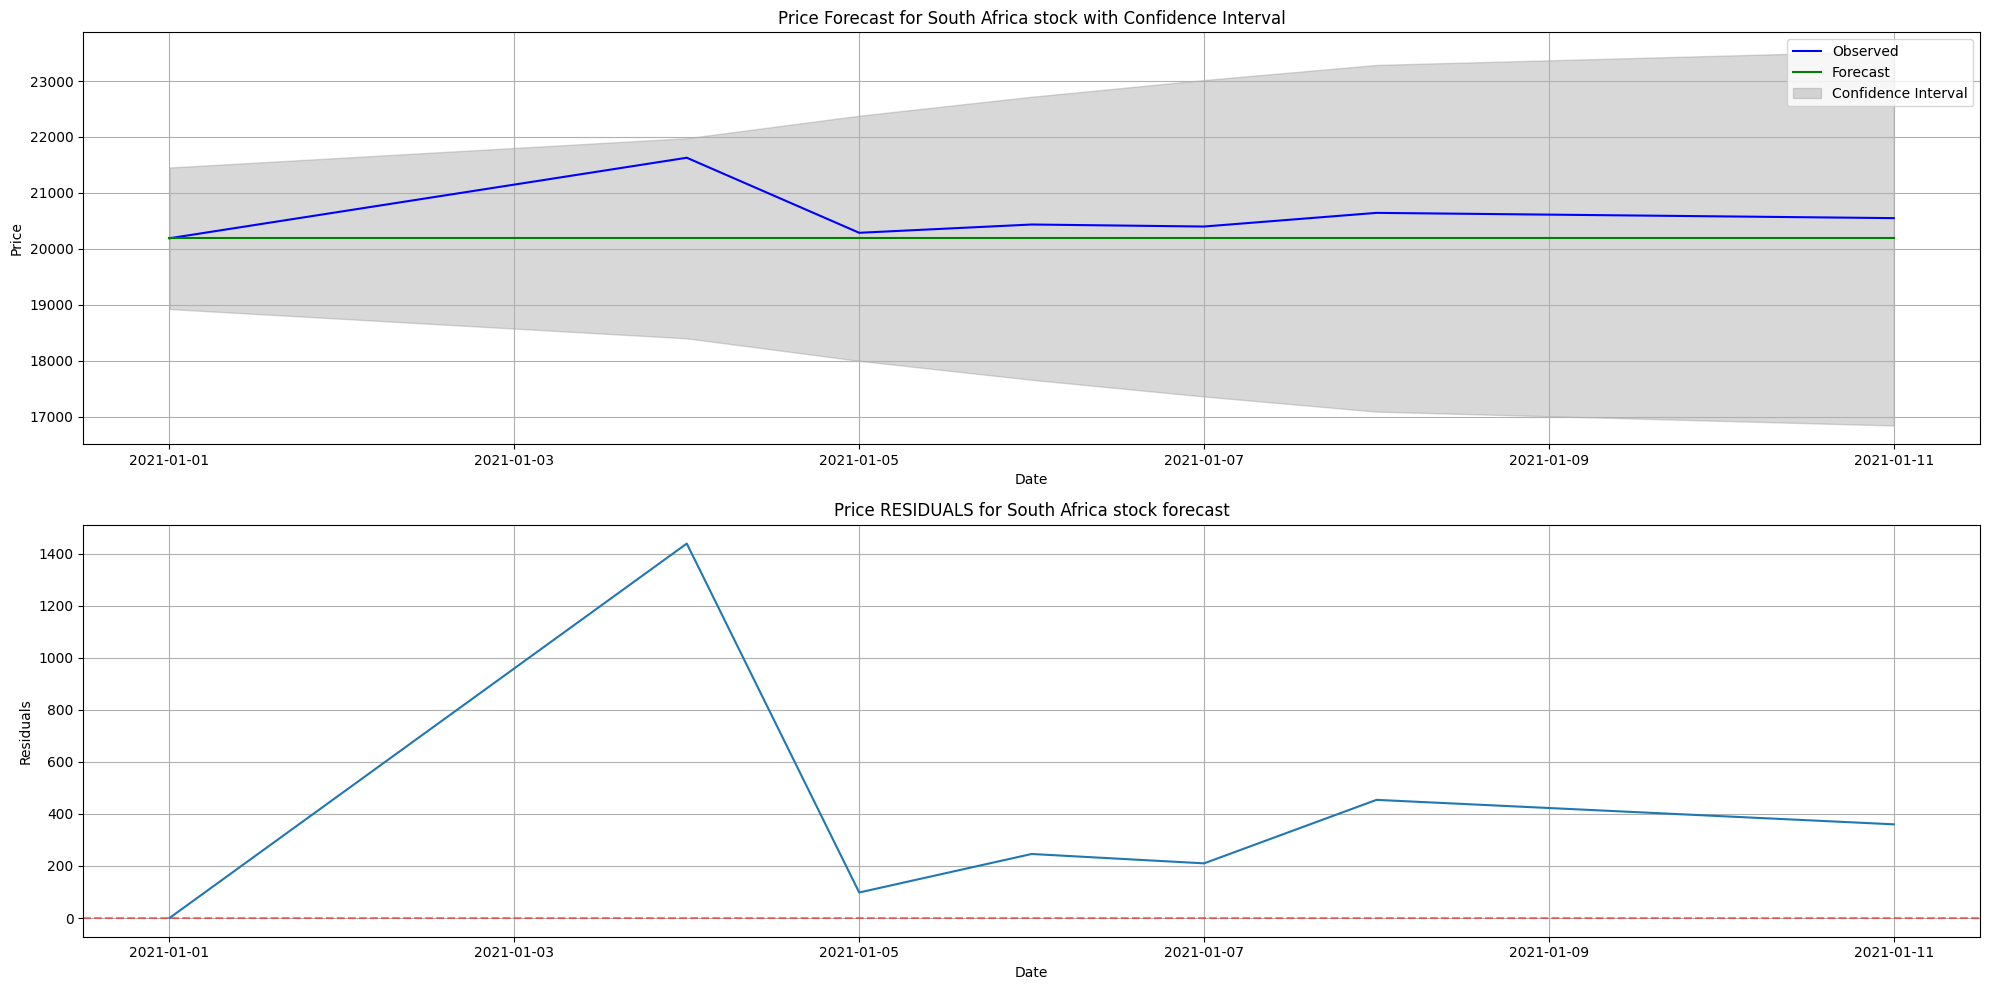

Mean Absolute Percent Error: 0.019
Root Mean Squared Error: 600.0782


##########################################################################################




In [63]:
train_end = datetime(2020,12,31)
n_forecast_periods = 7

for key in data.keys():
  # get the true observation of the forecast period
  test_data = data[key]['Price'][train_end + timedelta(days=1):]
  test_data = test_data[:n_forecast_periods]

  # make the actual forecast
  forecast, conf_int = price_trained_models[key].predict(n_periods=n_forecast_periods, return_conf_int=True)

  residuals = test_data - forecast

  # Plot the observed data
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
  axes[0].plot(test_data, label='Observed', color='blue')

  # Plot the forecasts and confidence intervals
  axes[0].plot(forecast, label='Forecast', color='green')
  axes[0].fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.3, label='Confidence Interval')

  # Customize the plot
  axes[0].set_title(f'Price Forecast for {key} stock with Confidence Interval')
  axes[0].set_xlabel('Date')
  axes[0].set_ylabel('Price')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(residuals)
  axes[1].axhline(y=0, color='red',  alpha=0.5, linestyle='--')

  # Customize the plot
  axes[1].set_title(f'Price RESIDUALS for {key} stock forecast')
  axes[1].set_xlabel('Date')
  axes[1].set_ylabel('Residuals')
  axes[1].grid(True)

  # Show the plot
  plt.tight_layout()
  plt.show()

  print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)), 4))
  print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))
  print('\n\n##########################################################################################\n\n')

# AutoARIMA - change predictions

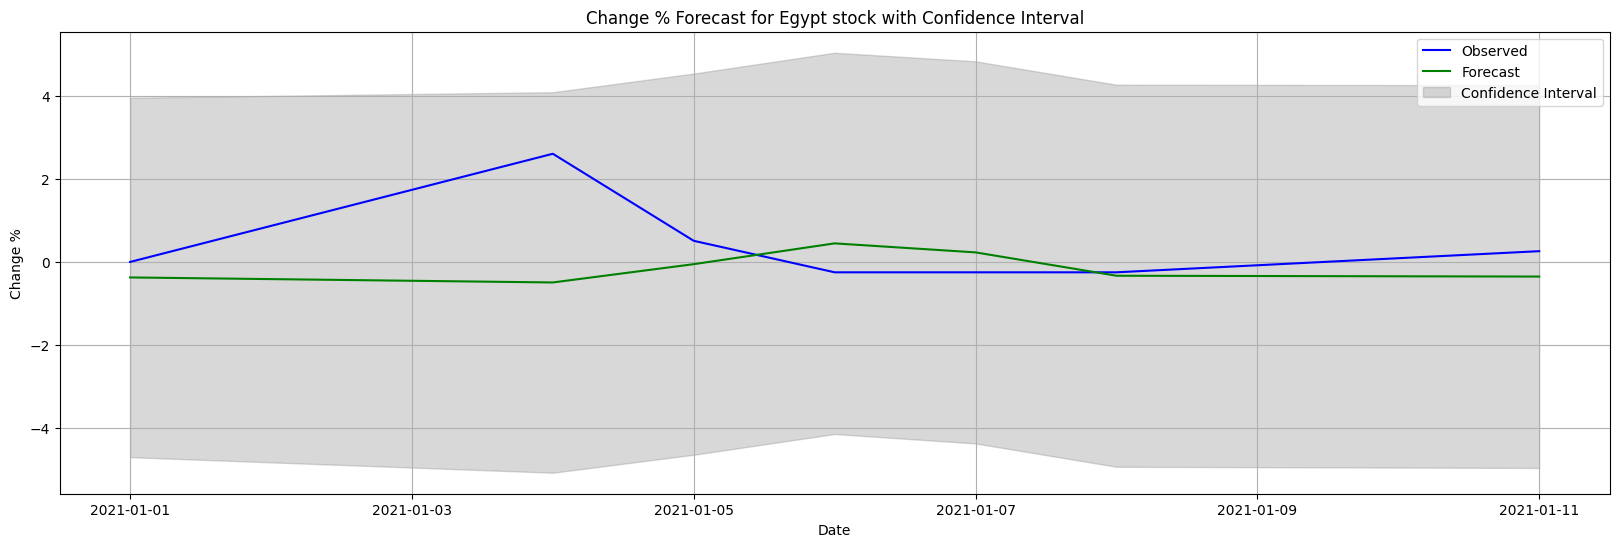

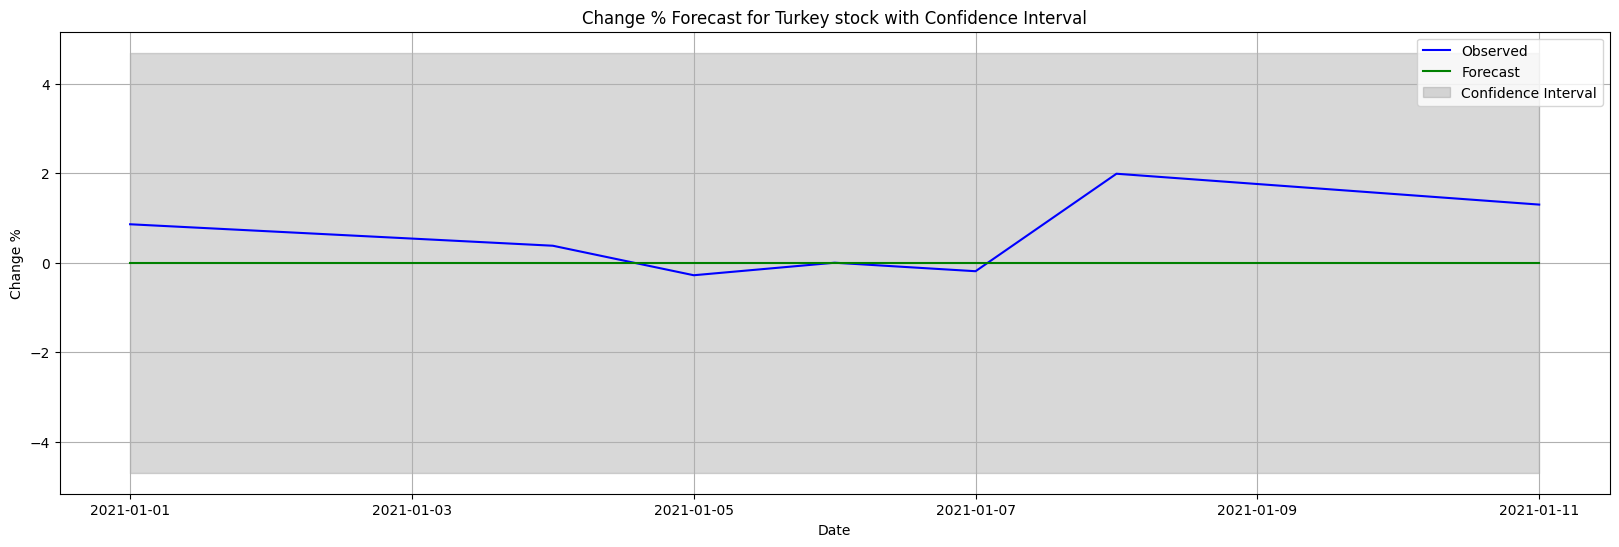

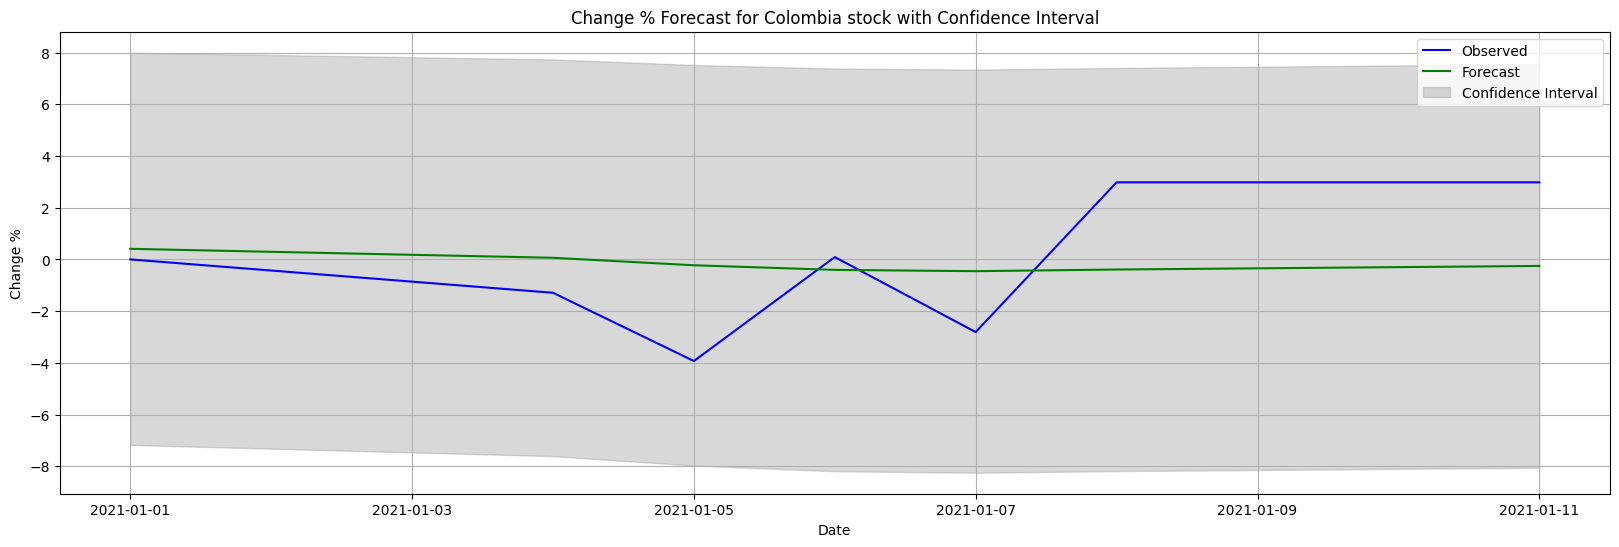

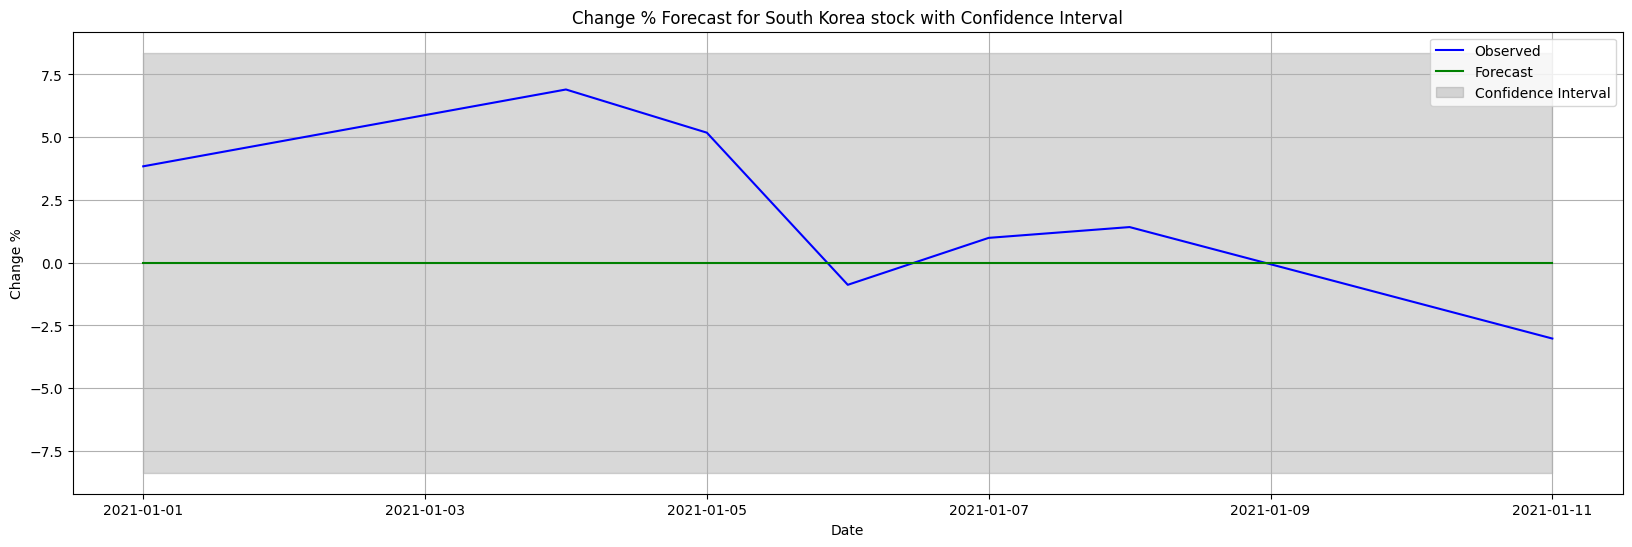

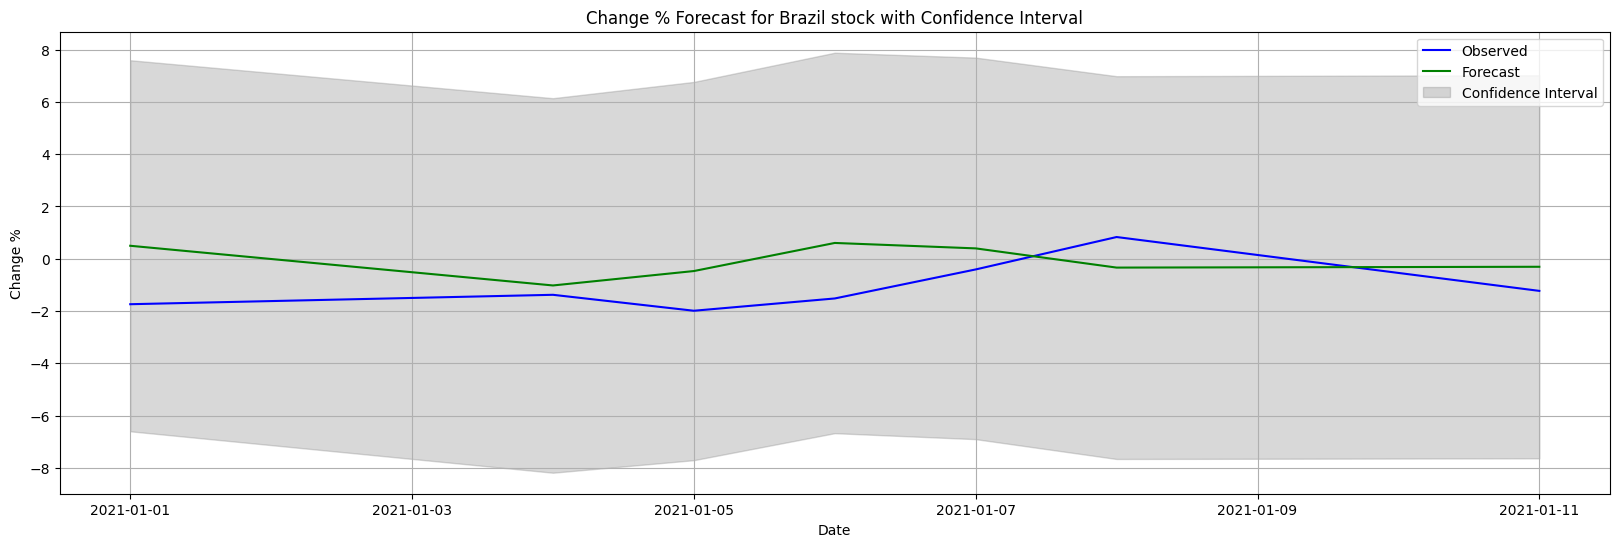

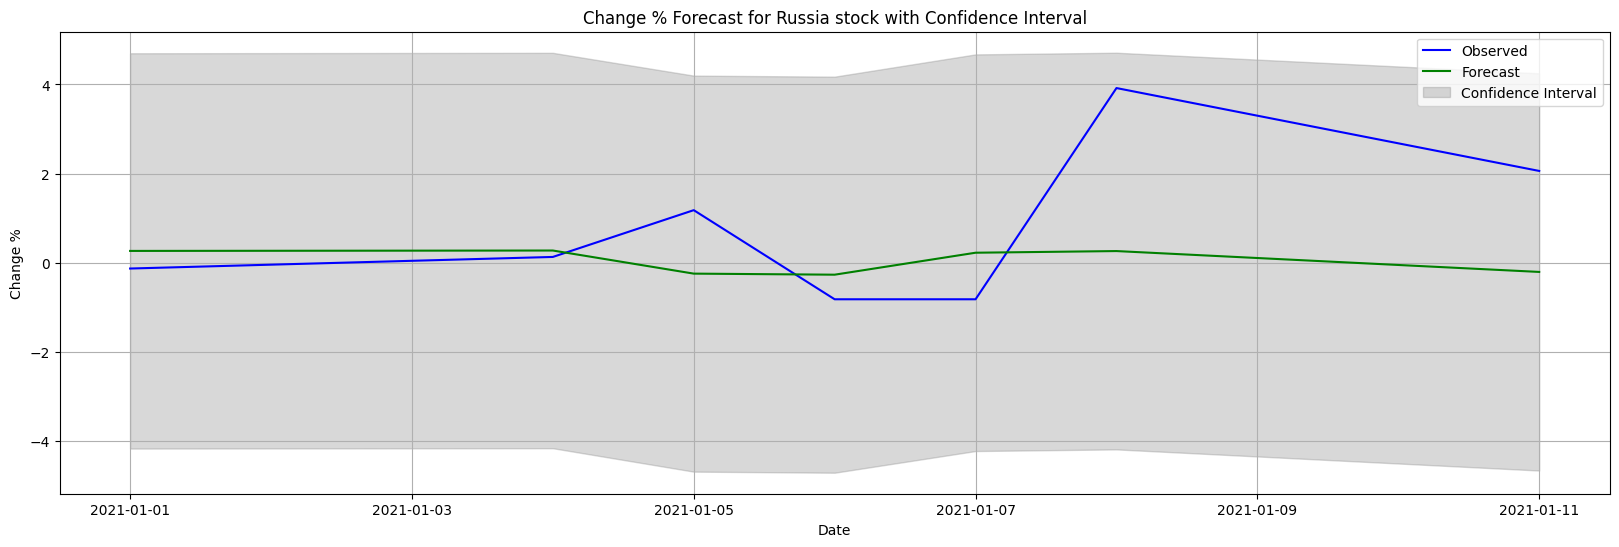

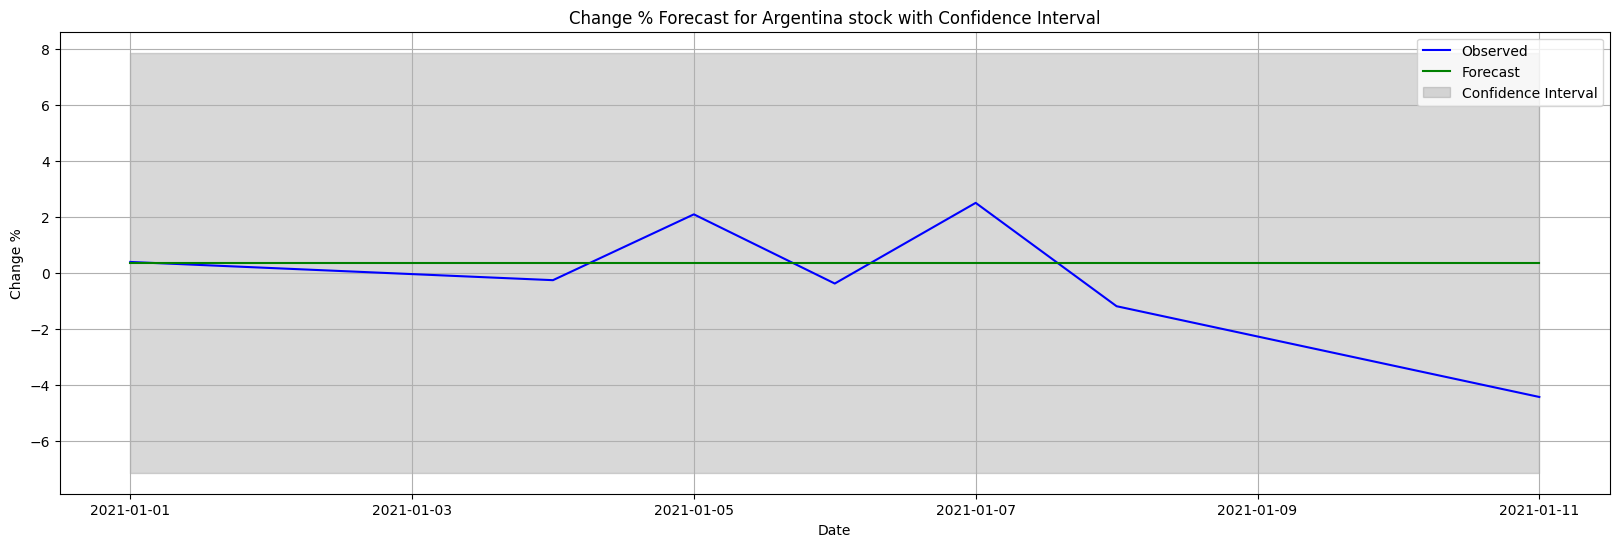

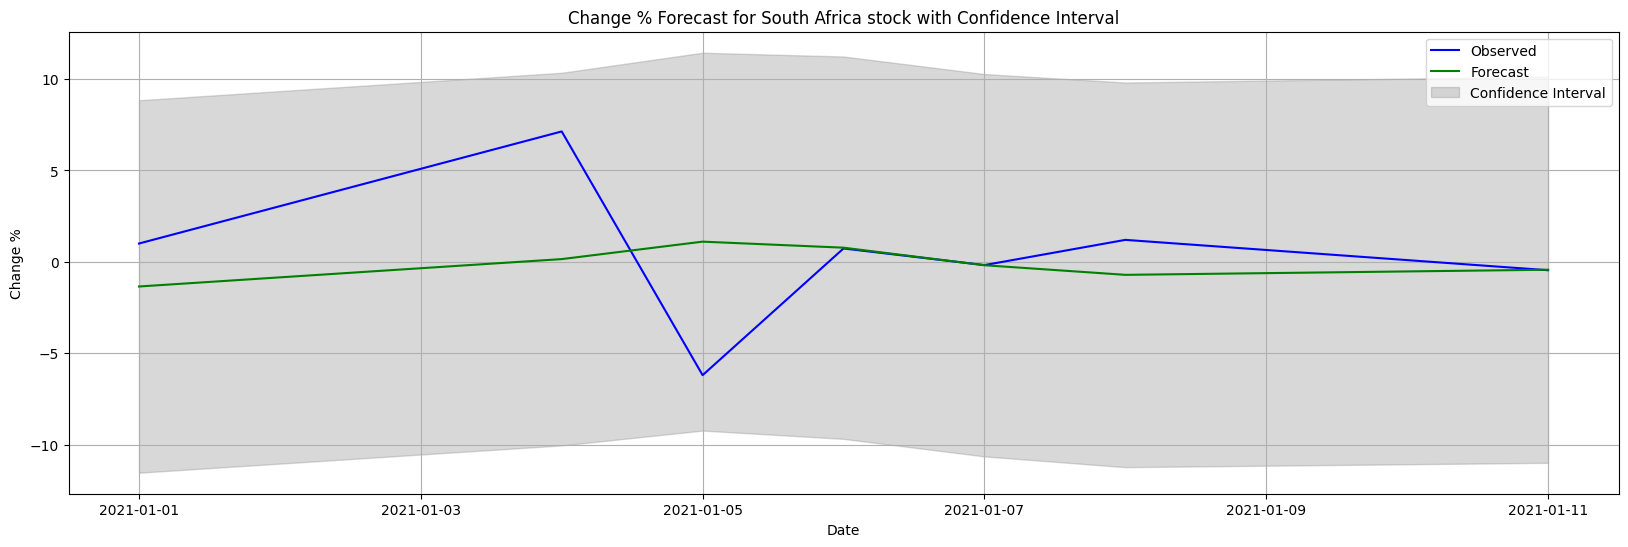

In [55]:
train_end = datetime(2020,12,31)
n_forecast_periods = 7

for key in data.keys():
  # get the true observation of the forecast period
  test_data = data[key]['Change %'][train_end + timedelta(days=1):]
  test_data = test_data[:n_forecast_periods]

  # make the actual forecast
  forecast, conf_int = change_trained_models[key].predict(n_periods=n_forecast_periods, return_conf_int=True)

  # Plot the observed data
  plt.figure(figsize=(20, 6))
  plt.plot(test_data, label='Observed', color='blue')

  # Plot the forecasts and confidence intervals
  plt.plot(forecast, label='Forecast', color='green')
  plt.fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.3, label='Confidence Interval')

  # Customize the plot
  plt.title(f'Change % Forecast for {key} stock with Confidence Interval')
  plt.xlabel('Date')
  plt.ylabel('Change %')
  plt.legend()
  plt.grid(True)

  # Show the plot
  plt.show()
  break

In [49]:
print('Mean Absolute Error:', round(np.mean(abs(residuals)), 4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Error: 1.8693
Root Mean Squared Error: 2.3578


The evaluation metrics, as expected, show the same performance level as the previous model

# Rolling Forecast Origin

We need to predict the stock prices on a **daily**, **weekly** and **monthly** basis.



In [50]:
# Define forecasting horizon (number of days to forecast)
forecast_horizon = 1

# Initialize an empty DataFrame to store forecast results
forecast_results = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])

# Perform rolling forecasts
for idx, end_date in enumerate(test_data.index[forecast_horizon-1:]):

  start_date = test_data.index[idx]

  # Select the training data up to the start_date
  curr_train_data = exp_data[:start_date - timedelta(days=1)]
  curr_test_data = exp_data[start_date : end_date]

  # train the model
  model = ARIMA(curr_train_data, order=(2,0,2))
  model_fit = model.fit()

  # make the predictions
  predictions = model_fit.predict(start=start_date, end=end_date)

  # Concat the results to the dataframe
  curr_results = pd.DataFrame({
      'Date': curr_test_data.index,
      'Actual': curr_test_data.values,
      'Forecast': np.round(predictions.values, 2)
  })
  forecast_results = pd.concat((forecast_results, curr_results), ignore_index=True)


In [51]:
import plotly.express as px

fig = px.line(forecast_results, x='Date', y=['Actual', 'Forecast'])
fig.show()

In [53]:
residuals = forecast_results['Actual'] - forecast_results['Forecast']

print('Mean Absolute Error:', round(np.mean(abs(residuals)), 4))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(residuals**2)), 4))

Mean Absolute Error: 1.9331
Root Mean Squared Error: 2.4554


using a rolling origin approach we improve the quality of the predictions, but not that much.

The problem here is the **model**: we are not using the most appropriate one